# Capstone Project
## Using Machine Learning in Trading Futures

Cell below is loading data obtained from [quandl.com](https://quandl.com). You can check how the resulting csv file was produced from raw trading data of futures contracts across multiple years. Workbook data-preparation.ipynb contains all the code.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5

delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=30)
validation_date = datetime.date(year=2018, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

dow = pd.read_csv('data/dow_daily.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_daily.csv', index_col='Date')

Convert index to date type.

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

dow.index = pd.DatetimeIndex(data=dow.index)
nasdaq.index = pd.DatetimeIndex(data=nasdaq.index)

Ensure that dataframe is sorted by index (date).

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')
dow = dow.sort_index(kind='mergesort')
nasdaq = nasdaq.sort_index(kind='mergesort')

Remove older dataframe - because we are missing COT.

In [4]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [5]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


### COT Feature engineering
Determine how far we are from top across last 2 years (730 days).

In [6]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [7]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

### Williams %R
Create feature with Williams %R indicator

In the end I decided not to use any indicator.

In [8]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

### Create Targets
Based on the threshold, fee and delta calculate targets used for supervised learning.

In [9]:
def calculate_target(row, threshold):
    global fee, delta, stop_loss
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + threshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, threshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(lambda x: calculate_target(x, threshold), axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [10]:
threshold = 500
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, threshold)
gold_gains_train = gold_gains.loc[gold_gains.index < '2018-1-1']
# gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0       0
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0       0
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


In [11]:
# get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,0.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,0.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,0.0


### Trade gains investigation

Ivestigate trade gains
- have a look at all gains (regardless of label)
- analyze gains for long trades (label 1)
- analyze gains for short trades (label -1)

### Trade labels distribution

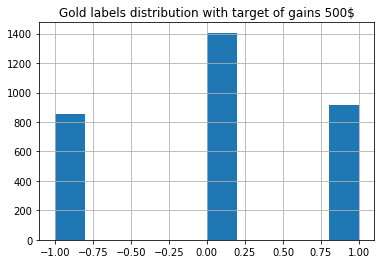

In [12]:
from matplotlib.pyplot import savefig

ax = gold['target'].hist()
ax.set_title('Gold labels distribution with target of gains 500$')
savefig('figures/gold_target_distribution.eps')

In [13]:
gold_gains_train.gains.describe()

count     2921.000000
mean        -6.878637
std       1225.716089
min     -11390.500000
25%       -560.500000
50%         28.500000
75%        627.000000
max       6555.000000
Name: gains, dtype: float64

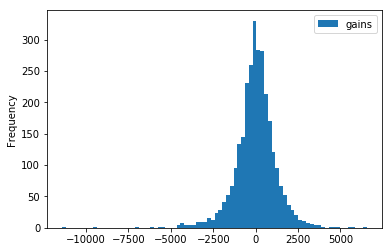

In [14]:
gold_gains_train[['gains']].plot.hist(bins=80)

In [15]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [16]:
gold_gains_train = stop_loss_gen(gold_gains_train)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    ax = plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')
    return ax

### Investigate suitable stop-loss value

Below are cumulative curves.
Red line denotes 90% mark. What stop-loss should you use when you want 90% of trades to get completed (trade from open  to close)?

Following curves are investigating stop losses based on the label.

| trade | commodity | stop loss |
|-------|-----------|-----------|
| long  |      gold |      1000 |
| short |      gold |       800 |
| long  |      corn |       300 |
| short |      corn |       300 |
| long  |    coffee |       800 |
| short |    coffee |       800 |



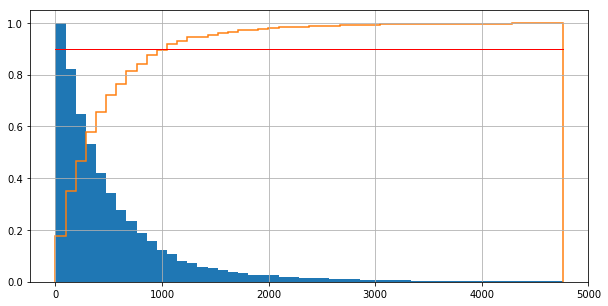

In [18]:
ax = plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == 1], 'Open_Low')
# print(type(ax[0]))
# print(type(ax))
# ax.set_title('Gold stop loss long trades')
savefig('figures/gold_stop_loss_long_trades.eps')

In [19]:
gold_gains_train[gold_gains_train.target == 1].Open_Low.describe()

count     860.000000
mean      472.825581
std       538.691375
min         0.000000
25%       130.000000
50%       310.000000
75%       640.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [20]:
gold_gains_train[gold_gains_train.target == -1].Open_High.describe()

count     802.000000
mean      429.077307
std       439.462157
min         0.000000
25%       150.000000
50%       310.000000
75%       570.000000
max      4380.000000
Name: Open_High, dtype: float64

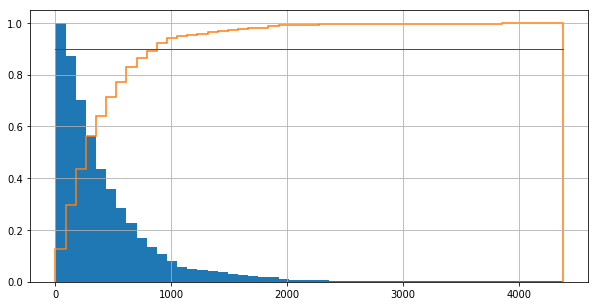

In [21]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == -1], 'Open_High')
savefig('figures/gold_stop_loss_short_trades.eps')

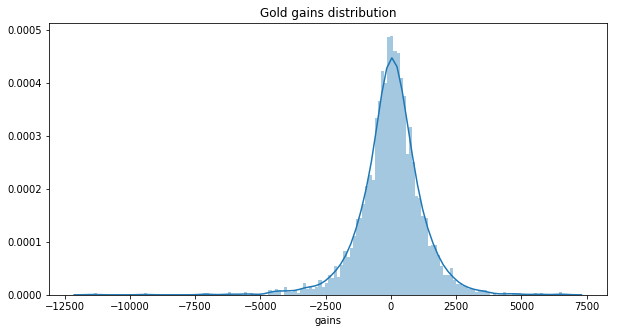

In [22]:
sr = gold_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, bins=150, ax=ax)
ax.set_title('Gold gains distribution')
savefig('figures/gold_gains_distribution.eps')

In [23]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
threshold = 150
corn_gains = create_trade_outcomes(corn, contracts, threshold)
corn_gains_train = corn_gains.loc[corn_gains.index < '2018-1-1']

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


In [24]:
corn_gains_train.gains.describe()

count    2917.000000
mean        6.122729
std       411.069273
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       213.750000
max      1888.125000
Name: gains, dtype: float64

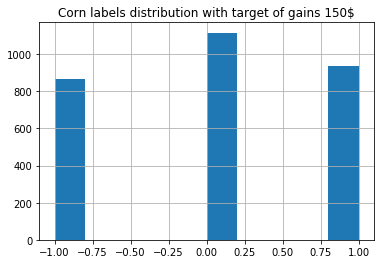

In [25]:
# get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

ax = corn.loc[corn.index < '2018-1-1'].target.hist()
ax.set_title('Corn labels distribution with target of gains 150$')
savefig('figures/corn_target_distribution.eps')

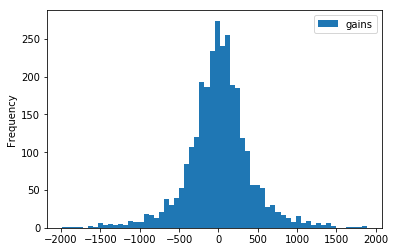

In [26]:
ax = corn_gains_train[['gains']].plot.hist(bins=60)

In [27]:
corn_gains_train.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [28]:
corn_gains = stop_loss_gen(corn_gains)
corn_gains_train = corn_gains[corn_gains.index < '2018-1-1']

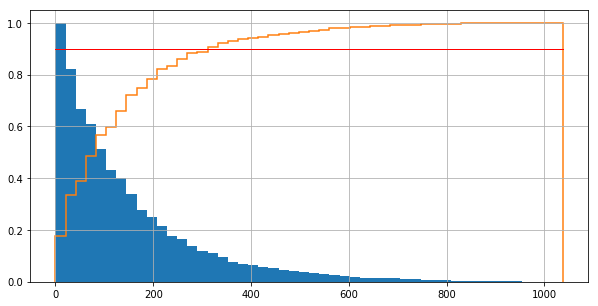

In [29]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == 1], 'Open_Low')
savefig('figures/corn_stop_loss_long_trades.eps')

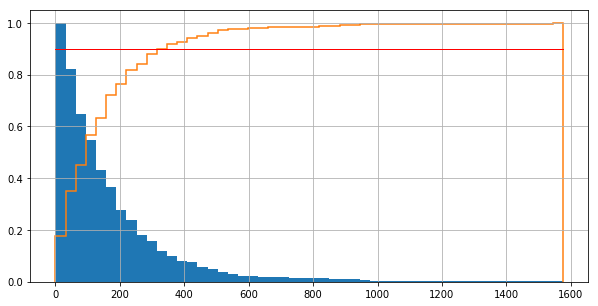

In [30]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == -1], 'Open_High')
savefig('figures/corn_stop_loss_short_trades.eps')

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


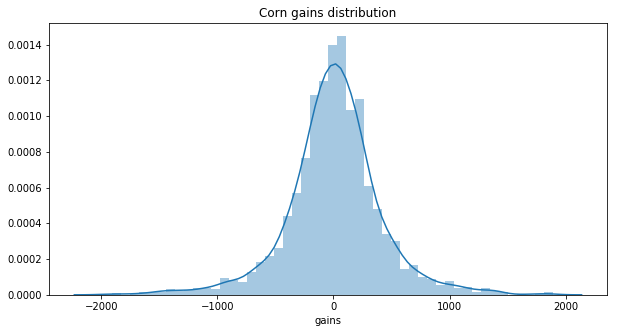

In [31]:
sr = corn_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, ax=ax)
ax.set_title('Corn gains distribution')
savefig('figures/corn_gains_distribution.eps')

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


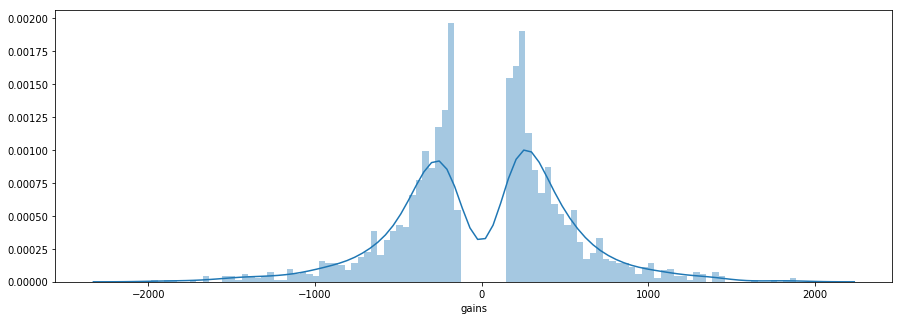

In [32]:
sr = corn_gains_train[corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [33]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
threshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, threshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains_train = coffee_gains.loc[coffee_gains.index < '2018-1-1']

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


In [34]:
coffee_gains_train.gains.describe()

count    2908.000000
mean      -11.546273
std      1070.462227
min     -5236.875000
25%      -516.562500
50%         0.000000
75%       498.750000
max      6341.250000
Name: gains, dtype: float64

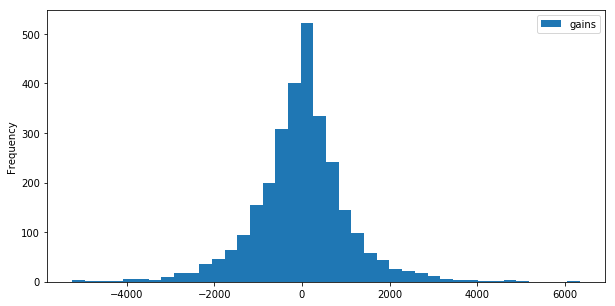

In [35]:
coffee_gains_train[['gains']].plot.hist(bins=40, figsize=(10, 5))

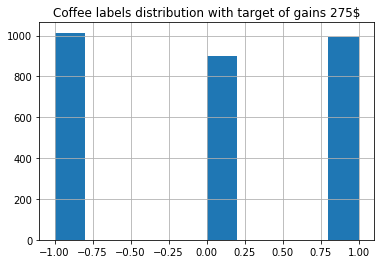

In [36]:
# get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
ax = coffee.loc[coffee.index < '2018-1-1'].target.hist()
ax.set_title('Coffee labels distribution with target of gains 275$')
savefig('figures/coffee_target_distribution.eps')

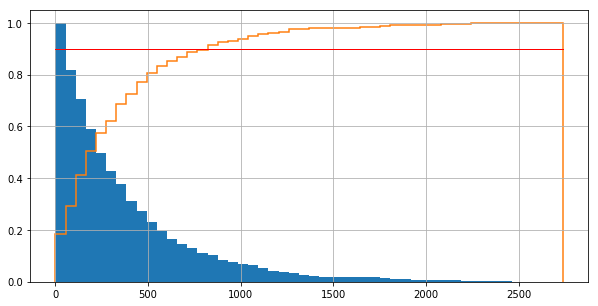

In [37]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == 1], 'Open_Low')
savefig('figures/coffee_stop_loss_long_trades.eps')

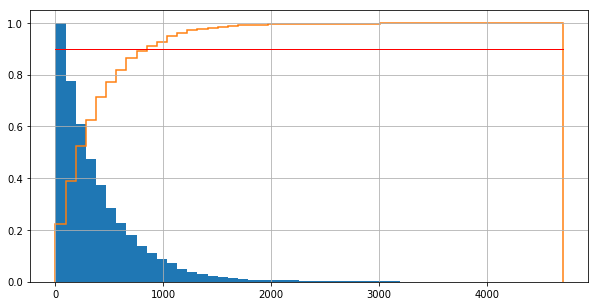

In [38]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == -1], 'Open_High')
savefig('figures/coffee_stop_loss_short_trades.eps')

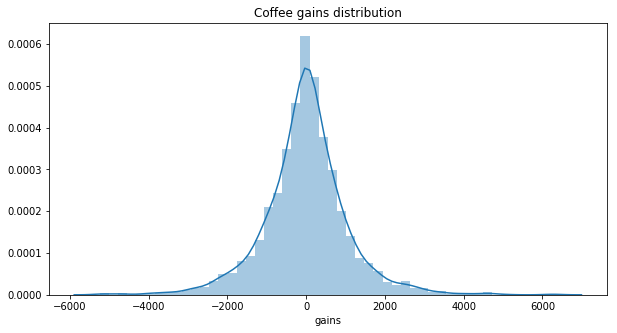

In [39]:
sr = coffee_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, ax=ax)
ax.set_title('Coffee gains distribution')
savefig('figures/coffee_gains_distribution.eps')

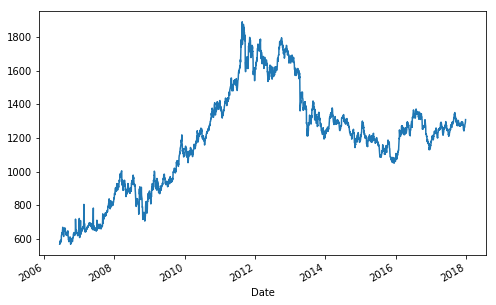

In [40]:
ax = gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(8, 5))
savefig('figures/gold.eps')

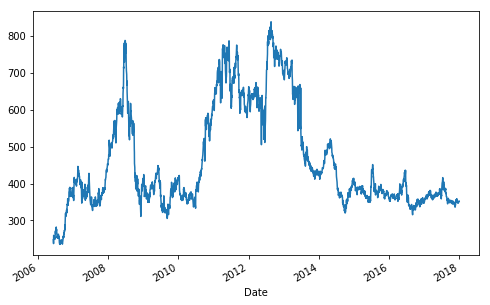

In [41]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(8, 5))
savefig('figures/corn.eps')

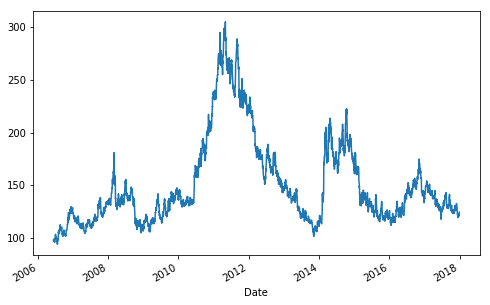

In [42]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(8, 5))
savefig('figures/coffee.eps')

# Feature Engineering

Code below create date features. In order to capture cyclicality I have transformed features as trading day of month or day of week into $sin$ and $cos$ values.
I am not sure whether this transformation grants subsequent PCA usage.

In [43]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_cycle(x, period):
    sn = np.sin(x*(2.*np.pi/period))
    cs = np.cos(x*(2.*np.pi/period))
    return sn, cs


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        wsn, wcs = create_cycle(dt.weekday(), 5)
        # period for trading day in month is at most 23
        tsn, tcs = create_cycle(trading_day_of_month(idx), 23)
        dsn, dcs = create_cycle(dt.month, 12)
        qsn, qcs = create_cycle((dt.month-1)//3, 4)
        mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs]
        # mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [44]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

cols = list(range(2544))
gold_data_reg = gold_data[cols].join(gold_gains[['gains']].rename(columns={"gains": 2544}))
corn_data_reg = corn_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))
coffee_data_reg = coffee_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))

In [45]:
gold_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2018-12-21,1134.0,1138.8,1131.0,1133.2,110023.0,1133.2,1135.5,1128.6,1130.7,115561.0,...,0.346733,-0.951057,0.309017,-0.816970,-0.576680,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-24,1133.2,1135.5,1128.6,1130.7,115561.0,1130.0,1137.3,1129.5,1133.6,71039.0,...,0.346733,0.000000,1.000000,-0.942261,-0.334880,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-26,1130.0,1137.3,1129.5,1133.6,71039.0,1135.3,1151.7,1132.8,1138.8,102763.0,...,0.346733,0.587785,-0.809017,-0.979084,0.203456,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-27,1135.3,1151.7,1132.8,1138.8,102763.0,1139.3,1145.1,1137.1,1140.9,100470.0,...,0.346733,-0.587785,-0.809017,-0.887885,0.460065,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-28,1139.3,1145.1,1137.1,1140.9,100470.0,1143.1,1160.6,1142.6,1158.1,153065.0,...,0.346733,-0.951057,0.309017,-0.730836,0.682553,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0


In [46]:
gold_data_reg.head()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-760.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-2213.5
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1111.5
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1092.5
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,199.5


Removing Nan from data

In [47]:
gold_data.shape

(2668, 2545)

In [48]:
gold_data = gold_data.dropna()
gold_data.shape

(2668, 2545)

In [49]:
print(corn_data.shape)
corn_data = corn_data.dropna()
corn_data.shape

(2664, 2545)


(2664, 2545)

In [50]:
print(coffee_data.shape)
coffee_data = coffee_data.dropna()
coffee_data.shape

(2655, 2545)


(2655, 2545)

In [51]:
print(gold_data_reg.shape)
gold_data_reg = gold_data_reg.dropna()
gold_data_reg.shape

(2668, 2545)


(2668, 2545)

In [52]:
print(corn_data_reg.shape)
corn_data_reg = corn_data_reg.dropna()
corn_data_reg.shape

(2664, 2545)


(2664, 2545)

In [53]:
print(coffee_data_reg.shape)
coffee_data_reg = coffee_data_reg.dropna()
coffee_data_reg.shape

(2655, 2545)


(2654, 2545)

In [54]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [55]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

gold_data_reg = gold_data_reg.loc[gold_data_reg.index >= '2007-01-01']
corn_data_reg = corn_data_reg.loc[corn_data_reg.index >= '2007-01-01']
coffee_data_reg = coffee_data_reg.loc[coffee_data_reg.index >= '2007-01-01']

In [56]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 2544
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    
    pca = PCA(n_components=200, random_state=2234)
    # pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(label_index))])
    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 2544
    df_pca = pca.transform(df[list(range(label_index))])
    
    return df_pca

In [57]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

gold_reg_train, gold_reg_test, gold_reg_label_train, gold_reg_label_test, gold_reg_validate, gold_reg_label_validate, gold_reg_pca = data_split_pca_transform(gold_data_reg)
corn_reg_train, corn_reg_test, corn_reg_label_train, corn_reg_label_test, corn_reg_validate, corn_reg_label_validate, corn_reg_pca = data_split_pca_transform(corn_data_reg)
coffee_reg_train, coffee_reg_test, coffee_reg_label_train, coffee_reg_label_test, coffee_reg_validate, coffee_reg_label_validate, coffee_reg_pca = data_split_pca_transform(coffee_data_reg)

# Outlier detection
The code below is using random forest. I am relying on automatic outlier detection.

In [58]:
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

pca_gold = pca_transform(gold_train, gold_pca)
out_gold = IsolationForest(contamination='auto', behaviour='new')
modified_gold = out_gold.fit_predict(pca_gold)

pca_corn = pca_transform(corn_train, corn_pca)
out_corn = IsolationForest(contamination='auto', behaviour='new')
modified_corn = out_corn.fit_predict(pca_corn)

pca_coffee = pca_transform(coffee_train, coffee_pca)
out_coffee = IsolationForest(contamination='auto', behaviour='new')
modified_coffee = out_coffee.fit_predict(pca_coffee)


def remove_outliers(arr, y, isolation):
    lst = out_gold.predict(X)
    a = []
    y_a = []
    for v, h, k in zip(lst, y, X):
        if v == 1:
            a.append(k)
            y_a.append(h)
    a = np.array(a)
    y_a = np.array(y_a)
    return a, y_a

In [59]:
def plot_hist_perc(x):
    df = pd.DataFrame(x)

    ln = df[0].count()
    dct = {}
    dct[-1] = df[df[0] == -1][0].count() / ln
    dct[1] = df[df[0] == 1][0].count() / ln
    
    print('outliers: ' + str(df[df[0] == -1][0].count()))
    print('inliers: ' + str(df[df[0] == 1][0].count()))

    rf = pd.DataFrame.from_dict(dct, orient='index')

    ax = rf.plot(kind='bar', figsize=(10,5), legend=False)
    for i in ax.patches:
        ax.text(i.get_x()-.2, i.get_height()-.05, \
                str(round(i.get_height(),4)), fontsize=15)

outliers: 2
inliers: 1931


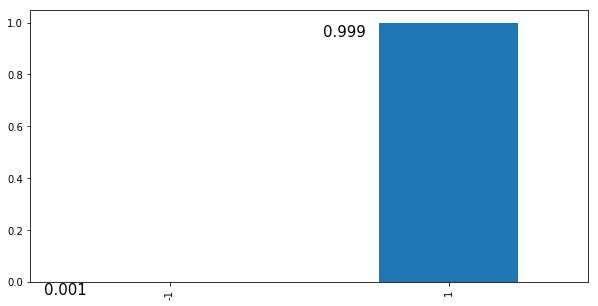

In [60]:
plot_hist_perc(modified_gold)
savefig('figures/gold_outliers.eps')

In [61]:
gold_out = []

for v in pca_gold:
    [p] = out_gold.predict([v])
    if p != 1:
        gold_out.append(v)

In [62]:
gold_out_orig = []

for index, row in gold_train.iterrows():
    [nv] = pca_transform(gold_train.loc[[index]], gold_pca)
    check = [1 for v in gold_out if np.allclose(v, nv)]
    if check:
        print(index)
        gold_out_orig.append(v)

2017-11-14 00:00:00
2017-10-17 00:00:00


outliers: 29
inliers: 1901


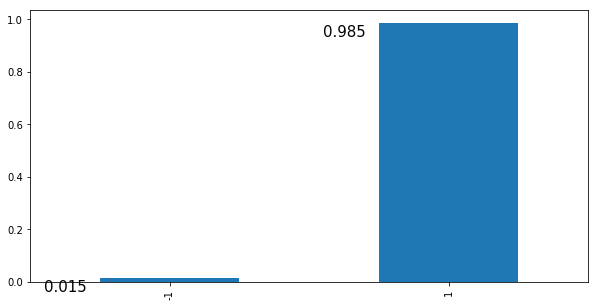

In [63]:
plot_hist_perc(modified_corn)
savefig('figures/corn_outliers.eps')

In [64]:
corn_out = []

for v in pca_corn:
    [p] = out_corn.predict([v])
    if p != 1:
        corn_out.append(v)
        
corn_out_orig = []

for index, row in corn_train.iterrows():
    [nv] = pca_transform(corn_train.loc[[index]], corn_pca)
    check = [1 for v in corn_out if np.allclose(v, nv)]
    if check:
        print(index)
        corn_out_orig.append(v)

2016-02-25 00:00:00
2017-07-03 00:00:00
2017-08-29 00:00:00
2017-10-23 00:00:00
2017-09-08 00:00:00
2017-07-25 00:00:00
2017-06-21 00:00:00
2017-08-28 00:00:00
2016-11-07 00:00:00
2017-10-20 00:00:00
2017-09-01 00:00:00
2017-09-06 00:00:00
2017-09-20 00:00:00
2016-11-29 00:00:00
2017-06-09 00:00:00
2017-10-30 00:00:00
2017-09-22 00:00:00
2016-07-01 00:00:00
2017-10-03 00:00:00
2017-12-27 00:00:00
2017-07-20 00:00:00
2017-09-29 00:00:00
2017-02-28 00:00:00
2017-11-20 00:00:00
2017-06-16 00:00:00
2017-10-06 00:00:00
2016-12-20 00:00:00
2017-09-18 00:00:00
2017-12-12 00:00:00


Coffee data contains unusually big number of outliers - maybe this could be modified by increasing number of PCA components.

outliers: 350
inliers: 1573


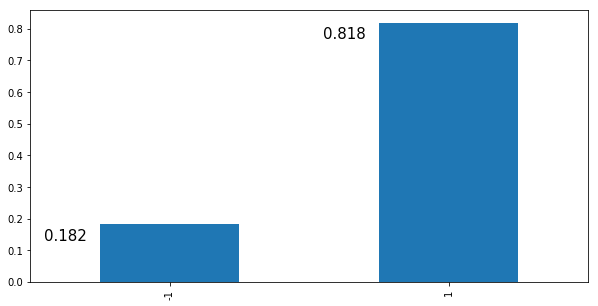

In [65]:
plot_hist_perc(modified_coffee)
savefig('figures/coffee_outliers.eps')

In [66]:
coffee_out = []

for v in pca_coffee:
    [p] = out_coffee.predict([v])
    if p != 1:
        coffee_out.append(v)
        
coffee_out_orig = []

for index, row in coffee_train.iterrows():
    [nv] = pca_transform(coffee_train.loc[[index]], coffee_pca)
    check = [1 for v in coffee_out if np.allclose(v, nv)]
    if check:
        print(index)
        coffee_out_orig.append(v)

2008-06-26 00:00:00
2010-01-07 00:00:00
2008-08-28 00:00:00
2008-07-02 00:00:00
2008-11-25 00:00:00
2008-12-04 00:00:00
2008-09-16 00:00:00
2010-01-28 00:00:00
2009-08-12 00:00:00
2010-01-08 00:00:00
2008-09-15 00:00:00
2009-09-02 00:00:00
2009-02-09 00:00:00
2009-05-29 00:00:00
2009-07-20 00:00:00
2009-09-18 00:00:00
2009-07-08 00:00:00
2009-02-11 00:00:00
2008-11-03 00:00:00
2009-03-10 00:00:00
2009-12-10 00:00:00
2009-02-02 00:00:00
2008-08-29 00:00:00
2009-02-20 00:00:00
2008-12-01 00:00:00
2008-12-24 00:00:00
2009-08-17 00:00:00
2009-06-25 00:00:00
2009-08-21 00:00:00
2010-03-02 00:00:00
2008-07-18 00:00:00
2009-08-19 00:00:00
2009-11-30 00:00:00
2008-12-19 00:00:00
2009-11-13 00:00:00
2009-09-08 00:00:00
2009-12-14 00:00:00
2009-06-18 00:00:00
2009-04-17 00:00:00
2009-10-23 00:00:00
2009-02-06 00:00:00
2009-11-03 00:00:00
2009-01-21 00:00:00
2009-05-28 00:00:00
2009-05-11 00:00:00
2008-12-30 00:00:00
2009-01-28 00:00:00
2008-10-20 00:00:00
2009-06-30 00:00:00
2009-01-07 00:00:00


In [67]:
def create_pca_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_long_validation.csv', index=False)
    train_df.to_csv(name + '_long_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_long_test.csv', index=False)

    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_short_validation.csv', index=False)
    train_df.to_csv(name + '_short_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_short_test.csv', index=False)


def create_pca_reg_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = df.loc[df.index < '2018-1-1'][2544].values
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_validation.csv', index=False)
    train_df.to_csv(name + '_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = df.loc[df.index >= '2018-1-1'][2544].values
    gdf_test.to_csv(name + '_test.csv', index=False)


create_pca_training(gold_data, gold_pca, 'data/gold_pca')
create_pca_training(corn_data, corn_pca, 'data/corn_pca')
create_pca_training(coffee_data, coffee_pca, 'data/coffee_pca')

create_pca_reg_training(gold_data_reg, gold_pca, 'data/gold_pca_reg')
create_pca_reg_training(corn_data_reg, corn_pca, 'data/corn_pca_reg')
create_pca_reg_training(coffee_data_reg, coffee_pca, 'data/coffee_pca_reg')

### Dimension reduction with PCA

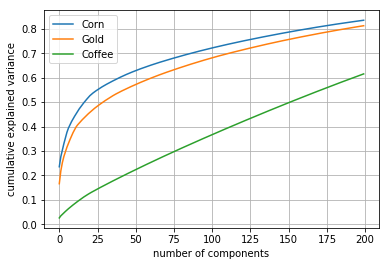

In [137]:
plt.plot(np.cumsum(corn_pca.explained_variance_ratio_), label='Corn')
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_), label='Gold')
plt.plot(np.cumsum(coffee_pca.explained_variance_ratio_), label='Coffee')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.legend()
# plt.show()
plt.savefig('figures/pca.eps')

It is interesting Corn is best explained by PCA transformation. It is probably due to clear seasonal patterns in trading.

I am surprised that gold is better explained by PCA transformation than Coffee. I would expect that coffee has stronger seasonal trading patterns than gold because of the growth cycle. Maybe gold mining is subject to the weather in similar way as agricultural commodities. Gold is still mostly recycled and new production has limited impact on total amount of traded gold.

Possible explanations:
- corn traded on CME is mostly US produced with stable harvest season
- production of coffee is very unpredictable depending on the conditions of a given year
- there are multiple producers around the world (coffee is more of a global market with limited US production) with different harvest periods https://driftaway.coffee/when-is-coffee-harvested/
- important difference between coffee and corn is price per unit corn is much less efficient to transport
    - 1 kg of corn is worth about 15¢
    - 1 kg of coffee is worth about 230¢
    
Based on this graph I think that PCA transformation is not suitable for coffee. Information in components is growing linearly. If we don't see sharp increase of cumulative explained variance with few first components, then PCA transformation is not suitable. Therefore, coffee should not be considered for trading. I will continue with coffee as well but based on this transformation I would not go ahead with trading unless I would find different transformation.

In [69]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [70]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-13,572.0,581.0,567.8,580.5,39962.0,577.0,591.5,573.5,591.0,43918.0,...,0.584221,-0.951057,0.309017,0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-16,577.0,591.5,573.5,591.0,43918.0,588.0,593.5,584.5,585.4,42916.0,...,0.584221,0.000000,1.000000,0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-17,588.0,593.5,584.5,585.4,42916.0,574.5,589.0,574.5,588.0,33705.0,...,0.584221,0.951057,0.309017,-0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-18,574.5,589.0,574.5,588.0,33705.0,586.2,589.5,580.0,587.7,30510.0,...,0.604415,0.587785,-0.809017,-0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-19,586.2,589.5,580.0,587.7,30510.0,589.5,599.0,583.7,584.4,47778.0,...,0.604415,-0.587785,-0.809017,-0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0


In [71]:
import os
import platform

print(platform.platform())

if platform.system() == 'Darwin':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Linux-4.18.0-14-generic-x86_64-with-Ubuntu-18.10-cosmic


In [72]:
def get_round_ceiling(sr):
    return (np.ceil(sr.max()+1000)//1000+1)*1000

In [73]:
from numpy import size
from sklearn.metrics import confusion_matrix


def print_2d(f):
    return format(f, '.2f')


def earnings_per_trade(df):
    ans = 0
    if df[df.trade != 0].trade.count() != 0:
        ans = (df[df.trade != 0].gains.sum())/(df[df.trade != 0].trade.count())
    return ans


def earnings_per_shorts(df):
    ans = 0
    if df[df.trade == -1].trade.count() != 0:
        ans = (df[df.trade == -1].gains.sum())/(df[df.trade == -1].trade.count())
    return ans


def earnings_per_longs(df):
    ans = 0
    if df[df.trade == 1].trade.count() != 0:
        ans = (df[df.trade == 1].gains.sum())/(df[df.trade == 1].trade.count())
    return ans


def get_performance(model, pca, df_gains, df, labels, regression=False, target=200, stop_loss_long=1000, stop_loss_short=800, debug=False):
    df = pca_transform(df, pca)
    preds = model.predict(df)
    if regression and not np.isscalar(preds[0]):
        preds = np.reshape(preds, (preds.shape[0],))
    l = preds.shape[0]
    if regression:
        ax = sns.distplot(preds - df_gains.gains.values[:l], hist = False, kde = True,
                          kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
        title = ax.set_title('Kernel density of residuals', size=15)
        fig1, ax1 = plt.subplots()
        ax1 = sns.scatterplot(x=preds, y=df_gains.gains.values[:l])
        ax1.set_xlabel('Predictions')
        ax1.set_ylabel('Actuals')
        title = ax1.set_title('Actual vs Prediction scatter plot', size=15)
        print("Predictions/Actual volatility correlation: ", np.corrcoef(preds, df_gains.gains.values[:l])[0][1])
    # print("Predictions/Actual volatility correlation for : ", np.corrcoef(preds, df_gains.gains.values[:l][0][1]))
    if debug:
        print(preds)
    predictions = []
    for v in preds:
        if not regression:
            i = pd.Series(v).idxmax()
            if i == 0:
                predictions.append(0)
            elif i == 1:
                predictions.append(-1)
            else:
                predictions.append(1)
        else:
            if abs(v) > target:
                if v > 0:
                    predictions.append(1)
                else:
                    predictions.append(-1)
            else:
                predictions.append(0)
    return get_account(predictions, df_gains, labels, stop_loss_long, stop_loss_short, True)


def get_account(predictions, df_gains, labels, stop_loss_long=1000, stop_loss_short=800, regression=False):
    global account_size, fee
    acc = account_size
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    dct['predicted_value'] = [0]
    dct['true_value'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1.0:
            short = 1
            if (v[2] - v[1]) > stop_loss_short:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1.0:
            long = 1
            if (v[1] - v[3]) > stop_loss_long:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        else:
            pass
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(float(p))
        dct['label'].append(l)
        dct['gains'].append(gains)
        dct['predicted_value'].append(p)
        dct['true_value'].append(v[0])
        if acc <= 0:
            break
    rf = pd.DataFrame.from_dict(dct)
    rf['id'] = rf.index.values
    rf['trade_visual'] = rf.trade*1000
    ax1 = rf[['account']].plot(grid=True, figsize=(15, 5))
    rf.plot(ax=ax1, x='id', y='trade_visual', color='g', grid=True)
    ax1.set_ylim(-2000, get_round_ceiling(rf.account))
    print("Returns ", print_2d((rf.account.values[-1]/rf.account.values[0])*100-100), "%")
    print("Number of trades: ", rf[rf.trade != 0].trade.count())
    print("Number of short trades: ", rf[rf.trade == -1].trade.count())
    print("Number of long trades: ", rf[rf.trade == 1].trade.count())
    print("Earnings per trade: ", print_2d(earnings_per_trade(rf)))
    print("Earnings per short trade: ", print_2d(earnings_per_shorts(rf)))
    print("Earnings per long trade: ", print_2d(earnings_per_longs(rf)))
    if not regression:
        fig3, ax3 = plt.subplots()
        cm = confusion_matrix(rf['label'].astype(int), rf['trade'].astype(int))
        sns.heatmap(cm, annot=True, fmt="d", ax=ax3)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig4, ax4 = plt.subplots()
        sns.heatmap(cm, annot=True, fmt="f", ax=ax4)
    fig2, ax2 = plt.subplots()
    rf.trade.hist(ax=ax2)
    title = ax2.set_title('Histogram of trades -1 short, 0 no trade, 1 long', size=15)
    return rf

# General strategy for training
I tried the same model for all three commodities (gold, corn and coffee). I am looking for classifier with the same parameters for any commodity. This way I can be sure that I have found some general classification and good results are not just a coincidence.

Following exploration can be split into:
- classificator
- regressor

# LightGBM Regressor
I tried training lightGBM classifier to train on data with created labels.

- gold 57% gains
- corn 2% gains
- coffee 34% gains

In [74]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

# categoricals = [10, 11, 12, 13]
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
test_data = lgb.Dataset(X_test, label=y_test)

param = {}
param['num_leaves'] = 40
param['objective'] = 'regression'
param['boosting'] = 'dart'
# param['metric'] = 'binary_error'
# param['metric'] = 'ROC'
param['metric'] = 'l2'
param['estimators'] = 1000
param['learning_rate'] = 0.001
param['num_class'] = 1
param['max_bin'] = 30
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 1000

np.random.seed = 4567
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 1.62038e+06
[2]	valid_0's l2: 1.62037e+06
[3]	valid_0's l2: 1.62036e+06
[4]	valid_0's l2: 1.62035e+06
[5]	valid_0's l2: 1.62034e+06
[6]	valid_0's l2: 1.62033e+06
[7]	valid_0's l2: 1.62032e+06
[8]	valid_0's l2: 1.62033e+06
[9]	valid_0's l2: 1.62032e+06
[10]	valid_0's l2: 1.62031e+06
[11]	valid_0's l2: 1.6203e+06
[12]	valid_0's l2: 1.6203e+06
[13]	valid_0's l2: 1.62029e+06
[14]	valid_0's l2: 1.62029e+06
[15]	valid_0's l2: 1.62028e+06
[16]	valid_0's l2: 1.62027e+06
[17]	valid_0's l2: 1.62026e+06
[18]	valid_0's l2: 1.62024e+06
[19]	valid_0's l2: 1.62024e+06
[20]	valid_0's l2: 1.62022e+06
[21]	valid_0's l2: 1.62022e+06
[22]	valid_0's l2: 1.6202e+06
[23]	valid_0's l2: 1.6202e+06
[24]	valid_0's l2: 1.62018e+06
[25]	valid_0's l2: 1.62017e+06
[26]	valid_0's l2: 1.62015e+06
[27]	valid_0's l2: 1.62015e+06
[28]	valid_0's l2: 1.62015e+06
[29]	valid_0's l2: 1.62014e+06
[30]	valid_0's l2: 1.62014e+06
[31]	valid_0's l2: 1.62014e+06
[32]	valid_0's l2: 1.62012e+06
[33]	valid_0's l2: 1.

[269]	valid_0's l2: 1.62183e+06
[270]	valid_0's l2: 1.62185e+06
[271]	valid_0's l2: 1.62183e+06
[272]	valid_0's l2: 1.62189e+06
[273]	valid_0's l2: 1.62195e+06
[274]	valid_0's l2: 1.62192e+06
[275]	valid_0's l2: 1.62197e+06
[276]	valid_0's l2: 1.62195e+06
[277]	valid_0's l2: 1.62199e+06
[278]	valid_0's l2: 1.62197e+06
[279]	valid_0's l2: 1.62203e+06
[280]	valid_0's l2: 1.62201e+06
[281]	valid_0's l2: 1.62199e+06
[282]	valid_0's l2: 1.62199e+06
[283]	valid_0's l2: 1.62197e+06
[284]	valid_0's l2: 1.62201e+06
[285]	valid_0's l2: 1.62205e+06
[286]	valid_0's l2: 1.6221e+06
[287]	valid_0's l2: 1.62216e+06
[288]	valid_0's l2: 1.62214e+06
[289]	valid_0's l2: 1.62218e+06
[290]	valid_0's l2: 1.62223e+06
[291]	valid_0's l2: 1.62227e+06
[292]	valid_0's l2: 1.62225e+06
[293]	valid_0's l2: 1.62222e+06
[294]	valid_0's l2: 1.62222e+06
[295]	valid_0's l2: 1.62219e+06
[296]	valid_0's l2: 1.62217e+06
[297]	valid_0's l2: 1.62221e+06
[298]	valid_0's l2: 1.62219e+06
[299]	valid_0's l2: 1.62223e+06
[300]	val

[557]	valid_0's l2: 1.62555e+06
[558]	valid_0's l2: 1.62559e+06
[559]	valid_0's l2: 1.62566e+06
[560]	valid_0's l2: 1.62572e+06
[561]	valid_0's l2: 1.6257e+06
[562]	valid_0's l2: 1.62567e+06
[563]	valid_0's l2: 1.62564e+06
[564]	valid_0's l2: 1.62561e+06
[565]	valid_0's l2: 1.62565e+06
[566]	valid_0's l2: 1.62568e+06
[567]	valid_0's l2: 1.62573e+06
[568]	valid_0's l2: 1.62571e+06
[569]	valid_0's l2: 1.62568e+06
[570]	valid_0's l2: 1.62565e+06
[571]	valid_0's l2: 1.6257e+06
[572]	valid_0's l2: 1.62577e+06
[573]	valid_0's l2: 1.62575e+06
[574]	valid_0's l2: 1.62572e+06
[575]	valid_0's l2: 1.62575e+06
[576]	valid_0's l2: 1.62572e+06
[577]	valid_0's l2: 1.62569e+06
[578]	valid_0's l2: 1.62566e+06
[579]	valid_0's l2: 1.62564e+06
[580]	valid_0's l2: 1.62561e+06
[581]	valid_0's l2: 1.62561e+06
[582]	valid_0's l2: 1.62559e+06
[583]	valid_0's l2: 1.62565e+06
[584]	valid_0's l2: 1.62562e+06
[585]	valid_0's l2: 1.62565e+06
[586]	valid_0's l2: 1.62563e+06
[587]	valid_0's l2: 1.62569e+06
[588]	vali

[846]	valid_0's l2: 1.62901e+06
[847]	valid_0's l2: 1.62907e+06
[848]	valid_0's l2: 1.62904e+06
[849]	valid_0's l2: 1.62902e+06
[850]	valid_0's l2: 1.62909e+06
[851]	valid_0's l2: 1.62906e+06
[852]	valid_0's l2: 1.62916e+06
[853]	valid_0's l2: 1.62914e+06
[854]	valid_0's l2: 1.62912e+06
[855]	valid_0's l2: 1.6292e+06
[856]	valid_0's l2: 1.62924e+06
[857]	valid_0's l2: 1.62922e+06
[858]	valid_0's l2: 1.62919e+06
[859]	valid_0's l2: 1.62917e+06
[860]	valid_0's l2: 1.62921e+06
[861]	valid_0's l2: 1.62926e+06
[862]	valid_0's l2: 1.62934e+06
[863]	valid_0's l2: 1.62932e+06
[864]	valid_0's l2: 1.62929e+06
[865]	valid_0's l2: 1.62933e+06
[866]	valid_0's l2: 1.62939e+06
[867]	valid_0's l2: 1.62945e+06
[868]	valid_0's l2: 1.62942e+06
[869]	valid_0's l2: 1.62944e+06
[870]	valid_0's l2: 1.62941e+06
[871]	valid_0's l2: 1.62939e+06
[872]	valid_0's l2: 1.62939e+06
[873]	valid_0's l2: 1.62936e+06
[874]	valid_0's l2: 1.62934e+06
[875]	valid_0's l2: 1.62931e+06
[876]	valid_0's l2: 1.62934e+06
[877]	val

Predictions/Actual volatility correlation:  0.09617259288031146
Returns  57.29 %
Number of trades:  45
Number of short trades:  27
Number of long trades:  18
Earnings per trade:  127.31
Earnings per short trade:  208.85
Earnings per long trade:  5.00


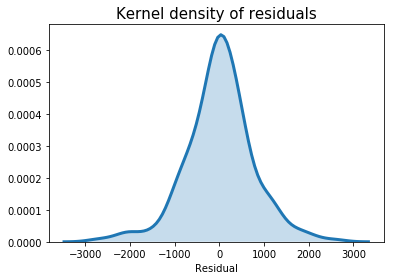

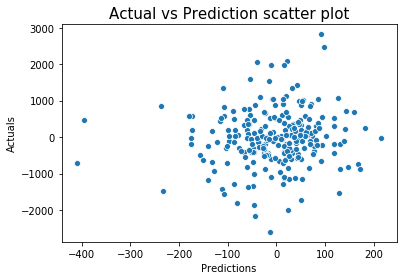

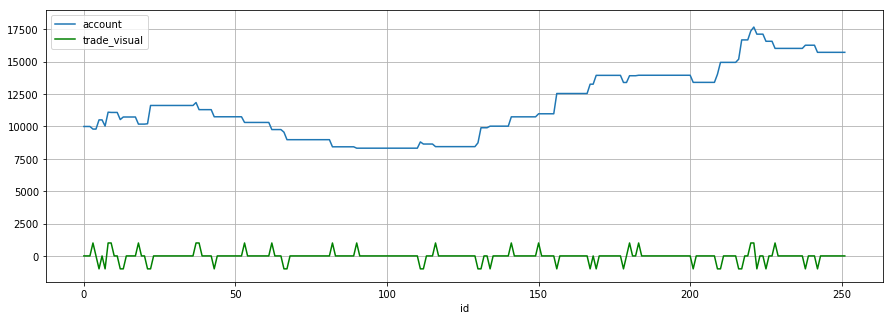

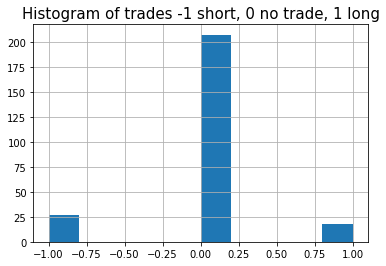

In [75]:
gold_account = get_performance(gold_clf, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=100)

In [76]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
test_data = lgb.Dataset(X_test, label=y_test)

corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 175904
[2]	valid_0's l2: 175905
[3]	valid_0's l2: 175907
[4]	valid_0's l2: 175908
[5]	valid_0's l2: 175900
[6]	valid_0's l2: 175902
[7]	valid_0's l2: 175894
[8]	valid_0's l2: 175893
[9]	valid_0's l2: 175895
[10]	valid_0's l2: 175887
[11]	valid_0's l2: 175889
[12]	valid_0's l2: 175888
[13]	valid_0's l2: 175881
[14]	valid_0's l2: 175883
[15]	valid_0's l2: 175876
[16]	valid_0's l2: 175877
[17]	valid_0's l2: 175870
[18]	valid_0's l2: 175872
[19]	valid_0's l2: 175866
[20]	valid_0's l2: 175869
[21]	valid_0's l2: 175867
[22]	valid_0's l2: 175860
[23]	valid_0's l2: 175863
[24]	valid_0's l2: 175856
[25]	valid_0's l2: 175859
[26]	valid_0's l2: 175853
[27]	valid_0's l2: 175855
[28]	valid_0's l2: 175855
[29]	valid_0's l2: 175850
[30]	valid_0's l2: 175852
[31]	valid_0's l2: 175852
[32]	valid_0's l2: 175847
[33]	valid_0's l2: 175849
[34]	valid_0's l2: 175849
[35]	valid_0's l2: 175850
[36]	valid_0's l2: 175850
[37]	valid_0's l2: 175852
[38]	valid_0's l2: 175849
[39]	valid_0's l2: 17

[328]	valid_0's l2: 175837
[329]	valid_0's l2: 175840
[330]	valid_0's l2: 175839
[331]	valid_0's l2: 175838
[332]	valid_0's l2: 175837
[333]	valid_0's l2: 175836
[334]	valid_0's l2: 175835
[335]	valid_0's l2: 175840
[336]	valid_0's l2: 175839
[337]	valid_0's l2: 175836
[338]	valid_0's l2: 175834
[339]	valid_0's l2: 175834
[340]	valid_0's l2: 175833
[341]	valid_0's l2: 175831
[342]	valid_0's l2: 175825
[343]	valid_0's l2: 175821
[344]	valid_0's l2: 175821
[345]	valid_0's l2: 175829
[346]	valid_0's l2: 175833
[347]	valid_0's l2: 175833
[348]	valid_0's l2: 175843
[349]	valid_0's l2: 175841
[350]	valid_0's l2: 175840
[351]	valid_0's l2: 175838
[352]	valid_0's l2: 175832
[353]	valid_0's l2: 175834
[354]	valid_0's l2: 175834
[355]	valid_0's l2: 175834
[356]	valid_0's l2: 175831
[357]	valid_0's l2: 175831
[358]	valid_0's l2: 175828
[359]	valid_0's l2: 175827
[360]	valid_0's l2: 175829
[361]	valid_0's l2: 175829
[362]	valid_0's l2: 175826
[363]	valid_0's l2: 175826
[364]	valid_0's l2: 175825
[

[659]	valid_0's l2: 175896
[660]	valid_0's l2: 175901
[661]	valid_0's l2: 175900
[662]	valid_0's l2: 175902
[663]	valid_0's l2: 175901
[664]	valid_0's l2: 175900
[665]	valid_0's l2: 175899
[666]	valid_0's l2: 175899
[667]	valid_0's l2: 175898
[668]	valid_0's l2: 175897
[669]	valid_0's l2: 175900
[670]	valid_0's l2: 175904
[671]	valid_0's l2: 175903
[672]	valid_0's l2: 175907
[673]	valid_0's l2: 175906
[674]	valid_0's l2: 175907
[675]	valid_0's l2: 175911
[676]	valid_0's l2: 175916
[677]	valid_0's l2: 175919
[678]	valid_0's l2: 175918
[679]	valid_0's l2: 175923
[680]	valid_0's l2: 175926
[681]	valid_0's l2: 175925
[682]	valid_0's l2: 175924
[683]	valid_0's l2: 175929
[684]	valid_0's l2: 175928
[685]	valid_0's l2: 175927
[686]	valid_0's l2: 175915
[687]	valid_0's l2: 175914
[688]	valid_0's l2: 175913
[689]	valid_0's l2: 175916
[690]	valid_0's l2: 175913
[691]	valid_0's l2: 175912
[692]	valid_0's l2: 175912
[693]	valid_0's l2: 175909
[694]	valid_0's l2: 175912
[695]	valid_0's l2: 175911
[

[983]	valid_0's l2: 175875
[984]	valid_0's l2: 175866
[985]	valid_0's l2: 175864
[986]	valid_0's l2: 175864
[987]	valid_0's l2: 175862
[988]	valid_0's l2: 175861
[989]	valid_0's l2: 175860
[990]	valid_0's l2: 175859
[991]	valid_0's l2: 175867
[992]	valid_0's l2: 175869
[993]	valid_0's l2: 175868
[994]	valid_0's l2: 175878
[995]	valid_0's l2: 175877
[996]	valid_0's l2: 175885
[997]	valid_0's l2: 175889
[998]	valid_0's l2: 175888
[999]	valid_0's l2: 175879
[1000]	valid_0's l2: 175878


Predictions/Actual volatility correlation:  0.030004906267008552
Returns  2.48 %
Number of trades:  36
Number of short trades:  14
Number of long trades:  22
Earnings per trade:  6.89
Earnings per short trade:  43.29
Earnings per long trade:  -16.28


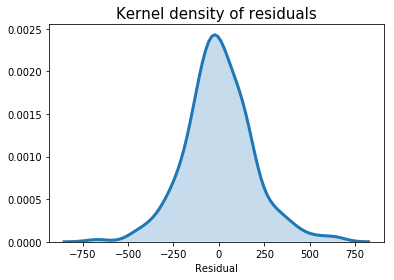

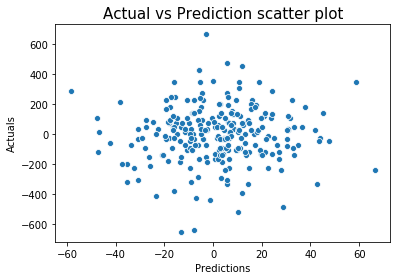

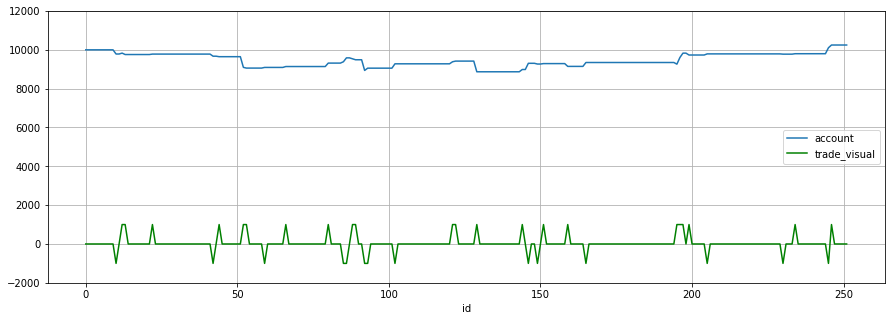

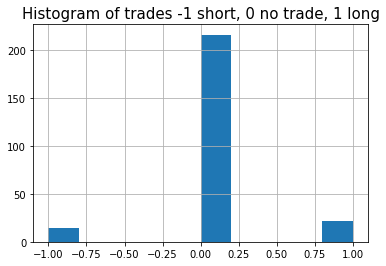

In [77]:
corn_account_lgb = get_performance(corn_clf, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=30)

In [78]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train.values
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test.values
test_data = lgb.Dataset(X_test, label=y_test)

coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 161691
[2]	valid_0's l2: 161691
[3]	valid_0's l2: 161691
[4]	valid_0's l2: 161692
[5]	valid_0's l2: 161693
[6]	valid_0's l2: 161693
[7]	valid_0's l2: 161695
[8]	valid_0's l2: 161695
[9]	valid_0's l2: 161695
[10]	valid_0's l2: 161697
[11]	valid_0's l2: 161701
[12]	valid_0's l2: 161700
[13]	valid_0's l2: 161701
[14]	valid_0's l2: 161704
[15]	valid_0's l2: 161706
[16]	valid_0's l2: 161709
[17]	valid_0's l2: 161700
[18]	valid_0's l2: 161704
[19]	valid_0's l2: 161695
[20]	valid_0's l2: 161699
[21]	valid_0's l2: 161698
[22]	valid_0's l2: 161690
[23]	valid_0's l2: 161694
[24]	valid_0's l2: 161685
[25]	valid_0's l2: 161690
[26]	valid_0's l2: 161692
[27]	valid_0's l2: 161686
[28]	valid_0's l2: 161684
[29]	valid_0's l2: 161685
[30]	valid_0's l2: 161679
[31]	valid_0's l2: 161679
[32]	valid_0's l2: 161685
[33]	valid_0's l2: 161683
[34]	valid_0's l2: 161683
[35]	valid_0's l2: 161683
[36]	valid_0's l2: 161684
[37]	valid_0's l2: 161690
[38]	valid_0's l2: 161688
[39]	valid_0's l2: 16

[312]	valid_0's l2: 161441
[313]	valid_0's l2: 161432
[314]	valid_0's l2: 161434
[315]	valid_0's l2: 161434
[316]	valid_0's l2: 161430
[317]	valid_0's l2: 161422
[318]	valid_0's l2: 161428
[319]	valid_0's l2: 161430
[320]	valid_0's l2: 161421
[321]	valid_0's l2: 161423
[322]	valid_0's l2: 161415
[323]	valid_0's l2: 161413
[324]	valid_0's l2: 161414
[325]	valid_0's l2: 161416
[326]	valid_0's l2: 161417
[327]	valid_0's l2: 161421
[328]	valid_0's l2: 161423
[329]	valid_0's l2: 161415
[330]	valid_0's l2: 161417
[331]	valid_0's l2: 161419
[332]	valid_0's l2: 161420
[333]	valid_0's l2: 161421
[334]	valid_0's l2: 161423
[335]	valid_0's l2: 161427
[336]	valid_0's l2: 161428
[337]	valid_0's l2: 161425
[338]	valid_0's l2: 161429
[339]	valid_0's l2: 161429
[340]	valid_0's l2: 161430
[341]	valid_0's l2: 161437
[342]	valid_0's l2: 161428
[343]	valid_0's l2: 161432
[344]	valid_0's l2: 161433
[345]	valid_0's l2: 161425
[346]	valid_0's l2: 161423
[347]	valid_0's l2: 161424
[348]	valid_0's l2: 161430
[

[629]	valid_0's l2: 161713
[630]	valid_0's l2: 161713
[631]	valid_0's l2: 161712
[632]	valid_0's l2: 161723
[633]	valid_0's l2: 161723
[634]	valid_0's l2: 161722
[635]	valid_0's l2: 161728
[636]	valid_0's l2: 161727
[637]	valid_0's l2: 161734
[638]	valid_0's l2: 161733
[639]	valid_0's l2: 161732
[640]	valid_0's l2: 161733
[641]	valid_0's l2: 161732
[642]	valid_0's l2: 161732
[643]	valid_0's l2: 161739
[644]	valid_0's l2: 161738
[645]	valid_0's l2: 161747
[646]	valid_0's l2: 161747
[647]	valid_0's l2: 161757
[648]	valid_0's l2: 161754
[649]	valid_0's l2: 161753
[650]	valid_0's l2: 161753
[651]	valid_0's l2: 161760
[652]	valid_0's l2: 161760
[653]	valid_0's l2: 161759
[654]	valid_0's l2: 161759
[655]	valid_0's l2: 161770
[656]	valid_0's l2: 161769
[657]	valid_0's l2: 161769
[658]	valid_0's l2: 161765
[659]	valid_0's l2: 161764
[660]	valid_0's l2: 161775
[661]	valid_0's l2: 161774
[662]	valid_0's l2: 161780
[663]	valid_0's l2: 161780
[664]	valid_0's l2: 161779
[665]	valid_0's l2: 161779
[

[941]	valid_0's l2: 162138
[942]	valid_0's l2: 162138
[943]	valid_0's l2: 162137
[944]	valid_0's l2: 162139
[945]	valid_0's l2: 162137
[946]	valid_0's l2: 162137
[947]	valid_0's l2: 162143
[948]	valid_0's l2: 162141
[949]	valid_0's l2: 162149
[950]	valid_0's l2: 162150
[951]	valid_0's l2: 162162
[952]	valid_0's l2: 162161
[953]	valid_0's l2: 162160
[954]	valid_0's l2: 162159
[955]	valid_0's l2: 162153
[956]	valid_0's l2: 162155
[957]	valid_0's l2: 162153
[958]	valid_0's l2: 162152
[959]	valid_0's l2: 162153
[960]	valid_0's l2: 162165
[961]	valid_0's l2: 162167
[962]	valid_0's l2: 162165
[963]	valid_0's l2: 162180
[964]	valid_0's l2: 162179
[965]	valid_0's l2: 162181
[966]	valid_0's l2: 162179
[967]	valid_0's l2: 162179
[968]	valid_0's l2: 162178
[969]	valid_0's l2: 162177
[970]	valid_0's l2: 162176
[971]	valid_0's l2: 162186
[972]	valid_0's l2: 162188
[973]	valid_0's l2: 162186
[974]	valid_0's l2: 162185
[975]	valid_0's l2: 162184
[976]	valid_0's l2: 162181
[977]	valid_0's l2: 162180
[

Predictions/Actual volatility correlation:  -0.03164539084652848
Returns  34.10 %
Number of trades:  45
Number of short trades:  30
Number of long trades:  15
Earnings per trade:  75.78
Earnings per short trade:  158.71
Earnings per long trade:  -90.07


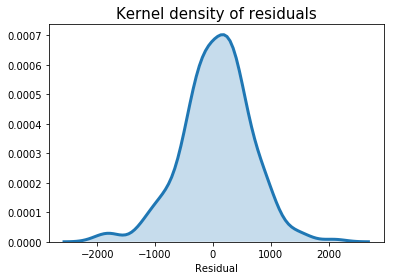

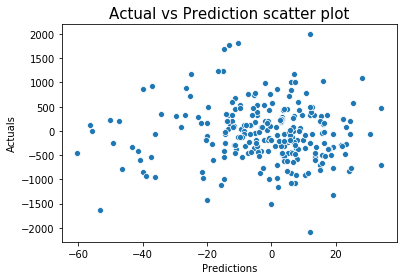

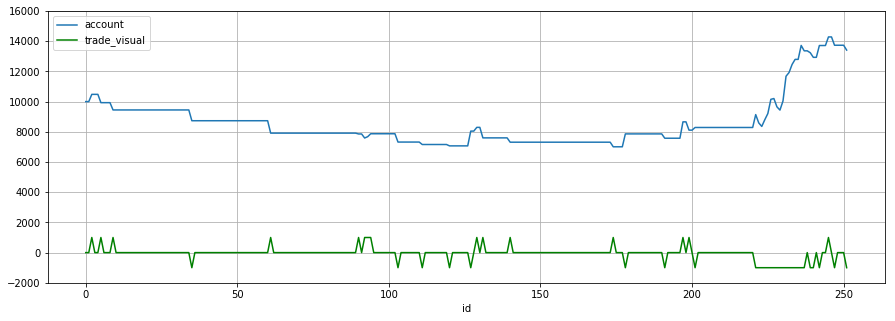

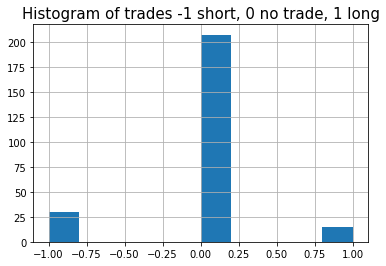

In [79]:
coffee_account_lgb = get_performance(coffee_clf, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=20)

# Neural Networks classifier
---


| commodity | gains % | earnings per trade | number of trades |
|-----------|---------|--------------------|------------------|
| gold      | 125     | 73.17              | 172              |
| corn      | 7       | 5.2                | 141              |
| coffee   | -100    | -90.6              | 111              |

In [80]:
def create_target(x):
    if x == 1.0:
        return [0,0,1]
    elif x == 0.0:
        return [1,0,0]
    else:
        return [0,1,0]

In [81]:
X = pca_transform(gold_train, gold_pca)
y = gold_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_test, gold_pca)
y_test = gold_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

In [82]:
# %%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.metrics import categorical_accuracy, binary_accuracy, sparse_categorical_accuracy
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import RMSprop

input_shape = 200
num_classes = 3

def define_model(input_shape, num_classes):
    # Define a model
    opt = RMSprop(lr=0.0001)
    
    model = Sequential()  
    model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('tanh'))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# opt = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
# opt = Nadam(lr=0.002)
batch_size = 20
epochs = 200
model = define_model(input_shape, num_classes)

Using TensorFlow backend.


In [83]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

In [84]:
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()

Train on 1931 samples, validate on 484 samples
Epoch 1/200
1931/1931 [==============================] - 1s 511us/step - loss: 76760943836.0725 - acc: 0.3413 - val_loss: 71470994846.6777 - val_acc: 0.3223

Epoch 00001: val_loss improved from inf to 71470994846.67769, saving model to saved_models/weights.gold.hdf5
Epoch 2/200
1931/1931 [==============================] - 0s 108us/step - loss: 70184340884.6152 - acc: 0.3387 - val_loss: 65204653318.3471 - val_acc: 0.3264

Epoch 00002: val_loss improved from 71470994846.67769 to 65204653318.34711, saving model to saved_models/weights.gold.hdf5
Epoch 3/200
1931/1931 [==============================] - 0s 103us/step - loss: 63984212238.4505 - acc: 0.3387 - val_loss: 59349199372.6942 - val_acc: 0.3347

Epoch 00003: val_loss improved from 65204653318.34711 to 59349199372.69421, saving model to saved_models/weights.gold.hdf5
Epoch 4/200
1931/1931 [==============================] - 0s 119us/step - loss: 58176875704.0124 - acc: 0.3309 - val_loss: 53

1931/1931 [==============================] - 0s 100us/step - loss: 2197674124.5282 - acc: 0.3143 - val_loss: 1883298254.8099 - val_acc: 0.3430

Epoch 00030: val_loss improved from 2328679483.76860 to 1883298254.80992, saving model to saved_models/weights.gold.hdf5
Epoch 31/200
1931/1931 [==============================] - 0s 105us/step - loss: 1767648571.6914 - acc: 0.3439 - val_loss: 1495009413.8182 - val_acc: 0.3471

Epoch 00031: val_loss improved from 1883298254.80992 to 1495009413.81818, saving model to saved_models/weights.gold.hdf5
Epoch 32/200
1931/1931 [==============================] - 0s 91us/step - loss: 1388087731.3061 - acc: 0.3330 - val_loss: 1157095172.7603 - val_acc: 0.3512

Epoch 00032: val_loss improved from 1495009413.81818 to 1157095172.76033, saving model to saved_models/weights.gold.hdf5
Epoch 33/200
1931/1931 [==============================] - 0s 97us/step - loss: 1061326564.4909 - acc: 0.3439 - val_loss: 869448346.7107 - val_acc: 0.3492

Epoch 00033: val_loss imp


Epoch 00063: val_loss did not improve from 163376.61557
Epoch 64/200
1931/1931 [==============================] - 0s 98us/step - loss: 179548.7527 - acc: 0.3501 - val_loss: 190571.6866 - val_acc: 0.3368

Epoch 00064: val_loss did not improve from 163376.61557
Epoch 65/200
1931/1931 [==============================] - 0s 99us/step - loss: 182362.1189 - acc: 0.3413 - val_loss: 193079.2621 - val_acc: 0.3719

Epoch 00065: val_loss did not improve from 163376.61557
Epoch 66/200
1931/1931 [==============================] - 0s 100us/step - loss: 181950.8228 - acc: 0.3439 - val_loss: 204280.5019 - val_acc: 0.3264

Epoch 00066: val_loss did not improve from 163376.61557
Epoch 67/200
1931/1931 [==============================] - 0s 97us/step - loss: 184018.8557 - acc: 0.3268 - val_loss: 155713.3073 - val_acc: 0.3430

Epoch 00067: val_loss improved from 163376.61557 to 155713.30729, saving model to saved_models/weights.gold.hdf5
Epoch 68/200
1931/1931 [==============================] - 0s 105us/st

1931/1931 [==============================] - 0s 96us/step - loss: 184716.0861 - acc: 0.3646 - val_loss: 191698.6639 - val_acc: 0.3326

Epoch 00103: val_loss did not improve from 149389.12858
Epoch 104/200
1931/1931 [==============================] - 0s 98us/step - loss: 181087.5336 - acc: 0.3335 - val_loss: 158961.9879 - val_acc: 0.3512

Epoch 00104: val_loss did not improve from 149389.12858
Epoch 105/200
1931/1931 [==============================] - 0s 100us/step - loss: 182494.9815 - acc: 0.3278 - val_loss: 175688.3635 - val_acc: 0.3595

Epoch 00105: val_loss did not improve from 149389.12858
Epoch 106/200
1931/1931 [==============================] - 0s 96us/step - loss: 184962.4807 - acc: 0.3320 - val_loss: 173730.7278 - val_acc: 0.3099

Epoch 00106: val_loss did not improve from 149389.12858
Epoch 107/200
1931/1931 [==============================] - 0s 107us/step - loss: 182982.7765 - acc: 0.3356 - val_loss: 162416.0597 - val_acc: 0.4112

Epoch 00107: val_loss did not improve from 

1931/1931 [==============================] - 0s 95us/step - loss: 185475.2028 - acc: 0.3490 - val_loss: 173981.2227 - val_acc: 0.4050

Epoch 00143: val_loss did not improve from 149389.12858
Epoch 144/200
1931/1931 [==============================] - 0s 98us/step - loss: 182902.5242 - acc: 0.3547 - val_loss: 185881.8582 - val_acc: 0.4029

Epoch 00144: val_loss did not improve from 149389.12858
Epoch 145/200
1931/1931 [==============================] - 0s 101us/step - loss: 180938.8243 - acc: 0.3496 - val_loss: 206971.0731 - val_acc: 0.3636

Epoch 00145: val_loss did not improve from 149389.12858
Epoch 146/200
1931/1931 [==============================] - 0s 104us/step - loss: 185232.7679 - acc: 0.3371 - val_loss: 222164.5749 - val_acc: 0.3595

Epoch 00146: val_loss did not improve from 149389.12858
Epoch 147/200
1931/1931 [==============================] - 0s 104us/step - loss: 185518.2233 - acc: 0.3553 - val_loss: 162219.8593 - val_acc: 0.3822

Epoch 00147: val_loss did not improve from

1931/1931 [==============================] - 0s 97us/step - loss: 179620.5981 - acc: 0.3351 - val_loss: 170261.2691 - val_acc: 0.3678

Epoch 00183: val_loss did not improve from 149389.12858
Epoch 184/200
1931/1931 [==============================] - 0s 96us/step - loss: 185029.5974 - acc: 0.3288 - val_loss: 192351.5430 - val_acc: 0.3781

Epoch 00184: val_loss did not improve from 149389.12858
Epoch 185/200
1931/1931 [==============================] - 0s 98us/step - loss: 181582.1415 - acc: 0.3490 - val_loss: 157755.0931 - val_acc: 0.3657

Epoch 00185: val_loss did not improve from 149389.12858
Epoch 186/200
1931/1931 [==============================] - 0s 100us/step - loss: 182061.9921 - acc: 0.3397 - val_loss: 162229.3084 - val_acc: 0.3678

Epoch 00186: val_loss did not improve from 149389.12858
Epoch 187/200
1931/1931 [==============================] - 0s 105us/step - loss: 186241.0522 - acc: 0.3485 - val_loss: 190383.9078 - val_acc: 0.4360

Epoch 00187: val_loss did not improve from 

In [85]:
model.load_weights('saved_models/weights.gold.hdf5')
gold_clf_nn = model

Returns  83.48 %
Number of trades:  151
Number of short trades:  27
Number of long trades:  124
Earnings per trade:  55.29
Earnings per short trade:  -35.50
Earnings per long trade:  75.06


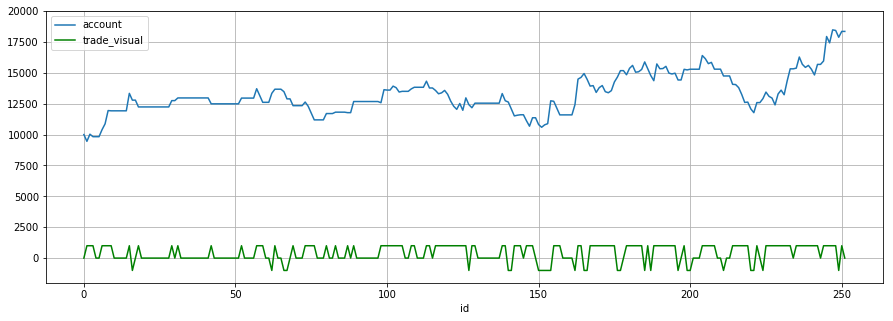

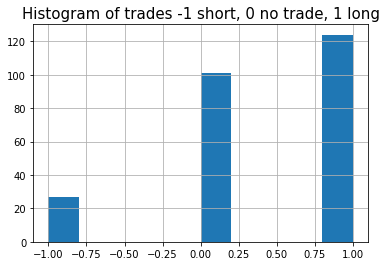

In [86]:
gold_account_nn = get_performance(gold_clf_nn, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [87]:
X = pca_transform(corn_train, corn_pca)
y = corn_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_test, corn_pca)
y_test = corn_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_nn = model

Train on 1930 samples, validate on 483 samples
Epoch 1/200
1930/1930 [==============================] - 1s 603us/step - loss: 69987752349.8446 - acc: 0.3456 - val_loss: 66370956049.4907 - val_acc: 0.3251

Epoch 00001: val_loss improved from inf to 66370956049.49068, saving model to saved_models/weights.corn.hdf5
Epoch 2/200
1930/1930 [==============================] - 0s 104us/step - loss: 63352340310.2176 - acc: 0.3378 - val_loss: 60062075601.8882 - val_acc: 0.3292

Epoch 00002: val_loss improved from 66370956049.49068 to 60062075601.88820, saving model to saved_models/weights.corn.hdf5
Epoch 3/200
1930/1930 [==============================] - 0s 99us/step - loss: 57205278168.2073 - acc: 0.3373 - val_loss: 54231992228.8364 - val_acc: 0.3292

Epoch 00003: val_loss improved from 60062075601.88820 to 54231992228.83644, saving model to saved_models/weights.corn.hdf5
Epoch 4/200
1930/1930 [==============================] - 0s 106us/step - loss: 51618887149.4301 - acc: 0.3337 - val_loss: 488

1930/1930 [==============================] - 0s 105us/step - loss: 1990803306.1140 - acc: 0.3223 - val_loss: 1764606202.9648 - val_acc: 0.3251

Epoch 00030: val_loss improved from 2141802150.82402 to 1764606202.96480, saving model to saved_models/weights.corn.hdf5
Epoch 31/200
1930/1930 [==============================] - 0s 110us/step - loss: 1630723248.4145 - acc: 0.3316 - val_loss: 1430616543.3043 - val_acc: 0.3271

Epoch 00031: val_loss improved from 1764606202.96480 to 1430616543.30435, saving model to saved_models/weights.corn.hdf5
Epoch 32/200
1930/1930 [==============================] - 0s 127us/step - loss: 1309656676.8083 - acc: 0.3446 - val_loss: 1134614864.4803 - val_acc: 0.3271

Epoch 00032: val_loss improved from 1430616543.30435 to 1134614864.48033, saving model to saved_models/weights.corn.hdf5
Epoch 33/200
1930/1930 [==============================] - 0s 103us/step - loss: 1031055903.5026 - acc: 0.3306 - val_loss: 878755402.3851 - val_acc: 0.3313

Epoch 00033: val_loss i

1930/1930 [==============================] - 0s 103us/step - loss: 152562.6955 - acc: 0.3404 - val_loss: 158355.4720 - val_acc: 0.3665

Epoch 00064: val_loss did not improve from 133542.05275
Epoch 65/200
1930/1930 [==============================] - 0s 100us/step - loss: 158145.9126 - acc: 0.3461 - val_loss: 159961.9597 - val_acc: 0.3271

Epoch 00065: val_loss did not improve from 133542.05275
Epoch 66/200
1930/1930 [==============================] - 0s 100us/step - loss: 157258.2437 - acc: 0.3404 - val_loss: 167012.4473 - val_acc: 0.3333

Epoch 00066: val_loss did not improve from 133542.05275
Epoch 67/200
1930/1930 [==============================] - 0s 98us/step - loss: 155520.9166 - acc: 0.3648 - val_loss: 145064.3783 - val_acc: 0.3168

Epoch 00067: val_loss did not improve from 133542.05275
Epoch 68/200
1930/1930 [==============================] - 0s 105us/step - loss: 155440.3000 - acc: 0.3699 - val_loss: 184059.0928 - val_acc: 0.3106

Epoch 00068: val_loss did not improve from 13

1930/1930 [==============================] - 0s 119us/step - loss: 153228.0572 - acc: 0.3399 - val_loss: 157308.2305 - val_acc: 0.3395

Epoch 00103: val_loss did not improve from 127812.27614
Epoch 104/200
1930/1930 [==============================] - 0s 109us/step - loss: 155550.0011 - acc: 0.3404 - val_loss: 157355.6715 - val_acc: 0.3147

Epoch 00104: val_loss did not improve from 127812.27614
Epoch 105/200
1930/1930 [==============================] - 0s 108us/step - loss: 156504.8022 - acc: 0.3358 - val_loss: 165535.0848 - val_acc: 0.3375

Epoch 00105: val_loss did not improve from 127812.27614
Epoch 106/200
1930/1930 [==============================] - 0s 117us/step - loss: 155821.5751 - acc: 0.3420 - val_loss: 160788.6358 - val_acc: 0.3727

Epoch 00106: val_loss did not improve from 127812.27614
Epoch 107/200
1930/1930 [==============================] - 0s 112us/step - loss: 160367.4152 - acc: 0.3440 - val_loss: 148059.7352 - val_acc: 0.3706

Epoch 00107: val_loss did not improve fr

1930/1930 [==============================] - 0s 140us/step - loss: 156299.8991 - acc: 0.3420 - val_loss: 158745.6833 - val_acc: 0.3313

Epoch 00142: val_loss did not improve from 118191.65850
Epoch 143/200
1930/1930 [==============================] - 0s 155us/step - loss: 155553.3044 - acc: 0.3554 - val_loss: 162777.1471 - val_acc: 0.3416

Epoch 00143: val_loss did not improve from 118191.65850
Epoch 144/200
1930/1930 [==============================] - 0s 149us/step - loss: 156540.3250 - acc: 0.3409 - val_loss: 144798.9260 - val_acc: 0.3251

Epoch 00144: val_loss did not improve from 118191.65850
Epoch 145/200
1930/1930 [==============================] - 0s 128us/step - loss: 158555.0099 - acc: 0.3212 - val_loss: 165030.6377 - val_acc: 0.3313

Epoch 00145: val_loss did not improve from 118191.65850
Epoch 146/200
1930/1930 [==============================] - 0s 113us/step - loss: 158000.2017 - acc: 0.3435 - val_loss: 156756.3789 - val_acc: 0.3540

Epoch 00146: val_loss did not improve fr

1930/1930 [==============================] - 0s 109us/step - loss: 155968.3317 - acc: 0.3482 - val_loss: 173070.9867 - val_acc: 0.2816

Epoch 00182: val_loss did not improve from 118191.65850
Epoch 183/200
1930/1930 [==============================] - 0s 112us/step - loss: 155187.3986 - acc: 0.3497 - val_loss: 164385.7482 - val_acc: 0.3209

Epoch 00183: val_loss did not improve from 118191.65850
Epoch 184/200
1930/1930 [==============================] - 0s 110us/step - loss: 156508.2773 - acc: 0.3503 - val_loss: 161858.0022 - val_acc: 0.3271

Epoch 00184: val_loss did not improve from 118191.65850
Epoch 185/200
1930/1930 [==============================] - 0s 113us/step - loss: 154109.2513 - acc: 0.3378 - val_loss: 144279.7817 - val_acc: 0.3602

Epoch 00185: val_loss did not improve from 118191.65850
Epoch 186/200
1930/1930 [==============================] - 0s 106us/step - loss: 161032.6822 - acc: 0.3492 - val_loss: 155108.8612 - val_acc: 0.3209

Epoch 00186: val_loss did not improve fr

Returns  -14.92 %
Number of trades:  118
Number of short trades:  42
Number of long trades:  76
Earnings per trade:  -12.64
Earnings per short trade:  -22.30
Earnings per long trade:  -7.30


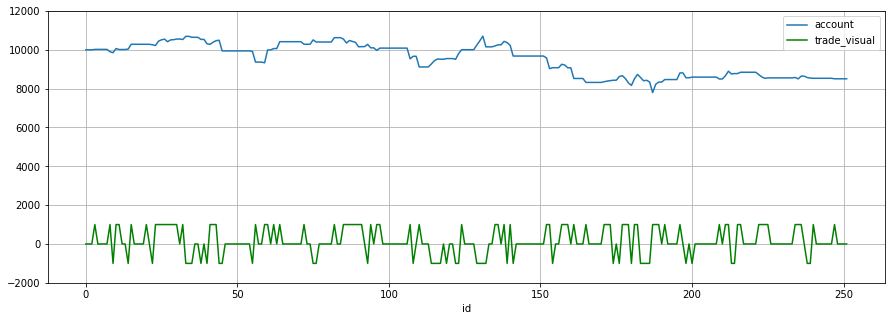

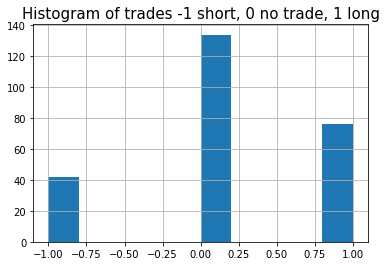

In [88]:
corn_account_nn = get_performance(corn_clf_nn, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [89]:
X = pca_transform(coffee_train, coffee_pca)
y = coffee_label_train
# remove outliers
X, y = remove_outliers(X, y, out_coffee)

X_test = pca_transform(coffee_test, coffee_pca)
y_test = coffee_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_coffee)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.coffee.hdf5')
coffee_clf_nn = model

Train on 1923 samples, validate on 481 samples
Epoch 1/200
1923/1923 [==============================] - 1s 646us/step - loss: 4533244221.0047 - acc: 0.3479 - val_loss: 4474390187.3763 - val_acc: 0.3119

Epoch 00001: val_loss improved from inf to 4474390187.37630, saving model to saved_models/weights.coffee.hdf5
Epoch 2/200
1923/1923 [==============================] - 0s 117us/step - loss: 4381009430.5772 - acc: 0.3677 - val_loss: 4321053866.3119 - val_acc: 0.3098

Epoch 00002: val_loss improved from 4474390187.37630 to 4321053866.31185, saving model to saved_models/weights.coffee.hdf5
Epoch 3/200
1923/1923 [==============================] - 0s 119us/step - loss: 4229024951.5091 - acc: 0.3328 - val_loss: 4170156020.5572 - val_acc: 0.2973

Epoch 00003: val_loss improved from 4321053866.31185 to 4170156020.55717, saving model to saved_models/weights.coffee.hdf5
Epoch 4/200
1923/1923 [==============================] - 0s 108us/step - loss: 4072596153.8430 - acc: 0.3583 - val_loss: 40240887

1923/1923 [==============================] - 0s 109us/step - loss: 1439461673.3188 - acc: 0.3453 - val_loss: 1407423066.6112 - val_acc: 0.3389

Epoch 00030: val_loss improved from 1477584278.48649 to 1407423066.61123, saving model to saved_models/weights.coffee.hdf5
Epoch 31/200
1923/1923 [==============================] - 0s 112us/step - loss: 1372523228.6219 - acc: 0.3302 - val_loss: 1339279027.8254 - val_acc: 0.3347

Epoch 00031: val_loss improved from 1407423066.61123 to 1339279027.82536, saving model to saved_models/weights.coffee.hdf5
Epoch 32/200
1923/1923 [==============================] - 0s 108us/step - loss: 1304178822.0239 - acc: 0.3198 - val_loss: 1273075672.0166 - val_acc: 0.3389

Epoch 00032: val_loss improved from 1339279027.82536 to 1273075672.01663, saving model to saved_models/weights.coffee.hdf5
Epoch 33/200
1923/1923 [==============================] - 0s 105us/step - loss: 1241834162.5387 - acc: 0.3604 - val_loss: 1208660139.8420 - val_acc: 0.3326

Epoch 00033: val

1923/1923 [==============================] - 0s 111us/step - loss: 133565275.6131 - acc: 0.3401 - val_loss: 120601102.0748 - val_acc: 0.3410

Epoch 00060: val_loss improved from 139935827.61746 to 120601102.07484, saving model to saved_models/weights.coffee.hdf5
Epoch 61/200
1923/1923 [==============================] - 0s 117us/step - loss: 115037216.2910 - acc: 0.3422 - val_loss: 102786952.9272 - val_acc: 0.3326

Epoch 00061: val_loss improved from 120601102.07484 to 102786952.92723, saving model to saved_models/weights.coffee.hdf5
Epoch 62/200
1923/1923 [==============================] - 0s 102us/step - loss: 97351087.2709 - acc: 0.3297 - val_loss: 86562001.3056 - val_acc: 0.3347

Epoch 00062: val_loss improved from 102786952.92723 to 86562001.30561, saving model to saved_models/weights.coffee.hdf5
Epoch 63/200
1923/1923 [==============================] - 0s 105us/step - loss: 81965401.3887 - acc: 0.3391 - val_loss: 71681434.0665 - val_acc: 0.3285

Epoch 00063: val_loss improved from

1923/1923 [==============================] - 0s 115us/step - loss: 51683.3864 - acc: 0.3359 - val_loss: 54397.4964 - val_acc: 0.3056

Epoch 00094: val_loss did not improve from 47018.55496
Epoch 95/200
1923/1923 [==============================] - 0s 114us/step - loss: 52139.6884 - acc: 0.3318 - val_loss: 52951.0612 - val_acc: 0.3222

Epoch 00095: val_loss did not improve from 47018.55496
Epoch 96/200
1923/1923 [==============================] - 0s 116us/step - loss: 52527.0048 - acc: 0.3505 - val_loss: 54350.6208 - val_acc: 0.3306

Epoch 00096: val_loss did not improve from 47018.55496
Epoch 97/200
1923/1923 [==============================] - 0s 113us/step - loss: 50533.6551 - acc: 0.3484 - val_loss: 55886.4963 - val_acc: 0.3867

Epoch 00097: val_loss did not improve from 47018.55496
Epoch 98/200
1923/1923 [==============================] - 0s 116us/step - loss: 51771.1961 - acc: 0.3521 - val_loss: 55188.4349 - val_acc: 0.3326

Epoch 00098: val_loss did not improve from 47018.55496
Epo

1923/1923 [==============================] - 0s 113us/step - loss: 51438.1440 - acc: 0.3411 - val_loss: 51282.4353 - val_acc: 0.3326

Epoch 00134: val_loss did not improve from 46174.47078
Epoch 135/200
1923/1923 [==============================] - 0s 114us/step - loss: 51033.1973 - acc: 0.3276 - val_loss: 62219.9238 - val_acc: 0.3701

Epoch 00135: val_loss did not improve from 46174.47078
Epoch 136/200
1923/1923 [==============================] - 0s 107us/step - loss: 54574.7729 - acc: 0.3500 - val_loss: 51903.6195 - val_acc: 0.3389

Epoch 00136: val_loss did not improve from 46174.47078
Epoch 137/200
1923/1923 [==============================] - 0s 104us/step - loss: 51346.0223 - acc: 0.3151 - val_loss: 51811.9319 - val_acc: 0.3285

Epoch 00137: val_loss did not improve from 46174.47078
Epoch 138/200
1923/1923 [==============================] - 0s 99us/step - loss: 50773.7896 - acc: 0.3443 - val_loss: 53733.7885 - val_acc: 0.3680

Epoch 00138: val_loss did not improve from 46174.47078


1923/1923 [==============================] - 0s 103us/step - loss: 53871.9701 - acc: 0.3214 - val_loss: 50059.4696 - val_acc: 0.2973

Epoch 00174: val_loss did not improve from 46174.47078
Epoch 175/200
1923/1923 [==============================] - 0s 104us/step - loss: 51497.5160 - acc: 0.3385 - val_loss: 51090.0815 - val_acc: 0.2620

Epoch 00175: val_loss did not improve from 46174.47078
Epoch 176/200
1923/1923 [==============================] - 0s 103us/step - loss: 50528.0803 - acc: 0.3099 - val_loss: 54551.0369 - val_acc: 0.2765

Epoch 00176: val_loss did not improve from 46174.47078
Epoch 177/200
1923/1923 [==============================] - 0s 103us/step - loss: 52319.8925 - acc: 0.3125 - val_loss: 48929.6799 - val_acc: 0.2682

Epoch 00177: val_loss did not improve from 46174.47078
Epoch 178/200
1923/1923 [==============================] - 0s 103us/step - loss: 49583.1511 - acc: 0.3250 - val_loss: 58879.7484 - val_acc: 0.2807

Epoch 00178: val_loss did not improve from 46174.47078

Returns  -19.70 %
Number of trades:  10
Number of short trades:  8
Number of long trades:  2
Earnings per trade:  -197.01
Earnings per short trade:  -208.49
Earnings per long trade:  -151.06


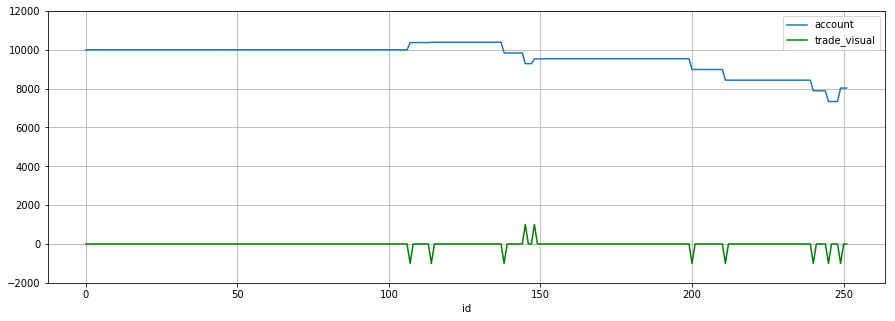

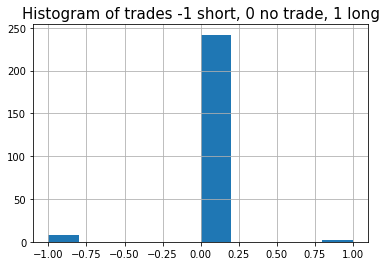

In [90]:
coffee_account_nn = get_performance(coffee_clf_nn, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, stop_loss_long=300, stop_loss_short=300)

# Neural network regressor

I have decided to use weighted in loss function with weight $0.75$. This is because errors around $0$ does not matter because I want to trigger trades when volatility reaches threshold.

Model performance
---


| commodity | gains % | earnings per trade | number of trades | test/real correlation |
|-----------|---------|--------------------|------------------|-----------------------|
| gold      | 232     | 180                | 129              | 0.14                  |
| corn      | -74     | -65                | 113              | -0.025                |
| coffee   | -12.92  | -56                | 23               | -0.020                |

In [91]:
import keras
import tensorflow as tf
from tensorflow.losses import mean_squared_error
from keras.optimizers import Nadam


def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)


def weighted_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, weights=0.75)


# loss = huber_loss
loss = weighted_mean_squared_error
# optimizer = 'Adam'
optimizer = Nadam(lr=0.0001)

def regressor_model():
    global input_shape
    global loss
    global optimizer
    # Define a model
    #     model = Sequential()  
    #     model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.4))
    #     model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.3))
    #     model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.2))
    #     # model.add(Dense(1))
    #     # model.add(Activation('tanh'))
    #     model.add(Dense(1, kernel_initializer='normal'))
    
    alpha=.0001
    model = Sequential()
    model.add(Dense(500, input_dim=input_shape, kernel_initializer='normal', activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dropout(0.4))
    model.add(Dense(128, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(64, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(32, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    return model

    # model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
    # model.compile(loss='l1', optimizer='sgd', metrics=['mse'])
    # return model

In [92]:
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)

epochs = 1000
batch_size = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)

In [93]:
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1931 samples, validate on 484 samples
Epoch 1/1000
1931/1931 [==============================] - 2s 968us/step - loss: 1278042.5607 - val_loss: 1215204.4806

Epoch 00001: val_loss improved from inf to 1215204.48063, saving model to saved_models/weights.gold_reg.hdf5
Epoch 2/1000
1931/1931 [==============================] - 0s 165us/step - loss: 1278048.8372 - val_loss: 1215204.8820

Epoch 00002: val_loss did not improve from 1215204.48063
Epoch 3/1000
1931/1931 [==============================] - 0s 157us/step - loss: 1278035.3798 - val_loss: 1215204.6139

Epoch 00003: val_loss did not improve from 1215204.48063
Epoch 4/1000
1931/1931 [==============================] - 0s 159us/step - loss: 1278034.1033 - val_loss: 1215204.6183

Epoch 00004: val_loss did not improve from 1215204.48063
Epoch 5/1000
1931/1931 [==============================] - 0s 152us/step - loss: 1278056.6513 - val_loss: 1215204.7831

Epoch 00005: val_loss did not improve from 1215204.48063
Epoch 6/1000
1931/193

1931/1931 [==============================] - 0s 155us/step - loss: 1277435.6447 - val_loss: 1215193.6903

Epoch 00046: val_loss improved from 1215198.19602 to 1215193.69034, saving model to saved_models/weights.gold_reg.hdf5
Epoch 47/1000
1931/1931 [==============================] - 0s 149us/step - loss: 1277349.8908 - val_loss: 1215195.2794

Epoch 00047: val_loss did not improve from 1215193.69034
Epoch 48/1000
1931/1931 [==============================] - 0s 156us/step - loss: 1277319.7078 - val_loss: 1215188.9757

Epoch 00048: val_loss improved from 1215193.69034 to 1215188.97572, saving model to saved_models/weights.gold_reg.hdf5
Epoch 49/1000
1931/1931 [==============================] - 0s 155us/step - loss: 1277197.4029 - val_loss: 1215180.6919

Epoch 00049: val_loss improved from 1215188.97572 to 1215180.69189, saving model to saved_models/weights.gold_reg.hdf5
Epoch 50/1000
1931/1931 [==============================] - 0s 147us/step - loss: 1277041.3482 - val_loss: 1215179.0225



1931/1931 [==============================] - 0s 138us/step - loss: 1271918.7088 - val_loss: 1214931.3892

Epoch 00083: val_loss improved from 1214951.11493 to 1214931.38920, saving model to saved_models/weights.gold_reg.hdf5
Epoch 84/1000
1931/1931 [==============================] - 0s 149us/step - loss: 1271580.4812 - val_loss: 1214940.6051

Epoch 00084: val_loss did not improve from 1214931.38920
Epoch 85/1000
1931/1931 [==============================] - 0s 140us/step - loss: 1271398.5349 - val_loss: 1214913.8884

Epoch 00085: val_loss improved from 1214931.38920 to 1214913.88843, saving model to saved_models/weights.gold_reg.hdf5
Epoch 86/1000
1931/1931 [==============================] - 0s 142us/step - loss: 1271507.5848 - val_loss: 1214918.8027

Epoch 00086: val_loss did not improve from 1214913.88843
Epoch 87/1000
1931/1931 [==============================] - 0s 140us/step - loss: 1271212.3454 - val_loss: 1214910.7107

Epoch 00087: val_loss improved from 1214913.88843 to 1214910.7

1931/1931 [==============================] - 0s 152us/step - loss: 1262643.2785 - val_loss: 1214572.9264

Epoch 00122: val_loss did not improve from 1214551.38404
Epoch 123/1000
1931/1931 [==============================] - 0s 145us/step - loss: 1262238.1941 - val_loss: 1214590.0904

Epoch 00123: val_loss did not improve from 1214551.38404
Epoch 124/1000
1931/1931 [==============================] - 0s 148us/step - loss: 1261974.7671 - val_loss: 1214571.2955

Epoch 00124: val_loss did not improve from 1214551.38404
Epoch 125/1000
1931/1931 [==============================] - 0s 143us/step - loss: 1261831.0555 - val_loss: 1214577.6748

Epoch 00125: val_loss did not improve from 1214551.38404
Epoch 126/1000
1931/1931 [==============================] - 0s 139us/step - loss: 1261983.3967 - val_loss: 1214564.5545

Epoch 00126: val_loss did not improve from 1214551.38404
Epoch 127/1000
1931/1931 [==============================] - 0s 138us/step - loss: 1261305.7239 - val_loss: 1214573.8029

Epoc

1931/1931 [==============================] - 0s 136us/step - loss: 1248850.9191 - val_loss: 1214257.1446

Epoch 00165: val_loss improved from 1214331.55888 to 1214257.14463, saving model to saved_models/weights.gold_reg.hdf5
Epoch 166/1000
1931/1931 [==============================] - 0s 140us/step - loss: 1247778.3032 - val_loss: 1214290.3042

Epoch 00166: val_loss did not improve from 1214257.14463
Epoch 167/1000
1931/1931 [==============================] - 0s 146us/step - loss: 1247883.2607 - val_loss: 1214305.1051

Epoch 00167: val_loss did not improve from 1214257.14463
Epoch 168/1000
1931/1931 [==============================] - 0s 155us/step - loss: 1248096.4898 - val_loss: 1214252.1353

Epoch 00168: val_loss improved from 1214257.14463 to 1214252.13533, saving model to saved_models/weights.gold_reg.hdf5
Epoch 169/1000
1931/1931 [==============================] - 0s 146us/step - loss: 1247221.7431 - val_loss: 1214269.7136

Epoch 00169: val_loss did not improve from 1214252.13533
E

1931/1931 [==============================] - 0s 149us/step - loss: 1233734.6381 - val_loss: 1214490.5700

Epoch 00210: val_loss did not improve from 1214136.87035
Epoch 211/1000
1931/1931 [==============================] - 0s 152us/step - loss: 1230905.5369 - val_loss: 1214520.4086

Epoch 00211: val_loss did not improve from 1214136.87035
Epoch 212/1000
1931/1931 [==============================] - 0s 149us/step - loss: 1231793.1245 - val_loss: 1214447.4163

Epoch 00212: val_loss did not improve from 1214136.87035
Epoch 213/1000
1931/1931 [==============================] - 0s 151us/step - loss: 1230456.3245 - val_loss: 1214423.2836

Epoch 00213: val_loss did not improve from 1214136.87035
Epoch 214/1000
1931/1931 [==============================] - 0s 142us/step - loss: 1230261.7922 - val_loss: 1214405.7477

Epoch 00214: val_loss did not improve from 1214136.87035
Epoch 215/1000
1931/1931 [==============================] - 0s 144us/step - loss: 1228037.4910 - val_loss: 1214450.0940

Epoc

1931/1931 [==============================] - 0s 141us/step - loss: 1212121.2550 - val_loss: 1214142.7998

Epoch 00255: val_loss did not improve from 1213910.86648
Epoch 256/1000
1931/1931 [==============================] - 0s 152us/step - loss: 1211515.2653 - val_loss: 1214047.0997

Epoch 00256: val_loss did not improve from 1213910.86648
Epoch 257/1000
1931/1931 [==============================] - 0s 141us/step - loss: 1210572.5223 - val_loss: 1214001.2993

Epoch 00257: val_loss did not improve from 1213910.86648
Epoch 258/1000
1931/1931 [==============================] - 0s 140us/step - loss: 1209755.3519 - val_loss: 1214124.1823

Epoch 00258: val_loss did not improve from 1213910.86648
Epoch 259/1000
1931/1931 [==============================] - 0s 152us/step - loss: 1209721.6735 - val_loss: 1214092.1795

Epoch 00259: val_loss did not improve from 1213910.86648
Epoch 260/1000
1931/1931 [==============================] - 0s 150us/step - loss: 1208673.9856 - val_loss: 1213965.9086

Epoc


Epoch 00298: val_loss did not improve from 1213537.71462
Epoch 299/1000
1931/1931 [==============================] - 0s 146us/step - loss: 1189958.5788 - val_loss: 1214498.7730

Epoch 00299: val_loss did not improve from 1213537.71462
Epoch 300/1000
1931/1931 [==============================] - 0s 135us/step - loss: 1189013.8666 - val_loss: 1214406.9347

Epoch 00300: val_loss did not improve from 1213537.71462
Epoch 301/1000
1931/1931 [==============================] - 0s 152us/step - loss: 1189774.5887 - val_loss: 1214443.9375

Epoch 00301: val_loss did not improve from 1213537.71462
Epoch 302/1000
1931/1931 [==============================] - 0s 158us/step - loss: 1189012.0729 - val_loss: 1214432.1170

Epoch 00302: val_loss did not improve from 1213537.71462
Epoch 303/1000
1931/1931 [==============================] - 0s 153us/step - loss: 1187361.9670 - val_loss: 1214379.2962

Epoch 00303: val_loss did not improve from 1213537.71462
Epoch 304/1000
1931/1931 [==========================


Epoch 00343: val_loss did not improve from 1213217.76317
Epoch 344/1000
1931/1931 [==============================] - 0s 138us/step - loss: 1164634.9081 - val_loss: 1213874.6193

Epoch 00344: val_loss did not improve from 1213217.76317
Epoch 345/1000
1931/1931 [==============================] - 0s 135us/step - loss: 1164232.7874 - val_loss: 1213912.7761

Epoch 00345: val_loss did not improve from 1213217.76317
Epoch 346/1000
1931/1931 [==============================] - 0s 141us/step - loss: 1163811.7993 - val_loss: 1213963.2926

Epoch 00346: val_loss did not improve from 1213217.76317
Epoch 347/1000
1931/1931 [==============================] - 0s 136us/step - loss: 1161698.4429 - val_loss: 1213872.5341

Epoch 00347: val_loss did not improve from 1213217.76317
Epoch 348/1000
1931/1931 [==============================] - 0s 133us/step - loss: 1161646.7792 - val_loss: 1213818.4675

Epoch 00348: val_loss did not improve from 1213217.76317
Epoch 349/1000
1931/1931 [==========================

1931/1931 [==============================] - 0s 139us/step - loss: 1137146.3709 - val_loss: 1213329.6098

Epoch 00390: val_loss did not improve from 1213217.76317
Epoch 391/1000
1931/1931 [==============================] - 0s 136us/step - loss: 1136634.7828 - val_loss: 1213431.2820

Epoch 00391: val_loss did not improve from 1213217.76317
Epoch 392/1000
1931/1931 [==============================] - 0s 138us/step - loss: 1136961.9455 - val_loss: 1213379.5000

Epoch 00392: val_loss did not improve from 1213217.76317
Epoch 393/1000
1931/1931 [==============================] - 0s 137us/step - loss: 1134512.0679 - val_loss: 1213504.2608

Epoch 00393: val_loss did not improve from 1213217.76317
Epoch 394/1000
1931/1931 [==============================] - 0s 138us/step - loss: 1137797.7420 - val_loss: 1213201.9904

Epoch 00394: val_loss improved from 1213217.76317 to 1213201.99044, saving model to saved_models/weights.gold_reg.hdf5
Epoch 395/1000
1931/1931 [==============================] - 0s 

1931/1931 [==============================] - 0s 137us/step - loss: 1107562.2718 - val_loss: 1214115.1160

Epoch 00435: val_loss did not improve from 1213167.87371
Epoch 436/1000
1931/1931 [==============================] - 0s 135us/step - loss: 1103066.3335 - val_loss: 1213995.3926

Epoch 00436: val_loss did not improve from 1213167.87371
Epoch 437/1000
1931/1931 [==============================] - 0s 142us/step - loss: 1109456.2798 - val_loss: 1213782.0447

Epoch 00437: val_loss did not improve from 1213167.87371
Epoch 438/1000
1931/1931 [==============================] - 0s 139us/step - loss: 1103894.9793 - val_loss: 1214021.7745

Epoch 00438: val_loss did not improve from 1213167.87371
Epoch 439/1000
1931/1931 [==============================] - 0s 133us/step - loss: 1103106.8350 - val_loss: 1214132.9223

Epoch 00439: val_loss did not improve from 1213167.87371
Epoch 440/1000
1931/1931 [==============================] - 0s 153us/step - loss: 1103920.7932 - val_loss: 1214199.8729

Epoc

1931/1931 [==============================] - 0s 229us/step - loss: 1072576.5085 - val_loss: 1216322.0000

Epoch 00481: val_loss did not improve from 1213167.87371
Epoch 482/1000
1931/1931 [==============================] - 0s 183us/step - loss: 1078650.4310 - val_loss: 1216533.4032

Epoch 00482: val_loss did not improve from 1213167.87371
Epoch 483/1000
1931/1931 [==============================] - 0s 169us/step - loss: 1077759.0597 - val_loss: 1216326.8546

Epoch 00483: val_loss did not improve from 1213167.87371
Epoch 484/1000
1931/1931 [==============================] - 0s 204us/step - loss: 1071737.0556 - val_loss: 1216171.6547

Epoch 00484: val_loss did not improve from 1213167.87371
Epoch 485/1000
1931/1931 [==============================] - 0s 146us/step - loss: 1069471.8252 - val_loss: 1216030.7361

Epoch 00485: val_loss did not improve from 1213167.87371
Epoch 486/1000
1931/1931 [==============================] - 0s 172us/step - loss: 1073954.5646 - val_loss: 1215721.3140

Epoc

1931/1931 [==============================] - 0s 157us/step - loss: 1042631.9015 - val_loss: 1215664.8673

Epoch 00527: val_loss did not improve from 1213167.87371
Epoch 528/1000
1931/1931 [==============================] - 0s 157us/step - loss: 1036926.2517 - val_loss: 1215986.1178

Epoch 00528: val_loss did not improve from 1213167.87371
Epoch 529/1000
1931/1931 [==============================] - 0s 150us/step - loss: 1041630.4211 - val_loss: 1216225.6798

Epoch 00529: val_loss did not improve from 1213167.87371
Epoch 530/1000
1931/1931 [==============================] - 0s 147us/step - loss: 1033465.6240 - val_loss: 1216497.0015

Epoch 00530: val_loss did not improve from 1213167.87371
Epoch 531/1000
1931/1931 [==============================] - 0s 140us/step - loss: 1042252.4791 - val_loss: 1216618.4770

Epoch 00531: val_loss did not improve from 1213167.87371
Epoch 532/1000
1931/1931 [==============================] - 0s 142us/step - loss: 1036961.3605 - val_loss: 1216787.5772

Epoc

1931/1931 [==============================] - 0s 136us/step - loss: 1009776.7762 - val_loss: 1219781.1973

Epoch 00573: val_loss did not improve from 1213167.87371
Epoch 574/1000
1931/1931 [==============================] - 0s 141us/step - loss: 1000870.8265 - val_loss: 1219520.4633

Epoch 00574: val_loss did not improve from 1213167.87371
Epoch 575/1000
1931/1931 [==============================] - 0s 137us/step - loss: 1007452.8868 - val_loss: 1219657.9478

Epoch 00575: val_loss did not improve from 1213167.87371
Epoch 576/1000
1931/1931 [==============================] - 0s 139us/step - loss: 1004305.6104 - val_loss: 1218976.7466

Epoch 00576: val_loss did not improve from 1213167.87371
Epoch 577/1000
1931/1931 [==============================] - 0s 136us/step - loss: 1005675.6623 - val_loss: 1218537.8468

Epoch 00577: val_loss did not improve from 1213167.87371
Epoch 578/1000
1931/1931 [==============================] - 0s 138us/step - loss: 1002280.9276 - val_loss: 1218014.9047

Epoc

1931/1931 [==============================] - 0s 145us/step - loss: 973024.3237 - val_loss: 1222269.2841

Epoch 00619: val_loss did not improve from 1213167.87371
Epoch 620/1000
1931/1931 [==============================] - 0s 143us/step - loss: 976264.3459 - val_loss: 1222745.7076

Epoch 00620: val_loss did not improve from 1213167.87371
Epoch 621/1000
1931/1931 [==============================] - 0s 137us/step - loss: 968213.2640 - val_loss: 1222664.2045

Epoch 00621: val_loss did not improve from 1213167.87371
Epoch 622/1000
1931/1931 [==============================] - 0s 136us/step - loss: 968879.1417 - val_loss: 1222622.1911

Epoch 00622: val_loss did not improve from 1213167.87371
Epoch 623/1000
1931/1931 [==============================] - 0s 137us/step - loss: 971417.3262 - val_loss: 1222447.2663

Epoch 00623: val_loss did not improve from 1213167.87371
Epoch 624/1000
1931/1931 [==============================] - 0s 139us/step - loss: 965171.4125 - val_loss: 1222760.8311

Epoch 0062

1931/1931 [==============================] - 0s 155us/step - loss: 938216.2125 - val_loss: 1226368.9556

Epoch 00665: val_loss did not improve from 1213167.87371
Epoch 666/1000
1931/1931 [==============================] - 0s 148us/step - loss: 933212.0691 - val_loss: 1226816.0571

Epoch 00666: val_loss did not improve from 1213167.87371
Epoch 667/1000
1931/1931 [==============================] - 0s 148us/step - loss: 932366.3352 - val_loss: 1227020.3696

Epoch 00667: val_loss did not improve from 1213167.87371
Epoch 668/1000
1931/1931 [==============================] - 0s 240us/step - loss: 926828.8059 - val_loss: 1227295.8582

Epoch 00668: val_loss did not improve from 1213167.87371
Epoch 669/1000
1931/1931 [==============================] - 0s 198us/step - loss: 937330.8607 - val_loss: 1227115.3737

Epoch 00669: val_loss did not improve from 1213167.87371
Epoch 670/1000
1931/1931 [==============================] - 0s 214us/step - loss: 932573.0064 - val_loss: 1226746.6126

Epoch 0067

1931/1931 [==============================] - 0s 146us/step - loss: 898451.1836 - val_loss: 1229933.7934

Epoch 00711: val_loss did not improve from 1213167.87371
Epoch 712/1000
1931/1931 [==============================] - 0s 149us/step - loss: 891848.5653 - val_loss: 1230366.6457

Epoch 00712: val_loss did not improve from 1213167.87371
Epoch 713/1000
1931/1931 [==============================] - 0s 152us/step - loss: 891561.9886 - val_loss: 1231197.1712

Epoch 00713: val_loss did not improve from 1213167.87371
Epoch 714/1000
1931/1931 [==============================] - 0s 152us/step - loss: 886647.5015 - val_loss: 1231848.5759

Epoch 00714: val_loss did not improve from 1213167.87371
Epoch 715/1000
1931/1931 [==============================] - 0s 162us/step - loss: 894363.7321 - val_loss: 1231539.8605

Epoch 00715: val_loss did not improve from 1213167.87371
Epoch 716/1000
1931/1931 [==============================] - 0s 155us/step - loss: 898539.7280 - val_loss: 1230698.1315

Epoch 0071

1931/1931 [==============================] - 0s 146us/step - loss: 848192.5839 - val_loss: 1237571.4595

Epoch 00757: val_loss did not improve from 1213167.87371
Epoch 758/1000
1931/1931 [==============================] - 0s 146us/step - loss: 849928.5886 - val_loss: 1235872.2554

Epoch 00758: val_loss did not improve from 1213167.87371
Epoch 759/1000
1931/1931 [==============================] - 0s 158us/step - loss: 850010.3799 - val_loss: 1235036.5757

Epoch 00759: val_loss did not improve from 1213167.87371
Epoch 760/1000
1931/1931 [==============================] - 0s 154us/step - loss: 848816.9868 - val_loss: 1234761.1898

Epoch 00760: val_loss did not improve from 1213167.87371
Epoch 761/1000
1931/1931 [==============================] - 0s 153us/step - loss: 851548.6249 - val_loss: 1235966.7722

Epoch 00761: val_loss did not improve from 1213167.87371
Epoch 762/1000
1931/1931 [==============================] - 0s 163us/step - loss: 846759.4347 - val_loss: 1236763.8151

Epoch 0076

1931/1931 [==============================] - 0s 154us/step - loss: 804806.2829 - val_loss: 1244534.8223

Epoch 00803: val_loss did not improve from 1213167.87371
Epoch 804/1000
1931/1931 [==============================] - 0s 158us/step - loss: 816358.8187 - val_loss: 1243603.5070

Epoch 00804: val_loss did not improve from 1213167.87371
Epoch 805/1000
1931/1931 [==============================] - 0s 150us/step - loss: 821646.7590 - val_loss: 1243607.5651

Epoch 00805: val_loss did not improve from 1213167.87371
Epoch 806/1000
1931/1931 [==============================] - 0s 154us/step - loss: 808826.4095 - val_loss: 1244035.5220

Epoch 00806: val_loss did not improve from 1213167.87371
Epoch 807/1000
1931/1931 [==============================] - 0s 145us/step - loss: 810054.3537 - val_loss: 1244829.5460

Epoch 00807: val_loss did not improve from 1213167.87371
Epoch 808/1000
1931/1931 [==============================] - 0s 155us/step - loss: 810598.8474 - val_loss: 1245061.1911

Epoch 0080

1931/1931 [==============================] - 0s 151us/step - loss: 773822.4288 - val_loss: 1252663.9329

Epoch 00849: val_loss did not improve from 1213167.87371
Epoch 850/1000
1931/1931 [==============================] - 0s 151us/step - loss: 770619.0133 - val_loss: 1253603.2053

Epoch 00850: val_loss did not improve from 1213167.87371
Epoch 851/1000
1931/1931 [==============================] - 0s 147us/step - loss: 779905.3162 - val_loss: 1253474.5752

Epoch 00851: val_loss did not improve from 1213167.87371
Epoch 852/1000
1931/1931 [==============================] - 0s 151us/step - loss: 774939.9577 - val_loss: 1253436.6614

Epoch 00852: val_loss did not improve from 1213167.87371
Epoch 853/1000
1931/1931 [==============================] - 0s 146us/step - loss: 775911.1904 - val_loss: 1253038.9990

Epoch 00853: val_loss did not improve from 1213167.87371
Epoch 854/1000
1931/1931 [==============================] - 0s 145us/step - loss: 773164.1270 - val_loss: 1252879.2859

Epoch 0085

1931/1931 [==============================] - 0s 143us/step - loss: 740759.7532 - val_loss: 1266034.2417

Epoch 00895: val_loss did not improve from 1213167.87371
Epoch 896/1000
1931/1931 [==============================] - 0s 146us/step - loss: 741209.9326 - val_loss: 1265083.9610

Epoch 00896: val_loss did not improve from 1213167.87371
Epoch 897/1000
1931/1931 [==============================] - 0s 146us/step - loss: 730646.6804 - val_loss: 1264678.7800

Epoch 00897: val_loss did not improve from 1213167.87371
Epoch 898/1000
1931/1931 [==============================] - 0s 138us/step - loss: 732623.7747 - val_loss: 1264223.4390

Epoch 00898: val_loss did not improve from 1213167.87371
Epoch 899/1000
1931/1931 [==============================] - 0s 140us/step - loss: 731557.6260 - val_loss: 1264644.1557

Epoch 00899: val_loss did not improve from 1213167.87371
Epoch 900/1000
1931/1931 [==============================] - 0s 141us/step - loss: 729250.2646 - val_loss: 1263675.6258

Epoch 0090

1931/1931 [==============================] - 0s 147us/step - loss: 690837.7015 - val_loss: 1278914.0000

Epoch 00941: val_loss did not improve from 1213167.87371
Epoch 942/1000
1931/1931 [==============================] - 0s 140us/step - loss: 692729.3436 - val_loss: 1279440.9117

Epoch 00942: val_loss did not improve from 1213167.87371
Epoch 943/1000
1931/1931 [==============================] - 0s 142us/step - loss: 697736.9278 - val_loss: 1278455.3675

Epoch 00943: val_loss did not improve from 1213167.87371
Epoch 944/1000
1931/1931 [==============================] - 0s 141us/step - loss: 697773.2014 - val_loss: 1276968.8941

Epoch 00944: val_loss did not improve from 1213167.87371
Epoch 945/1000
1931/1931 [==============================] - 0s 145us/step - loss: 684550.5753 - val_loss: 1277966.2433

Epoch 00945: val_loss did not improve from 1213167.87371
Epoch 946/1000
1931/1931 [==============================] - 0s 140us/step - loss: 687530.9166 - val_loss: 1279756.4039

Epoch 0094

1931/1931 [==============================] - 0s 144us/step - loss: 673766.4749 - val_loss: 1293372.3040

Epoch 00987: val_loss did not improve from 1213167.87371
Epoch 988/1000
1931/1931 [==============================] - 0s 143us/step - loss: 654308.0444 - val_loss: 1294600.3735

Epoch 00988: val_loss did not improve from 1213167.87371
Epoch 989/1000
1931/1931 [==============================] - 0s 141us/step - loss: 640182.1885 - val_loss: 1294473.0607

Epoch 00989: val_loss did not improve from 1213167.87371
Epoch 990/1000
1931/1931 [==============================] - 0s 138us/step - loss: 649870.2678 - val_loss: 1294659.2745

Epoch 00990: val_loss did not improve from 1213167.87371
Epoch 991/1000
1931/1931 [==============================] - 0s 140us/step - loss: 657823.9833 - val_loss: 1294559.2131

Epoch 00991: val_loss did not improve from 1213167.87371
Epoch 992/1000
1931/1931 [==============================] - 0s 138us/step - loss: 658406.2675 - val_loss: 1295508.4667

Epoch 0099

In [94]:
model = regressor_model()
model.load_weights('saved_models/weights.gold_reg.hdf5')
gold_clf_reg_nn = model

Predictions/Actual volatility correlation:  0.15776571798534034
Returns  116.62 %
Number of trades:  59
Number of short trades:  11
Number of long trades:  48
Earnings per trade:  197.66
Earnings per short trade:  575.41
Earnings per long trade:  111.09


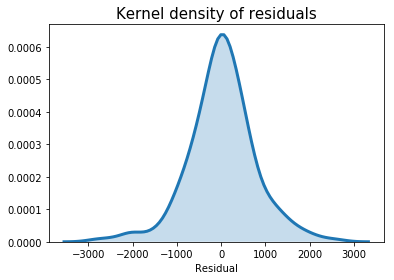

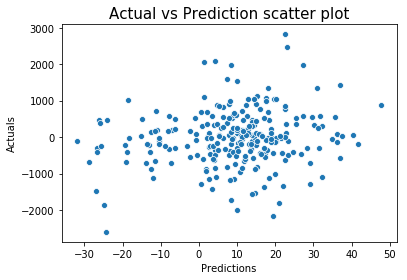

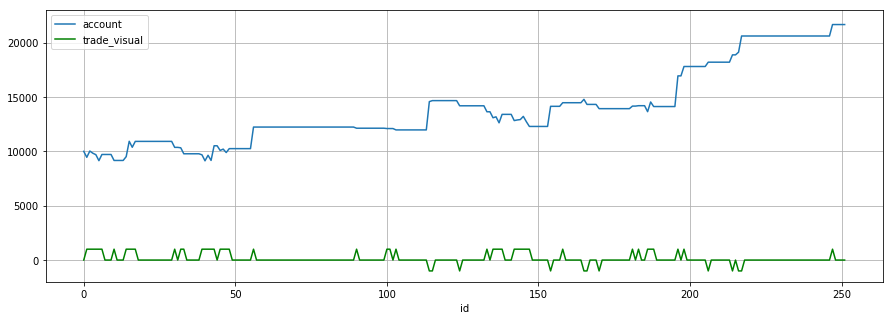

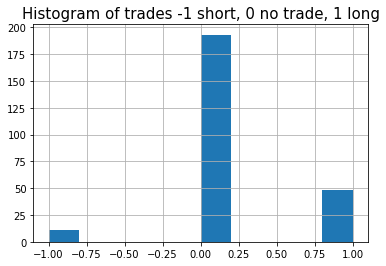

In [95]:
gold_account_nn = get_performance(gold_clf_reg_nn, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=20)

In [96]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
# remove outliers
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=50, batch_size=50)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1930 samples, validate on 483 samples
Epoch 1/1000
1930/1930 [==============================] - 2s 1ms/step - loss: 132251.3939 - val_loss: 131891.0789

Epoch 00001: val_loss improved from inf to 131891.07885, saving model to saved_models/weights.corn_reg.hdf5
Epoch 2/1000
1930/1930 [==============================] - 0s 159us/step - loss: 132248.4402 - val_loss: 131890.2297

Epoch 00002: val_loss improved from 131891.07885 to 131890.22975, saving model to saved_models/weights.corn_reg.hdf5
Epoch 3/1000
1930/1930 [==============================] - 0s 156us/step - loss: 132230.4416 - val_loss: 131890.0433

Epoch 00003: val_loss improved from 131890.22975 to 131890.04333, saving model to saved_models/weights.corn_reg.hdf5
Epoch 4/1000
1930/1930 [==============================] - 0s 148us/step - loss: 132240.1758 - val_loss: 131889.1395

Epoch 00004: val_loss improved from 131890.04333 to 131889.13951, saving model to saved_models/weights.corn_reg.hdf5
Epoch 5/1000
1930/1930 [====


Epoch 00042: val_loss did not improve from 131878.42647
Epoch 43/1000
1930/1930 [==============================] - 0s 149us/step - loss: 130832.4231 - val_loss: 131945.7136

Epoch 00043: val_loss did not improve from 131878.42647
Epoch 44/1000
1930/1930 [==============================] - 0s 150us/step - loss: 130745.3213 - val_loss: 131954.3425

Epoch 00044: val_loss did not improve from 131878.42647
Epoch 45/1000
1930/1930 [==============================] - 0s 145us/step - loss: 130660.3510 - val_loss: 131961.1831

Epoch 00045: val_loss did not improve from 131878.42647
Epoch 46/1000
1930/1930 [==============================] - 0s 150us/step - loss: 130567.3311 - val_loss: 131962.6257

Epoch 00046: val_loss did not improve from 131878.42647
Epoch 47/1000
1930/1930 [==============================] - 0s 153us/step - loss: 130624.4372 - val_loss: 131967.6507

Epoch 00047: val_loss did not improve from 131878.42647
Epoch 48/1000
1930/1930 [==============================] - 0s 158us/step 

1930/1930 [==============================] - 0s 152us/step - loss: 126883.4948 - val_loss: 132187.0180

Epoch 00090: val_loss did not improve from 131878.42647
Epoch 91/1000
1930/1930 [==============================] - 0s 168us/step - loss: 126917.9026 - val_loss: 132196.5932

Epoch 00091: val_loss did not improve from 131878.42647
Epoch 92/1000
1930/1930 [==============================] - 0s 169us/step - loss: 126868.7428 - val_loss: 132225.1147

Epoch 00092: val_loss did not improve from 131878.42647
Epoch 93/1000
1930/1930 [==============================] - 0s 175us/step - loss: 126880.6913 - val_loss: 132221.0730

Epoch 00093: val_loss did not improve from 131878.42647
Epoch 94/1000
1930/1930 [==============================] - 0s 157us/step - loss: 126884.4672 - val_loss: 132220.2212

Epoch 00094: val_loss did not improve from 131878.42647
Epoch 95/1000
1930/1930 [==============================] - 0s 157us/step - loss: 126480.2279 - val_loss: 132237.4425

Epoch 00095: val_loss did 

1930/1930 [==============================] - 0s 156us/step - loss: 122291.8911 - val_loss: 132503.4984

Epoch 00137: val_loss did not improve from 131878.42647
Epoch 138/1000
1930/1930 [==============================] - 0s 144us/step - loss: 122311.6645 - val_loss: 132502.1808

Epoch 00138: val_loss did not improve from 131878.42647
Epoch 139/1000
1930/1930 [==============================] - 0s 153us/step - loss: 121796.4944 - val_loss: 132505.7792

Epoch 00139: val_loss did not improve from 131878.42647
Epoch 140/1000
1930/1930 [==============================] - 0s 151us/step - loss: 121864.6011 - val_loss: 132511.5447

Epoch 00140: val_loss did not improve from 131878.42647
Epoch 141/1000
1930/1930 [==============================] - 0s 151us/step - loss: 121871.0071 - val_loss: 132526.4234

Epoch 00141: val_loss did not improve from 131878.42647
Epoch 142/1000
1930/1930 [==============================] - 0s 156us/step - loss: 121333.2185 - val_loss: 132563.9174

Epoch 00142: val_loss

1930/1930 [==============================] - 0s 157us/step - loss: 116586.6697 - val_loss: 133069.0934

Epoch 00184: val_loss did not improve from 131878.42647
Epoch 185/1000
1930/1930 [==============================] - 0s 166us/step - loss: 115979.4177 - val_loss: 133065.3314

Epoch 00185: val_loss did not improve from 131878.42647
Epoch 186/1000
1930/1930 [==============================] - 0s 166us/step - loss: 116758.5444 - val_loss: 133071.3029

Epoch 00186: val_loss did not improve from 131878.42647
Epoch 187/1000
1930/1930 [==============================] - 0s 166us/step - loss: 116200.8801 - val_loss: 133065.7766

Epoch 00187: val_loss did not improve from 131878.42647
Epoch 188/1000
1930/1930 [==============================] - 0s 162us/step - loss: 116360.0969 - val_loss: 133075.4153

Epoch 00188: val_loss did not improve from 131878.42647
Epoch 189/1000
1930/1930 [==============================] - 0s 162us/step - loss: 116064.7174 - val_loss: 133087.3694

Epoch 00189: val_loss

1930/1930 [==============================] - 0s 158us/step - loss: 110174.5970 - val_loss: 133973.9509

Epoch 00231: val_loss did not improve from 131878.42647
Epoch 232/1000
1930/1930 [==============================] - 0s 162us/step - loss: 110091.2949 - val_loss: 134007.4672

Epoch 00232: val_loss did not improve from 131878.42647
Epoch 233/1000
1930/1930 [==============================] - 0s 163us/step - loss: 109797.7793 - val_loss: 134054.1813

Epoch 00233: val_loss did not improve from 131878.42647
Epoch 234/1000
1930/1930 [==============================] - 0s 168us/step - loss: 109465.0327 - val_loss: 134049.7695

Epoch 00234: val_loss did not improve from 131878.42647
Epoch 235/1000
1930/1930 [==============================] - 0s 159us/step - loss: 109995.9782 - val_loss: 134072.5126

Epoch 00235: val_loss did not improve from 131878.42647
Epoch 236/1000
1930/1930 [==============================] - 0s 166us/step - loss: 109870.6270 - val_loss: 134093.7309

Epoch 00236: val_loss

1930/1930 [==============================] - 0s 146us/step - loss: 103062.1688 - val_loss: 135081.5512

Epoch 00278: val_loss did not improve from 131878.42647
Epoch 279/1000
1930/1930 [==============================] - 0s 150us/step - loss: 102967.1599 - val_loss: 135140.6906

Epoch 00279: val_loss did not improve from 131878.42647
Epoch 280/1000
1930/1930 [==============================] - 0s 158us/step - loss: 102840.0169 - val_loss: 135153.7018

Epoch 00280: val_loss did not improve from 131878.42647
Epoch 281/1000
1930/1930 [==============================] - 0s 148us/step - loss: 102463.8014 - val_loss: 135225.7832

Epoch 00281: val_loss did not improve from 131878.42647
Epoch 282/1000
1930/1930 [==============================] - 0s 149us/step - loss: 102549.9043 - val_loss: 135218.5327

Epoch 00282: val_loss did not improve from 131878.42647
Epoch 283/1000
1930/1930 [==============================] - 0s 148us/step - loss: 102512.4046 - val_loss: 135206.6598

Epoch 00283: val_loss

1930/1930 [==============================] - 0s 182us/step - loss: 95820.8899 - val_loss: 136596.6520

Epoch 00325: val_loss did not improve from 131878.42647
Epoch 326/1000
1930/1930 [==============================] - 0s 174us/step - loss: 95679.6277 - val_loss: 136799.6765

Epoch 00326: val_loss did not improve from 131878.42647
Epoch 327/1000
1930/1930 [==============================] - 0s 156us/step - loss: 95830.4547 - val_loss: 136785.7826

Epoch 00327: val_loss did not improve from 131878.42647
Epoch 328/1000
1930/1930 [==============================] - 0s 152us/step - loss: 95225.5909 - val_loss: 136795.7896

Epoch 00328: val_loss did not improve from 131878.42647
Epoch 329/1000
1930/1930 [==============================] - 0s 153us/step - loss: 94255.5377 - val_loss: 136907.2512

Epoch 00329: val_loss did not improve from 131878.42647
Epoch 330/1000
1930/1930 [==============================] - 0s 158us/step - loss: 94573.0843 - val_loss: 136940.4493

Epoch 00330: val_loss did n

1930/1930 [==============================] - 0s 155us/step - loss: 88912.4491 - val_loss: 138860.7204

Epoch 00372: val_loss did not improve from 131878.42647
Epoch 373/1000
1930/1930 [==============================] - 0s 151us/step - loss: 87107.0113 - val_loss: 139033.9217

Epoch 00373: val_loss did not improve from 131878.42647
Epoch 374/1000
1930/1930 [==============================] - 0s 156us/step - loss: 87534.1634 - val_loss: 138946.8125

Epoch 00374: val_loss did not improve from 131878.42647
Epoch 375/1000
1930/1930 [==============================] - 0s 155us/step - loss: 88012.7808 - val_loss: 138905.9099

Epoch 00375: val_loss did not improve from 131878.42647
Epoch 376/1000
1930/1930 [==============================] - 0s 154us/step - loss: 87389.3741 - val_loss: 139000.7609

Epoch 00376: val_loss did not improve from 131878.42647
Epoch 377/1000
1930/1930 [==============================] - 0s 153us/step - loss: 87950.2830 - val_loss: 138998.2131

Epoch 00377: val_loss did n

1930/1930 [==============================] - 0s 169us/step - loss: 80587.8673 - val_loss: 141096.3817

Epoch 00419: val_loss did not improve from 131878.42647
Epoch 420/1000
1930/1930 [==============================] - 0s 165us/step - loss: 80286.6427 - val_loss: 141272.4840

Epoch 00420: val_loss did not improve from 131878.42647
Epoch 421/1000
1930/1930 [==============================] - 0s 163us/step - loss: 79688.7312 - val_loss: 141259.8616

Epoch 00421: val_loss did not improve from 131878.42647
Epoch 422/1000
1930/1930 [==============================] - 0s 154us/step - loss: 79068.8561 - val_loss: 141285.7430

Epoch 00422: val_loss did not improve from 131878.42647
Epoch 423/1000
1930/1930 [==============================] - 0s 151us/step - loss: 79029.8674 - val_loss: 141467.8913

Epoch 00423: val_loss did not improve from 131878.42647
Epoch 424/1000
1930/1930 [==============================] - 0s 159us/step - loss: 79963.8045 - val_loss: 141482.2514

Epoch 00424: val_loss did n

1930/1930 [==============================] - 0s 158us/step - loss: 73358.4418 - val_loss: 144187.5906

Epoch 00466: val_loss did not improve from 131878.42647
Epoch 467/1000
1930/1930 [==============================] - 0s 156us/step - loss: 72353.7083 - val_loss: 144357.1780

Epoch 00467: val_loss did not improve from 131878.42647
Epoch 468/1000
1930/1930 [==============================] - 0s 159us/step - loss: 73012.9514 - val_loss: 144375.3070

Epoch 00468: val_loss did not improve from 131878.42647
Epoch 469/1000
1930/1930 [==============================] - 0s 161us/step - loss: 71837.7082 - val_loss: 144509.8188

Epoch 00469: val_loss did not improve from 131878.42647
Epoch 470/1000
1930/1930 [==============================] - 0s 154us/step - loss: 71603.2831 - val_loss: 144687.7683

Epoch 00470: val_loss did not improve from 131878.42647
Epoch 471/1000
1930/1930 [==============================] - 0s 143us/step - loss: 72801.7563 - val_loss: 144936.8646

Epoch 00471: val_loss did n

1930/1930 [==============================] - 0s 161us/step - loss: 64983.7451 - val_loss: 147727.2027

Epoch 00513: val_loss did not improve from 131878.42647
Epoch 514/1000
1930/1930 [==============================] - 0s 190us/step - loss: 64980.9911 - val_loss: 148029.7471

Epoch 00514: val_loss did not improve from 131878.42647
Epoch 515/1000
1930/1930 [==============================] - 0s 187us/step - loss: 63893.1795 - val_loss: 148309.7022

Epoch 00515: val_loss did not improve from 131878.42647
Epoch 516/1000
1930/1930 [==============================] - 0s 156us/step - loss: 64285.2721 - val_loss: 148675.8489

Epoch 00516: val_loss did not improve from 131878.42647
Epoch 517/1000
1930/1930 [==============================] - 0s 178us/step - loss: 63429.2432 - val_loss: 148686.2412

Epoch 00517: val_loss did not improve from 131878.42647
Epoch 518/1000
1930/1930 [==============================] - 0s 185us/step - loss: 63503.1992 - val_loss: 149049.6388

Epoch 00518: val_loss did n

1930/1930 [==============================] - 0s 151us/step - loss: 55688.5653 - val_loss: 153188.5685

Epoch 00560: val_loss did not improve from 131878.42647
Epoch 561/1000
1930/1930 [==============================] - 0s 153us/step - loss: 58283.8266 - val_loss: 153340.8691

Epoch 00561: val_loss did not improve from 131878.42647
Epoch 562/1000
1930/1930 [==============================] - 0s 156us/step - loss: 58391.1818 - val_loss: 153130.9397

Epoch 00562: val_loss did not improve from 131878.42647
Epoch 563/1000
1930/1930 [==============================] - 0s 161us/step - loss: 57421.8721 - val_loss: 153124.4184

Epoch 00563: val_loss did not improve from 131878.42647
Epoch 564/1000
1930/1930 [==============================] - 0s 166us/step - loss: 57671.4413 - val_loss: 153434.2046

Epoch 00564: val_loss did not improve from 131878.42647
Epoch 565/1000
1930/1930 [==============================] - 0s 154us/step - loss: 57774.6839 - val_loss: 153707.3362

Epoch 00565: val_loss did n

1930/1930 [==============================] - 0s 147us/step - loss: 49601.9181 - val_loss: 158725.3953

Epoch 00607: val_loss did not improve from 131878.42647
Epoch 608/1000
1930/1930 [==============================] - 0s 160us/step - loss: 50256.4199 - val_loss: 158496.4921

Epoch 00608: val_loss did not improve from 131878.42647
Epoch 609/1000
1930/1930 [==============================] - 0s 158us/step - loss: 48406.6994 - val_loss: 158797.9895

Epoch 00609: val_loss did not improve from 131878.42647
Epoch 610/1000
1930/1930 [==============================] - 0s 149us/step - loss: 50355.4341 - val_loss: 158964.9228

Epoch 00610: val_loss did not improve from 131878.42647
Epoch 611/1000
1930/1930 [==============================] - 0s 151us/step - loss: 49576.9363 - val_loss: 158885.3749

Epoch 00611: val_loss did not improve from 131878.42647
Epoch 612/1000
1930/1930 [==============================] - 0s 165us/step - loss: 49598.8716 - val_loss: 159138.6817

Epoch 00612: val_loss did n

1930/1930 [==============================] - 0s 161us/step - loss: 45631.3185 - val_loss: 165113.3783

Epoch 00654: val_loss did not improve from 131878.42647
Epoch 655/1000
1930/1930 [==============================] - 0s 154us/step - loss: 45522.4973 - val_loss: 164954.2936

Epoch 00655: val_loss did not improve from 131878.42647
Epoch 656/1000
1930/1930 [==============================] - 0s 169us/step - loss: 44684.1021 - val_loss: 165284.6364

Epoch 00656: val_loss did not improve from 131878.42647
Epoch 657/1000
1930/1930 [==============================] - 0s 148us/step - loss: 43640.2676 - val_loss: 165111.5470

Epoch 00657: val_loss did not improve from 131878.42647
Epoch 658/1000
1930/1930 [==============================] - 0s 171us/step - loss: 44965.1558 - val_loss: 165527.2793

Epoch 00658: val_loss did not improve from 131878.42647
Epoch 659/1000
1930/1930 [==============================] - 0s 159us/step - loss: 43994.8114 - val_loss: 165205.9511

Epoch 00659: val_loss did n

1930/1930 [==============================] - 0s 168us/step - loss: 38948.0651 - val_loss: 171612.9450

Epoch 00701: val_loss did not improve from 131878.42647
Epoch 702/1000
1930/1930 [==============================] - 0s 152us/step - loss: 36730.6554 - val_loss: 171368.5957

Epoch 00702: val_loss did not improve from 131878.42647
Epoch 703/1000
1930/1930 [==============================] - 0s 160us/step - loss: 39796.7140 - val_loss: 171682.9916

Epoch 00703: val_loss did not improve from 131878.42647
Epoch 704/1000
1930/1930 [==============================] - 0s 154us/step - loss: 37648.3704 - val_loss: 172805.9614

Epoch 00704: val_loss did not improve from 131878.42647
Epoch 705/1000
1930/1930 [==============================] - 0s 153us/step - loss: 40515.2506 - val_loss: 172490.6771

Epoch 00705: val_loss did not improve from 131878.42647
Epoch 706/1000
1930/1930 [==============================] - 0s 158us/step - loss: 37780.4953 - val_loss: 172743.8166

Epoch 00706: val_loss did n

1930/1930 [==============================] - 0s 157us/step - loss: 34077.0253 - val_loss: 179372.0803

Epoch 00748: val_loss did not improve from 131878.42647
Epoch 749/1000
1930/1930 [==============================] - 0s 150us/step - loss: 34453.8222 - val_loss: 180550.9749

Epoch 00749: val_loss did not improve from 131878.42647
Epoch 750/1000
1930/1930 [==============================] - 0s 162us/step - loss: 35894.4219 - val_loss: 180585.2873

Epoch 00750: val_loss did not improve from 131878.42647
Epoch 751/1000
1930/1930 [==============================] - 0s 145us/step - loss: 33756.3515 - val_loss: 180642.4633

Epoch 00751: val_loss did not improve from 131878.42647
Epoch 752/1000
1930/1930 [==============================] - 0s 144us/step - loss: 33905.6014 - val_loss: 181149.1050

Epoch 00752: val_loss did not improve from 131878.42647
Epoch 753/1000
1930/1930 [==============================] - 0s 144us/step - loss: 32870.5468 - val_loss: 181203.7240

Epoch 00753: val_loss did n

1930/1930 [==============================] - 0s 169us/step - loss: 31977.6406 - val_loss: 186615.4904

Epoch 00795: val_loss did not improve from 131878.42647
Epoch 796/1000
1930/1930 [==============================] - 0s 166us/step - loss: 30753.8628 - val_loss: 186357.8952

Epoch 00796: val_loss did not improve from 131878.42647
Epoch 797/1000
1930/1930 [==============================] - 0s 160us/step - loss: 28068.1181 - val_loss: 186608.8014

Epoch 00797: val_loss did not improve from 131878.42647
Epoch 798/1000
1930/1930 [==============================] - 0s 155us/step - loss: 32364.2757 - val_loss: 186063.7399

Epoch 00798: val_loss did not improve from 131878.42647
Epoch 799/1000
1930/1930 [==============================] - 0s 156us/step - loss: 31188.6472 - val_loss: 187040.8035

Epoch 00799: val_loss did not improve from 131878.42647
Epoch 800/1000
1930/1930 [==============================] - 0s 157us/step - loss: 30403.7686 - val_loss: 186691.7364

Epoch 00800: val_loss did n

1930/1930 [==============================] - 0s 145us/step - loss: 28293.5587 - val_loss: 195532.1540

Epoch 00842: val_loss did not improve from 131878.42647
Epoch 843/1000
1930/1930 [==============================] - 0s 144us/step - loss: 26515.1435 - val_loss: 194537.7641

Epoch 00843: val_loss did not improve from 131878.42647
Epoch 844/1000
1930/1930 [==============================] - 0s 145us/step - loss: 27740.1841 - val_loss: 195089.0484

Epoch 00844: val_loss did not improve from 131878.42647
Epoch 845/1000
1930/1930 [==============================] - 0s 148us/step - loss: 30409.8600 - val_loss: 194827.4484

Epoch 00845: val_loss did not improve from 131878.42647
Epoch 846/1000
1930/1930 [==============================] - 0s 143us/step - loss: 29439.7892 - val_loss: 194497.3345

Epoch 00846: val_loss did not improve from 131878.42647
Epoch 847/1000
1930/1930 [==============================] - 0s 155us/step - loss: 29881.5231 - val_loss: 194828.1431

Epoch 00847: val_loss did n

1930/1930 [==============================] - 0s 161us/step - loss: 25485.7952 - val_loss: 201916.8046

Epoch 00889: val_loss did not improve from 131878.42647
Epoch 890/1000
1930/1930 [==============================] - 0s 151us/step - loss: 26164.9813 - val_loss: 201608.3504

Epoch 00890: val_loss did not improve from 131878.42647
Epoch 891/1000
1930/1930 [==============================] - 0s 149us/step - loss: 25451.3877 - val_loss: 202508.4608

Epoch 00891: val_loss did not improve from 131878.42647
Epoch 892/1000
1930/1930 [==============================] - 0s 166us/step - loss: 24704.7062 - val_loss: 202852.8167

Epoch 00892: val_loss did not improve from 131878.42647
Epoch 893/1000
1930/1930 [==============================] - 0s 179us/step - loss: 25090.9472 - val_loss: 201361.6322

Epoch 00893: val_loss did not improve from 131878.42647
Epoch 894/1000
1930/1930 [==============================] - 0s 186us/step - loss: 27632.1229 - val_loss: 202840.1376

Epoch 00894: val_loss did n

1930/1930 [==============================] - 0s 164us/step - loss: 24918.3320 - val_loss: 208936.4771

Epoch 00936: val_loss did not improve from 131878.42647
Epoch 937/1000
1930/1930 [==============================] - 0s 162us/step - loss: 23664.8034 - val_loss: 208215.6486

Epoch 00937: val_loss did not improve from 131878.42647
Epoch 938/1000
1930/1930 [==============================] - 0s 166us/step - loss: 24593.8912 - val_loss: 209048.4005

Epoch 00938: val_loss did not improve from 131878.42647
Epoch 939/1000
1930/1930 [==============================] - 0s 151us/step - loss: 24902.3110 - val_loss: 209339.8815

Epoch 00939: val_loss did not improve from 131878.42647
Epoch 940/1000
1930/1930 [==============================] - 0s 161us/step - loss: 23036.1844 - val_loss: 209187.0681

Epoch 00940: val_loss did not improve from 131878.42647
Epoch 941/1000
1930/1930 [==============================] - 0s 148us/step - loss: 24306.1289 - val_loss: 210161.7885

Epoch 00941: val_loss did n

1930/1930 [==============================] - 0s 146us/step - loss: 26032.3420 - val_loss: 213807.3380

Epoch 00983: val_loss did not improve from 131878.42647
Epoch 984/1000
1930/1930 [==============================] - 0s 146us/step - loss: 23640.2923 - val_loss: 213316.2438

Epoch 00984: val_loss did not improve from 131878.42647
Epoch 985/1000
1930/1930 [==============================] - 0s 147us/step - loss: 23661.4000 - val_loss: 213230.1189

Epoch 00985: val_loss did not improve from 131878.42647
Epoch 986/1000
1930/1930 [==============================] - 0s 154us/step - loss: 21772.4587 - val_loss: 213597.4418

Epoch 00986: val_loss did not improve from 131878.42647
Epoch 987/1000
1930/1930 [==============================] - 0s 150us/step - loss: 21321.4571 - val_loss: 214000.5297

Epoch 00987: val_loss did not improve from 131878.42647
Epoch 988/1000
1930/1930 [==============================] - 0s 152us/step - loss: 23443.0481 - val_loss: 214070.7128

Epoch 00988: val_loss did n

In [97]:
model = regressor_model()
model.load_weights('saved_models/weights.corn_reg.hdf5')
corn_clf_reg_nn = model

Predictions/Actual volatility correlation:  0.01942837490301599
Returns  -35.75 %
Number of trades:  117
Number of short trades:  0
Number of long trades:  117
Earnings per trade:  -30.56
Earnings per short trade:  0.00
Earnings per long trade:  -30.56


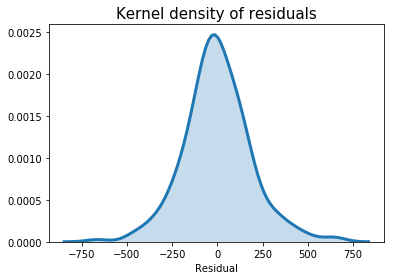

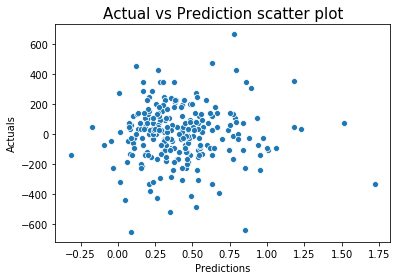

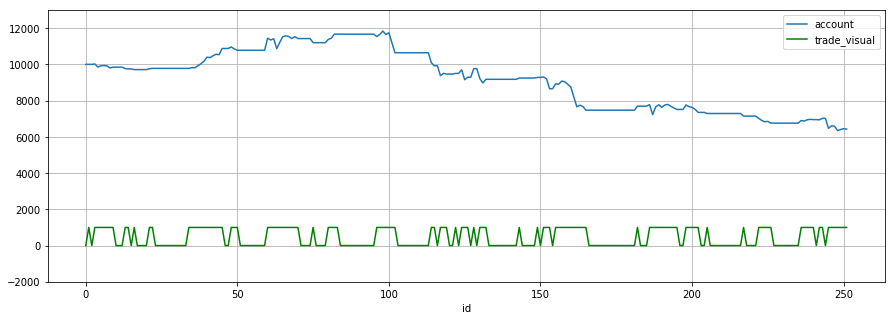

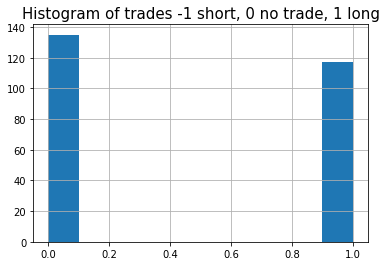

In [98]:
corn_account_nn = get_performance(corn_clf_reg_nn, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=0.4)

In [99]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1922 samples, validate on 481 samples
Epoch 1/1000
1922/1922 [==============================] - 3s 1ms/step - loss: 133706.1915 - val_loss: 121255.1918

Epoch 00001: val_loss improved from inf to 121255.19179, saving model to saved_models/weights.coffee_reg.hdf5
Epoch 2/1000
1922/1922 [==============================] - 0s 172us/step - loss: 133702.3569 - val_loss: 121254.9406

Epoch 00002: val_loss improved from 121255.19179 to 121254.94059, saving model to saved_models/weights.coffee_reg.hdf5
Epoch 3/1000
1922/1922 [==============================] - 0s 165us/step - loss: 133702.1928 - val_loss: 121255.7356

Epoch 00003: val_loss did not improve from 121254.94059
Epoch 4/1000
1922/1922 [==============================] - 0s 164us/step - loss: 133681.9556 - val_loss: 121256.3289

Epoch 00004: val_loss did not improve from 121254.94059
Epoch 5/1000
1922/1922 [==============================] - 0s 163us/step - loss: 133700.4756 - val_loss: 121256.6739

Epoch 00005: val_loss did not

1922/1922 [==============================] - 0s 157us/step - loss: 133205.4679 - val_loss: 121394.3450

Epoch 00047: val_loss did not improve from 121254.94059
Epoch 48/1000
1922/1922 [==============================] - 0s 166us/step - loss: 133189.9058 - val_loss: 121399.1158

Epoch 00048: val_loss did not improve from 121254.94059
Epoch 49/1000
1922/1922 [==============================] - 0s 160us/step - loss: 133179.4292 - val_loss: 121409.1569

Epoch 00049: val_loss did not improve from 121254.94059
Epoch 50/1000
1922/1922 [==============================] - 0s 153us/step - loss: 133151.4275 - val_loss: 121427.2978

Epoch 00050: val_loss did not improve from 121254.94059
Epoch 51/1000
1922/1922 [==============================] - 0s 168us/step - loss: 133039.9005 - val_loss: 121432.8013

Epoch 00051: val_loss did not improve from 121254.94059
Epoch 52/1000
1922/1922 [==============================] - 0s 157us/step - loss: 133094.5713 - val_loss: 121438.0293

Epoch 00052: val_loss did 

1922/1922 [==============================] - 0s 158us/step - loss: 131196.4874 - val_loss: 121704.6830

Epoch 00094: val_loss did not improve from 121254.94059
Epoch 95/1000
1922/1922 [==============================] - 0s 151us/step - loss: 131159.0110 - val_loss: 121725.7906

Epoch 00095: val_loss did not improve from 121254.94059
Epoch 96/1000
1922/1922 [==============================] - 0s 163us/step - loss: 131037.0486 - val_loss: 121747.2477

Epoch 00096: val_loss did not improve from 121254.94059
Epoch 97/1000
1922/1922 [==============================] - 0s 162us/step - loss: 130908.7154 - val_loss: 121754.2431

Epoch 00097: val_loss did not improve from 121254.94059
Epoch 98/1000
1922/1922 [==============================] - 0s 158us/step - loss: 130979.2079 - val_loss: 121756.1728

Epoch 00098: val_loss did not improve from 121254.94059
Epoch 99/1000
1922/1922 [==============================] - 0s 170us/step - loss: 130767.5194 - val_loss: 121764.0317

Epoch 00099: val_loss did 

1922/1922 [==============================] - 0s 164us/step - loss: 127859.5265 - val_loss: 122016.5936

Epoch 00141: val_loss did not improve from 121254.94059
Epoch 142/1000
1922/1922 [==============================] - 0s 148us/step - loss: 127883.5978 - val_loss: 122027.1144

Epoch 00142: val_loss did not improve from 121254.94059
Epoch 143/1000
1922/1922 [==============================] - 0s 162us/step - loss: 127653.4898 - val_loss: 122029.3729

Epoch 00143: val_loss did not improve from 121254.94059
Epoch 144/1000
1922/1922 [==============================] - 0s 156us/step - loss: 127694.3827 - val_loss: 122041.7744

Epoch 00144: val_loss did not improve from 121254.94059
Epoch 145/1000
1922/1922 [==============================] - 0s 159us/step - loss: 127474.1815 - val_loss: 122041.2688

Epoch 00145: val_loss did not improve from 121254.94059
Epoch 146/1000
1922/1922 [==============================] - 0s 146us/step - loss: 127250.8446 - val_loss: 122061.8936

Epoch 00146: val_loss

1922/1922 [==============================] - 0s 160us/step - loss: 123046.4480 - val_loss: 122505.9315

Epoch 00188: val_loss did not improve from 121254.94059
Epoch 189/1000
1922/1922 [==============================] - 0s 176us/step - loss: 123551.8456 - val_loss: 122532.5667

Epoch 00189: val_loss did not improve from 121254.94059
Epoch 190/1000
1922/1922 [==============================] - 0s 156us/step - loss: 122961.4507 - val_loss: 122532.5210

Epoch 00190: val_loss did not improve from 121254.94059
Epoch 191/1000
1922/1922 [==============================] - 0s 163us/step - loss: 122940.2714 - val_loss: 122535.4617

Epoch 00191: val_loss did not improve from 121254.94059
Epoch 192/1000
1922/1922 [==============================] - 0s 167us/step - loss: 123046.1989 - val_loss: 122550.5599

Epoch 00192: val_loss did not improve from 121254.94059
Epoch 193/1000
1922/1922 [==============================] - 0s 152us/step - loss: 123042.3296 - val_loss: 122564.6217

Epoch 00193: val_loss

1922/1922 [==============================] - 0s 160us/step - loss: 118179.9291 - val_loss: 123021.9536

Epoch 00235: val_loss did not improve from 121254.94059
Epoch 236/1000
1922/1922 [==============================] - 0s 169us/step - loss: 117588.9512 - val_loss: 123010.4346

Epoch 00236: val_loss did not improve from 121254.94059
Epoch 237/1000
1922/1922 [==============================] - 0s 159us/step - loss: 117942.7385 - val_loss: 123028.6063

Epoch 00237: val_loss did not improve from 121254.94059
Epoch 238/1000
1922/1922 [==============================] - 0s 158us/step - loss: 117549.0965 - val_loss: 122989.8256

Epoch 00238: val_loss did not improve from 121254.94059
Epoch 239/1000
1922/1922 [==============================] - 0s 187us/step - loss: 117325.5829 - val_loss: 123019.9955

Epoch 00239: val_loss did not improve from 121254.94059
Epoch 240/1000
1922/1922 [==============================] - 0s 189us/step - loss: 117235.9417 - val_loss: 123007.2082

Epoch 00240: val_loss

1922/1922 [==============================] - 0s 148us/step - loss: 111309.4917 - val_loss: 123830.2950

Epoch 00282: val_loss did not improve from 121254.94059
Epoch 283/1000
1922/1922 [==============================] - 0s 153us/step - loss: 111626.7060 - val_loss: 123795.8281

Epoch 00283: val_loss did not improve from 121254.94059
Epoch 284/1000
1922/1922 [==============================] - 0s 149us/step - loss: 111120.8156 - val_loss: 123793.3050

Epoch 00284: val_loss did not improve from 121254.94059
Epoch 285/1000
1922/1922 [==============================] - 0s 145us/step - loss: 111334.0378 - val_loss: 123795.2342

Epoch 00285: val_loss did not improve from 121254.94059
Epoch 286/1000
1922/1922 [==============================] - 0s 180us/step - loss: 110366.0689 - val_loss: 123753.0920

Epoch 00286: val_loss did not improve from 121254.94059
Epoch 287/1000
1922/1922 [==============================] - 0s 167us/step - loss: 110689.9846 - val_loss: 123781.7759

Epoch 00287: val_loss

1922/1922 [==============================] - 0s 146us/step - loss: 105012.7796 - val_loss: 124666.8840

Epoch 00329: val_loss did not improve from 121254.94059
Epoch 330/1000
1922/1922 [==============================] - 0s 149us/step - loss: 105520.3436 - val_loss: 124783.0226

Epoch 00330: val_loss did not improve from 121254.94059
Epoch 331/1000
1922/1922 [==============================] - 0s 154us/step - loss: 104622.8593 - val_loss: 124726.5059

Epoch 00331: val_loss did not improve from 121254.94059
Epoch 332/1000
1922/1922 [==============================] - 0s 149us/step - loss: 104309.5128 - val_loss: 124794.8473

Epoch 00332: val_loss did not improve from 121254.94059
Epoch 333/1000
1922/1922 [==============================] - 0s 148us/step - loss: 103319.0591 - val_loss: 124869.9432

Epoch 00333: val_loss did not improve from 121254.94059
Epoch 334/1000
1922/1922 [==============================] - 0s 147us/step - loss: 103873.8405 - val_loss: 124871.6480

Epoch 00334: val_loss

1922/1922 [==============================] - 0s 143us/step - loss: 98171.6685 - val_loss: 126122.4759

Epoch 00376: val_loss did not improve from 121254.94059
Epoch 377/1000
1922/1922 [==============================] - 0s 148us/step - loss: 97057.4485 - val_loss: 126242.1848

Epoch 00377: val_loss did not improve from 121254.94059
Epoch 378/1000
1922/1922 [==============================] - 0s 141us/step - loss: 98039.2717 - val_loss: 126189.0260

Epoch 00378: val_loss did not improve from 121254.94059
Epoch 379/1000
1922/1922 [==============================] - 0s 142us/step - loss: 97008.3117 - val_loss: 126219.3961

Epoch 00379: val_loss did not improve from 121254.94059
Epoch 380/1000
1922/1922 [==============================] - 0s 141us/step - loss: 96770.8240 - val_loss: 126218.8489

Epoch 00380: val_loss did not improve from 121254.94059
Epoch 381/1000
1922/1922 [==============================] - 0s 145us/step - loss: 97893.5918 - val_loss: 126225.3906

Epoch 00381: val_loss did n

1922/1922 [==============================] - 0s 143us/step - loss: 90686.5899 - val_loss: 127469.2996

Epoch 00423: val_loss did not improve from 121254.94059
Epoch 424/1000
1922/1922 [==============================] - 0s 140us/step - loss: 91271.9179 - val_loss: 127539.2619

Epoch 00424: val_loss did not improve from 121254.94059
Epoch 425/1000
1922/1922 [==============================] - 0s 144us/step - loss: 89209.8276 - val_loss: 127534.1235

Epoch 00425: val_loss did not improve from 121254.94059
Epoch 426/1000
1922/1922 [==============================] - 0s 142us/step - loss: 91637.3743 - val_loss: 127547.6200

Epoch 00426: val_loss did not improve from 121254.94059
Epoch 427/1000
1922/1922 [==============================] - 0s 141us/step - loss: 90410.7022 - val_loss: 127512.7337

Epoch 00427: val_loss did not improve from 121254.94059
Epoch 428/1000
1922/1922 [==============================] - 0s 144us/step - loss: 88644.4295 - val_loss: 127509.0896

Epoch 00428: val_loss did n

1922/1922 [==============================] - 0s 140us/step - loss: 82973.6949 - val_loss: 129607.6260

Epoch 00470: val_loss did not improve from 121254.94059
Epoch 471/1000
1922/1922 [==============================] - 0s 148us/step - loss: 83733.8590 - val_loss: 129742.0102

Epoch 00471: val_loss did not improve from 121254.94059
Epoch 472/1000
1922/1922 [==============================] - 0s 148us/step - loss: 84313.8412 - val_loss: 129971.9129

Epoch 00472: val_loss did not improve from 121254.94059
Epoch 473/1000
1922/1922 [==============================] - 0s 150us/step - loss: 84229.3698 - val_loss: 129893.2900

Epoch 00473: val_loss did not improve from 121254.94059
Epoch 474/1000
1922/1922 [==============================] - 0s 152us/step - loss: 81757.1648 - val_loss: 129877.7721

Epoch 00474: val_loss did not improve from 121254.94059
Epoch 475/1000
1922/1922 [==============================] - 0s 148us/step - loss: 82813.5714 - val_loss: 129985.4199

Epoch 00475: val_loss did n

1922/1922 [==============================] - 0s 138us/step - loss: 75373.4905 - val_loss: 131959.8137

Epoch 00517: val_loss did not improve from 121254.94059
Epoch 518/1000
1922/1922 [==============================] - 0s 135us/step - loss: 76922.5812 - val_loss: 132030.6070

Epoch 00518: val_loss did not improve from 121254.94059
Epoch 519/1000
1922/1922 [==============================] - 0s 134us/step - loss: 77480.8800 - val_loss: 132062.2815

Epoch 00519: val_loss did not improve from 121254.94059
Epoch 520/1000
1922/1922 [==============================] - 0s 139us/step - loss: 75507.9658 - val_loss: 132330.3843

Epoch 00520: val_loss did not improve from 121254.94059
Epoch 521/1000
1922/1922 [==============================] - 0s 135us/step - loss: 76059.8058 - val_loss: 132552.1548

Epoch 00521: val_loss did not improve from 121254.94059
Epoch 522/1000
1922/1922 [==============================] - 0s 137us/step - loss: 73966.6411 - val_loss: 132687.9388

Epoch 00522: val_loss did n

1922/1922 [==============================] - 0s 143us/step - loss: 69064.2471 - val_loss: 135445.0622

Epoch 00564: val_loss did not improve from 121254.94059
Epoch 565/1000
1922/1922 [==============================] - 0s 139us/step - loss: 67990.4020 - val_loss: 135026.8162

Epoch 00565: val_loss did not improve from 121254.94059
Epoch 566/1000
1922/1922 [==============================] - 0s 134us/step - loss: 68944.8325 - val_loss: 134810.4451

Epoch 00566: val_loss did not improve from 121254.94059
Epoch 567/1000
1922/1922 [==============================] - 0s 136us/step - loss: 67324.9971 - val_loss: 135050.8606

Epoch 00567: val_loss did not improve from 121254.94059
Epoch 568/1000
1922/1922 [==============================] - 0s 136us/step - loss: 68923.5793 - val_loss: 135106.1783

Epoch 00568: val_loss did not improve from 121254.94059
Epoch 569/1000
1922/1922 [==============================] - 0s 138us/step - loss: 68567.6044 - val_loss: 135697.9511

Epoch 00569: val_loss did n

1922/1922 [==============================] - 0s 138us/step - loss: 61428.9710 - val_loss: 138548.5954

Epoch 00611: val_loss did not improve from 121254.94059
Epoch 612/1000
1922/1922 [==============================] - 0s 134us/step - loss: 61819.8367 - val_loss: 138387.1290

Epoch 00612: val_loss did not improve from 121254.94059
Epoch 613/1000
1922/1922 [==============================] - 0s 136us/step - loss: 61874.1338 - val_loss: 138588.2926

Epoch 00613: val_loss did not improve from 121254.94059
Epoch 614/1000
1922/1922 [==============================] - 0s 139us/step - loss: 61518.3657 - val_loss: 138660.0464

Epoch 00614: val_loss did not improve from 121254.94059
Epoch 615/1000
1922/1922 [==============================] - 0s 132us/step - loss: 62932.1710 - val_loss: 138543.9413

Epoch 00615: val_loss did not improve from 121254.94059
Epoch 616/1000
1922/1922 [==============================] - 0s 135us/step - loss: 61626.1181 - val_loss: 138486.7744

Epoch 00616: val_loss did n

1922/1922 [==============================] - 0s 142us/step - loss: 57139.2594 - val_loss: 143296.1011

Epoch 00658: val_loss did not improve from 121254.94059
Epoch 659/1000
1922/1922 [==============================] - 0s 139us/step - loss: 53793.6079 - val_loss: 143189.4211

Epoch 00659: val_loss did not improve from 121254.94059
Epoch 660/1000
1922/1922 [==============================] - 0s 137us/step - loss: 54330.1692 - val_loss: 143661.4988

Epoch 00660: val_loss did not improve from 121254.94059
Epoch 661/1000
1922/1922 [==============================] - 0s 136us/step - loss: 53773.0170 - val_loss: 143773.1651

Epoch 00661: val_loss did not improve from 121254.94059
Epoch 662/1000
1922/1922 [==============================] - 0s 161us/step - loss: 55432.9712 - val_loss: 143202.2383

Epoch 00662: val_loss did not improve from 121254.94059
Epoch 663/1000
1922/1922 [==============================] - 0s 168us/step - loss: 55849.8669 - val_loss: 143576.8554

Epoch 00663: val_loss did n

1922/1922 [==============================] - 0s 162us/step - loss: 51644.7317 - val_loss: 147606.0540

Epoch 00705: val_loss did not improve from 121254.94059
Epoch 706/1000
1922/1922 [==============================] - 0s 153us/step - loss: 48056.8973 - val_loss: 147152.7539

Epoch 00706: val_loss did not improve from 121254.94059
Epoch 707/1000
1922/1922 [==============================] - 0s 151us/step - loss: 48362.3975 - val_loss: 147643.4162

Epoch 00707: val_loss did not improve from 121254.94059
Epoch 708/1000
1922/1922 [==============================] - 0s 149us/step - loss: 48817.4498 - val_loss: 148018.3798

Epoch 00708: val_loss did not improve from 121254.94059
Epoch 709/1000
1922/1922 [==============================] - 0s 147us/step - loss: 50148.6984 - val_loss: 148423.3242

Epoch 00709: val_loss did not improve from 121254.94059
Epoch 710/1000
1922/1922 [==============================] - 0s 145us/step - loss: 48396.8722 - val_loss: 148596.7153

Epoch 00710: val_loss did n

1922/1922 [==============================] - 0s 142us/step - loss: 45109.9626 - val_loss: 151508.9570

Epoch 00752: val_loss did not improve from 121254.94059
Epoch 753/1000
1922/1922 [==============================] - 0s 141us/step - loss: 44954.9689 - val_loss: 151455.4683

Epoch 00753: val_loss did not improve from 121254.94059
Epoch 754/1000
1922/1922 [==============================] - 0s 140us/step - loss: 46120.7516 - val_loss: 152180.3856

Epoch 00754: val_loss did not improve from 121254.94059
Epoch 755/1000
1922/1922 [==============================] - 0s 140us/step - loss: 46691.7636 - val_loss: 152619.4262

Epoch 00755: val_loss did not improve from 121254.94059
Epoch 756/1000
1922/1922 [==============================] - 0s 142us/step - loss: 42652.9236 - val_loss: 152760.2548

Epoch 00756: val_loss did not improve from 121254.94059
Epoch 757/1000
1922/1922 [==============================] - 0s 151us/step - loss: 43993.1054 - val_loss: 152411.0270

Epoch 00757: val_loss did n

1922/1922 [==============================] - 0s 149us/step - loss: 40287.3942 - val_loss: 157933.8927

Epoch 00799: val_loss did not improve from 121254.94059
Epoch 800/1000
1922/1922 [==============================] - 0s 141us/step - loss: 41580.5524 - val_loss: 158517.0549

Epoch 00800: val_loss did not improve from 121254.94059
Epoch 801/1000
1922/1922 [==============================] - 0s 140us/step - loss: 40510.0944 - val_loss: 158861.5274

Epoch 00801: val_loss did not improve from 121254.94059
Epoch 802/1000
1922/1922 [==============================] - 0s 141us/step - loss: 41015.7826 - val_loss: 158249.4508

Epoch 00802: val_loss did not improve from 121254.94059
Epoch 803/1000
1922/1922 [==============================] - 0s 141us/step - loss: 38872.6214 - val_loss: 158103.5559

Epoch 00803: val_loss did not improve from 121254.94059
Epoch 804/1000
1922/1922 [==============================] - 0s 141us/step - loss: 40896.9950 - val_loss: 158949.6481

Epoch 00804: val_loss did n

1922/1922 [==============================] - 0s 143us/step - loss: 35841.6707 - val_loss: 162115.5203

Epoch 00846: val_loss did not improve from 121254.94059
Epoch 847/1000
1922/1922 [==============================] - 0s 141us/step - loss: 36766.2550 - val_loss: 161850.9870

Epoch 00847: val_loss did not improve from 121254.94059
Epoch 848/1000
1922/1922 [==============================] - 0s 138us/step - loss: 36140.7423 - val_loss: 163233.1774

Epoch 00848: val_loss did not improve from 121254.94059
Epoch 849/1000
1922/1922 [==============================] - 0s 142us/step - loss: 38325.9383 - val_loss: 163001.2548

Epoch 00849: val_loss did not improve from 121254.94059
Epoch 850/1000
1922/1922 [==============================] - 0s 152us/step - loss: 36545.0680 - val_loss: 163017.3674

Epoch 00850: val_loss did not improve from 121254.94059
Epoch 851/1000
1922/1922 [==============================] - 0s 152us/step - loss: 34162.7390 - val_loss: 162310.7090

Epoch 00851: val_loss did n

1922/1922 [==============================] - 0s 162us/step - loss: 34681.2253 - val_loss: 168388.0449

Epoch 00893: val_loss did not improve from 121254.94059
Epoch 894/1000
1922/1922 [==============================] - 0s 157us/step - loss: 37119.7937 - val_loss: 169245.3746

Epoch 00894: val_loss did not improve from 121254.94059
Epoch 895/1000
1922/1922 [==============================] - 0s 147us/step - loss: 36402.8406 - val_loss: 169970.8396

Epoch 00895: val_loss did not improve from 121254.94059
Epoch 896/1000
1922/1922 [==============================] - 0s 165us/step - loss: 32329.7754 - val_loss: 169424.2981

Epoch 00896: val_loss did not improve from 121254.94059
Epoch 897/1000
1922/1922 [==============================] - 0s 144us/step - loss: 35981.1647 - val_loss: 169017.0679

Epoch 00897: val_loss did not improve from 121254.94059
Epoch 898/1000
1922/1922 [==============================] - 0s 141us/step - loss: 33781.5265 - val_loss: 168682.6756

Epoch 00898: val_loss did n

1922/1922 [==============================] - 0s 155us/step - loss: 31808.7608 - val_loss: 171778.7244

Epoch 00940: val_loss did not improve from 121254.94059
Epoch 941/1000
1922/1922 [==============================] - 0s 148us/step - loss: 30953.1644 - val_loss: 172402.9035

Epoch 00941: val_loss did not improve from 121254.94059
Epoch 942/1000
1922/1922 [==============================] - 0s 153us/step - loss: 31383.5515 - val_loss: 172877.7619

Epoch 00942: val_loss did not improve from 121254.94059
Epoch 943/1000
1922/1922 [==============================] - 0s 160us/step - loss: 32494.1169 - val_loss: 172366.6420

Epoch 00943: val_loss did not improve from 121254.94059
Epoch 944/1000
1922/1922 [==============================] - 0s 152us/step - loss: 34286.0771 - val_loss: 172321.1974

Epoch 00944: val_loss did not improve from 121254.94059
Epoch 945/1000
1922/1922 [==============================] - 0s 152us/step - loss: 33998.6072 - val_loss: 172684.5686

Epoch 00945: val_loss did n

1922/1922 [==============================] - 0s 142us/step - loss: 31106.4812 - val_loss: 175620.6297

Epoch 00987: val_loss did not improve from 121254.94059
Epoch 988/1000
1922/1922 [==============================] - 0s 141us/step - loss: 31907.8211 - val_loss: 175291.1199

Epoch 00988: val_loss did not improve from 121254.94059
Epoch 989/1000
1922/1922 [==============================] - 0s 142us/step - loss: 30439.2143 - val_loss: 175386.5982

Epoch 00989: val_loss did not improve from 121254.94059
Epoch 990/1000
1922/1922 [==============================] - 0s 145us/step - loss: 32792.8692 - val_loss: 175939.8314

Epoch 00990: val_loss did not improve from 121254.94059
Epoch 991/1000
1922/1922 [==============================] - 0s 140us/step - loss: 32270.8122 - val_loss: 176126.6282

Epoch 00991: val_loss did not improve from 121254.94059
Epoch 992/1000
1922/1922 [==============================] - 0s 142us/step - loss: 31219.3083 - val_loss: 177484.8562

Epoch 00992: val_loss did n

In [100]:
model = regressor_model()
model.load_weights('saved_models/weights.coffee_reg.hdf5')
coffee_clf_reg_nn = model

Predictions/Actual volatility correlation:  0.003322910730687108
Returns  -6.25 %
Number of trades:  1
Number of short trades:  0
Number of long trades:  1
Earnings per trade:  -624.94
Earnings per short trade:  0.00
Earnings per long trade:  -624.94


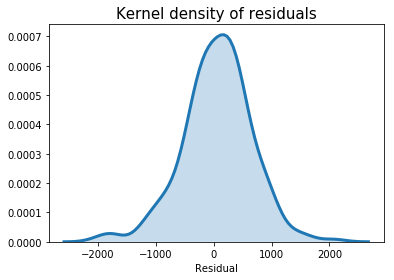

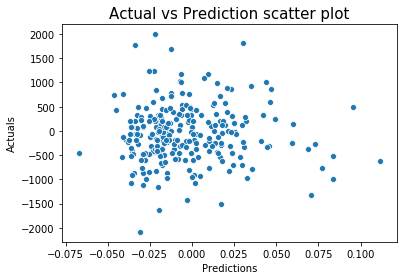

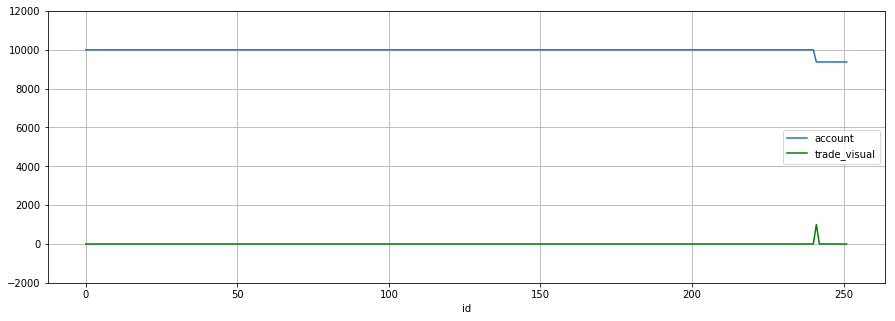

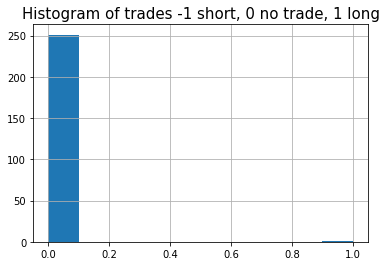

In [101]:
coffee_account_nn = get_performance(coffee_clf_reg_nn, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=0.1)

# Conclusions
Only Gold regressor has data that returns positive results. Correlation between actual gold price and predictions is around $0.15$ (depending on training).

Corn and Coffee has rather random correlation with actual performance (also training is not going well).
Last weights update for keras neural network regressor (1000 epochs):

| Gold | Corn | Coffee |
|------|------|--------|
| 512  |   32 | 1      |

I am surprised that I cannot achieve better results with corn. Since corn retained most information by PCA transformation. I expected to have best training results with corn.

# H2O AutoML experiment

In [102]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/connection.py:317: UserWarning: Proxy is defined in the environment: HTTP_PROXY. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/connection.py:317: UserWarning: Proxy is defined in the environment: http_proxy. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.1" 2018-10-16; OpenJDK Runtime Environment (build 11.0.1+13-Ubuntu-3ubuntu3.18.10.1); OpenJDK 64-Bit Server VM (build 11.0.1+13-Ubuntu-3ubuntu3.18.10.1, mixed mode, sharing)
  Starting server from /home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2ie5crcz
  JVM stdout: /tmp/tmp2ie5crcz/h2o_martin_started_from_python.out
  JVM stderr: /tmp/tmp2ie5crcz/h2o_martin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Bratislava
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_martin_envm85
H2O cluster total nodes:,1
H2O cluster free memory:,2.389 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


### Classification
Based on the H2O documentation only 2 categories are supported for AutoML. This model was generated for long trades.

In [103]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_long_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_long_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
validation[y] = validation[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_1_AutoML_20190207_154628_model_1,0.479587,0.607513,0.49148,0.456493,0.208386
XRT_1_AutoML_20190207_154628,0.477046,0.69162,0.5,0.476521,0.227073
StackedEnsemble_AllModels_AutoML_20190207_154628,0.476126,0.60746,0.5,0.456459,0.208355
StackedEnsemble_BestOfFamily_AutoML_20190207_154628,0.476126,0.60746,0.5,0.456459,0.208355
DRF_1_AutoML_20190207_154628,0.472127,0.650638,0.494616,0.474203,0.224868


glm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5611bcf28>]],
      dtype=object)

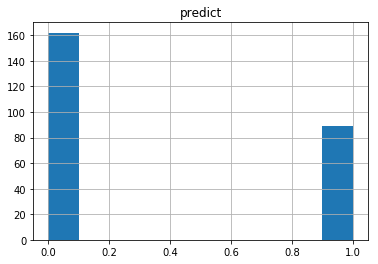

In [104]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

Returns  72.95 %
Number of trades:  89
Number of short trades:  0
Number of long trades:  89
Earnings per trade:  81.97
Earnings per short trade:  0.00
Earnings per long trade:  81.97


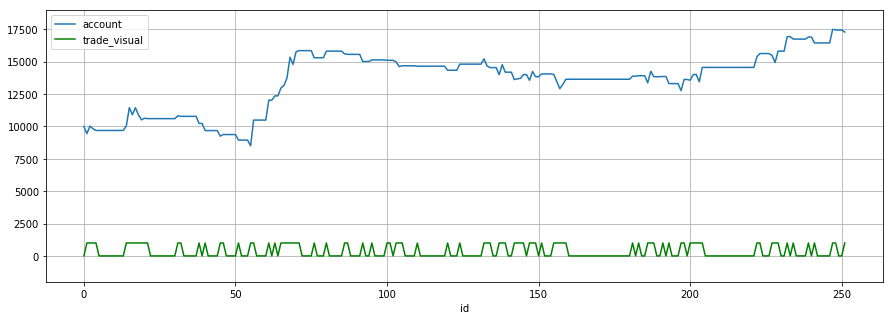

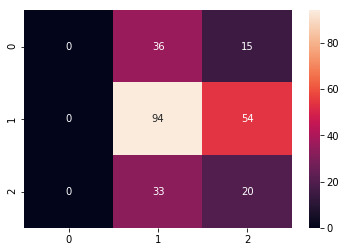

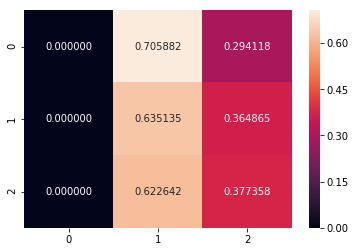

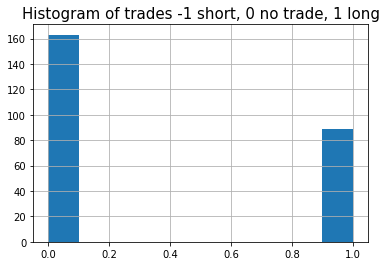

In [105]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

### H2O AutoML gold regressor

In [106]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_reg_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_reg_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_reg_test.csv", header=1)

# Identify predictors and response
print(train.head())
x = train.columns
y = "label"
x.remove(y)

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=40, max_runtime_secs=60, seed=1234, stopping_metric='deviance')
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
-331248,-27640.9,567537,65888,59525.3,252952,55627.9,-128754,107664,-216797,-88334.8,-158876,-132532,109755,-46152.6,-48243.4,102096,-26623.6,30557,96471.9,128856,-45498.6,7400.27,-52095.7,-102416,11413.4,193359,43174.8,2397.14,102818,51492,86161.9,36587.2,-431.163,-59398.9,-16408.3,-31970.8,7392.44,-41167.5,-38087.9,-79022.2,39880,74855.5,59099.8,-57810.6,4571.96,6865.5,69375.7,-24542.1,-2964.83,38010.9,50722.6,-49494,84525.8,-50325.3,1617.01,9757.53,40051,13361,28889.2,64254.2,-927.344,-13659.5,-973.585,57239.3,-14635.2,51039.1,-37447.1,71646.4,12300.9,7308.94,2995.98,66098,-25603.1,118375,-14342.2,23159.5,-106860,-30568.6,66324.5,-28319.3,-19414.8,74039.7,20878.1,-57363.5,-37656.5,15939.3,19836.3,52715.5,35991,40769.2,-14441.3,69806.5,36537.7,-44491.1,-57462,39878.1,25845.4,-8552.88,-6417.83,5903.48,-26696.2,6223.8,25249.4,16073.9,-3946.47,14822.4,-45238.9,-22718.6,-5387.21,63061.7,-21204.8,46718.1,-10246.8,-17679.4,82309.2,10278.2,33819.8,14791.7,-10318.9,38208.1,36031.4,-22415.4,-22948.7,9237.39,-46271.5,-16025.7,-32045.3,11528.7,-14694,-52873.6,65658.5,78371.1,-3786.76,15688.5,-13926,-47534.8,39424.6,-27202.7,-29934.4,-18343.1,20998.2,9208.38,-16001.3,43712.7,-4050.55,-25511,16382.3,-60760.7,3977.03,-19944.2,64013.7,-39727.3,-37917,-13036.8,52607.2,48494.9,38249.9,-88103.1,-40157.5,-36073.4,9875.56,42455.1,42717.8,-17228.2,-902.95,-28762.9,-41110.7,18957.3,-28820.2,15033.3,-17562.3,-8803.51,23882.9,37622.3,-16041.9,26617.1,15831.3,-1452.96,-24442.8,-13424.9,-17986.4,-54551.6,100337,-12982.5,-20857.6,-49309.7,-29425.2,9438.39,-31290.8,20001,74281.2,38789.7,34382.4,-2799.05,-39896.4,32486.2,74129.7,-38974.9,33943.5
-325632,-21861.3,570463,61896.1,12385.8,263138,67919.9,-122209,98093.1,-221691,-106287,-152934,-113510,123914,-42969.4,-38251.7,83308.7,-40120.2,40592,115483,118716,-59971.5,15404.1,-53785.8,-114764,16018.2,177401,-17123,17396.5,124792,34830.4,80182.2,61158.6,-37570.1,-29884.3,-1243.13,-41191.5,25931.6,198.042,-70567.6,2435.07,24739,104129,15369.9,-67739.2,-63275.3,41865.1,42055.7,458.742,-15286.7,3486.52,45515.7,-82916.5,55935.8,-75649.4,-26103.3,2369.58,42338.8,8161.88,64239.1,56469.8,14761.5,-45009.8,17551.6,24207.2,21459,97579.9,16854,104355,-10585.3,-15991.3,-10664.7,79435.3,1332.76,94045.8,-13272.3,40374.8,-26720.8,-46435.1,69752,-29560.7,-20420.7,15062.6,-49836.2,-69314.5,-75523.9,30552.3,30807.6,78707.6,20325.7,73373.8,-9184.14,23539.3,49531.5,-8248.75,-20231,7103.48,21536.8,-42549,12079.5,-10135.3,-38184.1,21524,40226.9,13054.8,38784.9,-46167.2,-17813.3,-19602,-25986.1,7817.18,-32128.9,-23314.1,-50007.2,-49561.8,26797.7,24791.3,78396.3,19204.7,21994.7,-62312.4,-39373.4,38829.6,10357.8,-792.608,163.776,17432.4,-69134,-45877.9,-39993.2,-11836,24834.9,29452.1,55929.8,39657.4,43875.6,31612.3,76769.7,14581.8,15596.5,36543.6,-14573.6,-387.628,23286.4,-29384.7,-7514.05,-19781.8,20652.3,2781.08,-13415.9,23300.7,46168.7,-48293.3,37659.9,68456.3,35566.7,-16892.2,-7713.68,7171.18,-13490.9,21885.4,29476.2,-18953.5,-19306.2,52039.9,-14114.8,-110200,-44815.4,-31763.5,15814.1,-13441.6,23622.1,30740.1,5327.42,45627.3,16424.6,34625.1,-8653.75,-18554,63492.4,28164.3,5081.91,1326.42,-41837,-30386,3184.34,-34923.6,-38657.6,-41088.3,-20688.8,-18062.2,5762.19,-46274.8,-456.058,-35580.8,-13500,-2665.41,15078.1,-39647.8,4789.56
-322972,-16385.8,56900


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GLM_grid_1_AutoML_20190207_154755_model_1,1.68431e+06,1297.81,1.68431e+06,895.899,nan
StackedEnsemble_AllModels_AutoML_20190207_154755,1.68533e+06,1298.2,1.68533e+06,896.418,nan
StackedEnsemble_BestOfFamily_AutoML_20190207_154755,1.68533e+06,1298.2,1.68533e+06,896.418,nan
GBM_grid_1_AutoML_20190207_154755_model_9,1.6923e+06,1300.88,1.6923e+06,897.703,nan
GBM_grid_1_AutoML_20190207_154755_model_7,1.6926e+06,1301,1.6926e+06,898.466,nan
GBM_grid_1_AutoML_20190207_154755_model_6,1.69501e+06,1301.93,1.69501e+06,899.696,nan
GBM_grid_1_AutoML_20190207_154755_model_5,1.6984e+06,1303.23,1.6984e+06,898.45,nan
GBM_grid_1_AutoML_20190207_154755_model_1,1.72597e+06,1313.76,1.72597e+06,910.145,nan
GBM_grid_1_AutoML_20190207_154755_model_4,1.73897e+06,1318.7,1.73897e+06,911.332,nan
GBM_5_AutoML_20190207_154755,1.74291e+06,1320.19,1.74291e+06,920.143,nan


glm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5611c5438>]],
      dtype=object)

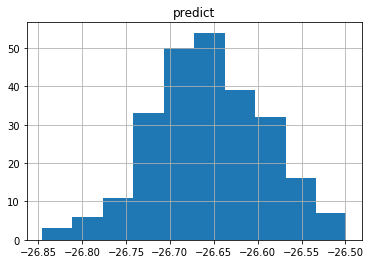

In [107]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [108]:
b

array([-26.64229968, -26.71641999, -26.708649  , -26.71515188,
       -26.63658053, -26.64446274, -26.64020086, -26.71253869,
       -26.66806547, -26.6756639 , -26.65211953, -26.64890615,
       -26.65344326, -26.61857664, -26.56154821, -26.57349536,
       -26.59273975, -26.64060133, -26.63128295, -26.66378233,
       -26.69216267, -26.72992689, -26.71783875, -26.6885868 ,
       -26.61967933, -26.58579422, -26.63610436, -26.69308651,
       -26.7082924 , -26.64246799, -26.54135393, -26.54918815,
       -26.64174458, -26.72843558, -26.78074026, -26.69889125,
       -26.73783544, -26.65964022, -26.65177147, -26.68606529,
       -26.67097812, -26.69366353, -26.6849714 , -26.6581517 ,
       -26.5768978 , -26.57849511, -26.66287907, -26.70672685,
       -26.70472282, -26.69631531, -26.64723116, -26.68017371,
       -26.64785677, -26.59564131, -26.63087327, -26.58388114,
       -26.62635637, -26.76022761, -26.7412088 , -26.68790975,
       -26.69833714, -26.70706475, -26.68660787, -26.66

In [109]:
def trade(x, treshold):
    ans = 0
    if abs(x) > treshold:
        if x > 0:
            ans = 1
        else:
            ans = -1
    return 0



preds = list(map(lambda x: trade(x, 200), b))

In [110]:
print(preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Returns  0.00 %
Number of trades:  251
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00


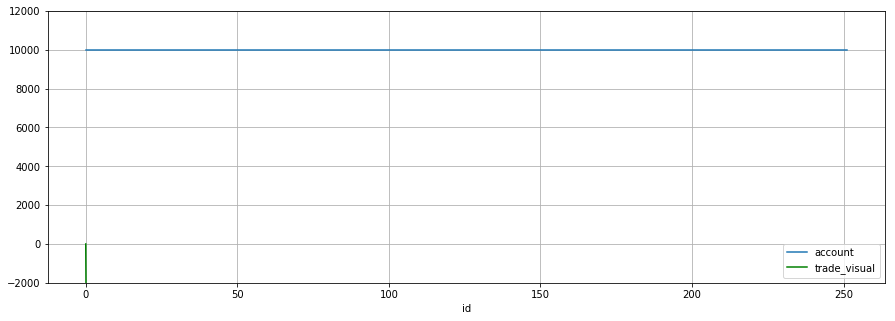

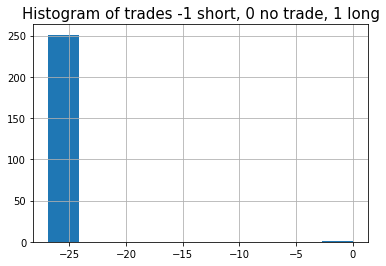

In [111]:
gold_account_reg = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True)

### H2O short trade

In [112]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_short_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_short_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_4_AutoML_20190207_155725,0.519649,0.652706,0.498539,0.472855,0.223592
GBM_grid_1_AutoML_20190207_155725_model_9,0.518424,1.12159,0.5,0.525174,0.275808
GBM_grid_1_AutoML_20190207_155725_model_7,0.517231,0.749949,0.5,0.498757,0.248758
GBM_1_AutoML_20190207_155725,0.514903,0.63345,0.499635,0.467266,0.218337
DRF_1_AutoML_20190207_155725,0.514799,0.644456,0.49188,0.470246,0.221131
GBM_grid_1_AutoML_20190207_155725_model_6,0.510856,0.603947,0.5,0.454695,0.206748
GBM_5_AutoML_20190207_155725,0.507968,0.616868,0.496502,0.460257,0.211836
GBM_grid_1_AutoML_20190207_155725_model_5,0.50742,0.604007,0.494704,0.454722,0.206772
GBM_3_AutoML_20190207_155725,0.503352,0.648492,0.495926,0.472189,0.222962
GBM_grid_1_AutoML_20190207_155725_model_3,0.502599,0.615589,0.5,0.459708,0.211331


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb560f5e9b0>]],
      dtype=object)

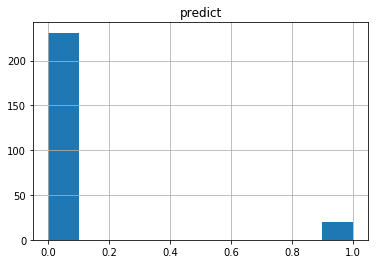

In [113]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = list(map(lambda x: -1 if x > 0 else 0, a.predict.values))
a.hist()

Returns  56.01 %
Number of trades:  20
Number of short trades:  20
Number of long trades:  0
Earnings per trade:  280.07
Earnings per short trade:  280.07
Earnings per long trade:  0.00


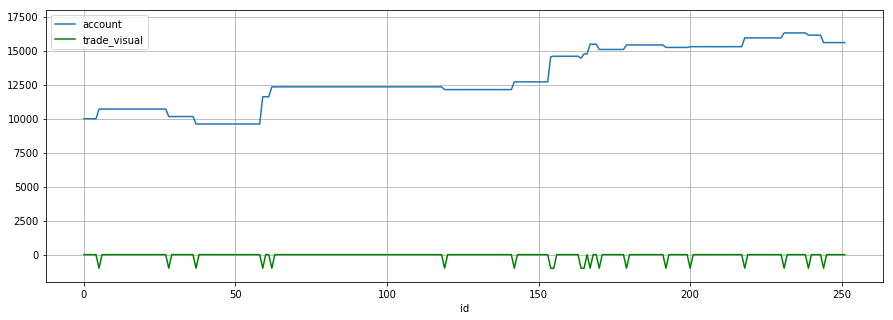

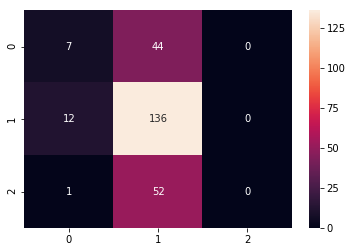

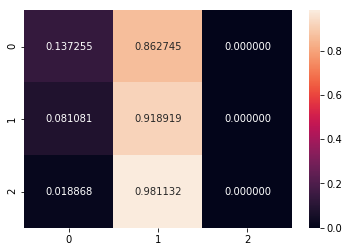

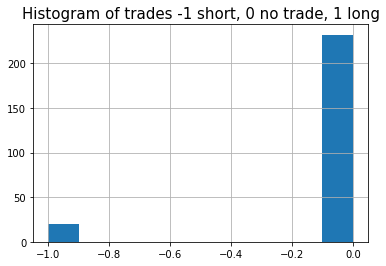

In [114]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [115]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_short_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_short_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20190207_160733_model_3,0.542602,0.598815,0.473194,0.452171,0.204458
GBM_5_AutoML_20190207_160733,0.533986,0.608311,0.498179,0.456043,0.207975
GBM_grid_1_AutoML_20190207_160733_model_5,0.533266,0.599328,0.459379,0.452441,0.204703
GBM_1_AutoML_20190207_160733,0.530715,0.622389,0.487948,0.461382,0.212874
DeepLearning_grid_1_AutoML_20190207_160733_model_1,0.528913,2.04514,0.5,0.564105,0.318215
DRF_1_AutoML_20190207_160733,0.528342,0.660491,0.5,0.464089,0.215378
GBM_4_AutoML_20190207_160733,0.52617,0.641655,0.499272,0.465791,0.216961
GBM_3_AutoML_20190207_160733,0.525998,0.635475,0.499636,0.464675,0.215923
GBM_grid_1_AutoML_20190207_160733_model_1,0.525667,0.599714,0.487542,0.452573,0.204822
GBM_2_AutoML_20190207_160733,0.522005,0.627753,0.49563,0.462955,0.214328


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb560e3a978>]],
      dtype=object)

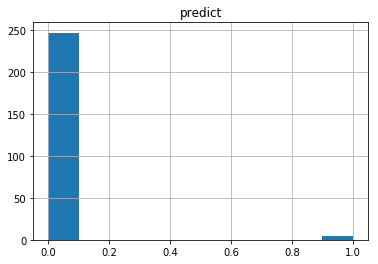

In [116]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x > 0 else 0).values
a.hist()

Returns  4.69 %
Number of trades:  4
Number of short trades:  4
Number of long trades:  0
Earnings per trade:  117.25
Earnings per short trade:  117.25
Earnings per long trade:  0.00


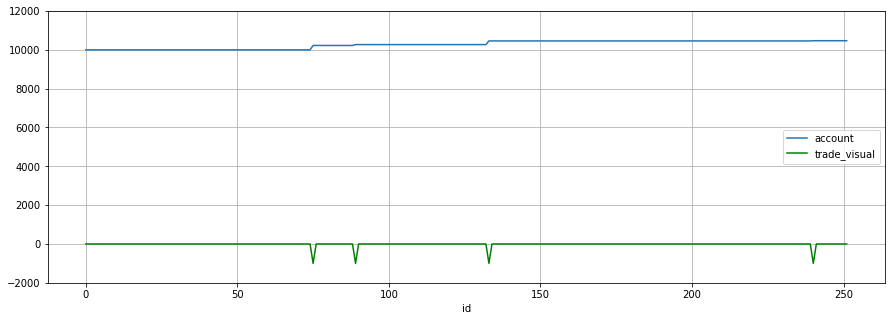

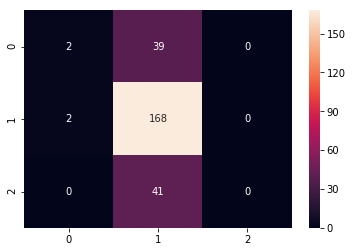

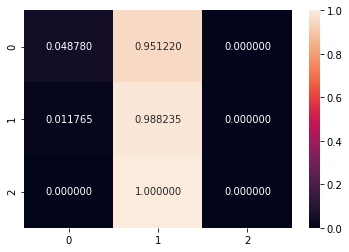

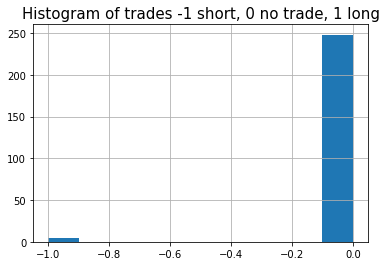

In [117]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [118]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_long_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_long_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_1_AutoML_20190207_161659,0.545483,0.631149,0.486863,0.466671,0.217782
StackedEnsemble_BestOfFamily_AutoML_20190207_161659,0.542098,0.613183,0.480375,0.459596,0.211229
GBM_4_AutoML_20190207_161659,0.53766,0.651727,0.498509,0.47314,0.223861
DeepLearning_grid_1_AutoML_20190207_161659_model_1,0.533907,2.06138,0.5,0.570499,0.325469
GBM_5_AutoML_20190207_161659,0.532961,0.623489,0.499627,0.464026,0.21532
StackedEnsemble_AllModels_AutoML_20190207_161659,0.530244,0.614126,0.485388,0.46001,0.21161
GBM_grid_1_AutoML_20190207_161659_model_5,0.528271,0.61419,0.473213,0.460061,0.211656
GBM_grid_1_AutoML_20190207_161659_model_3,0.525618,0.614071,0.475957,0.459999,0.211599
GBM_grid_1_AutoML_20190207_161659_model_1,0.523735,0.614736,0.499254,0.460275,0.211853
XRT_1_AutoML_20190207_161659,0.521799,0.642431,0.495296,0.47096,0.221803


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb561257f98>]],
      dtype=object)

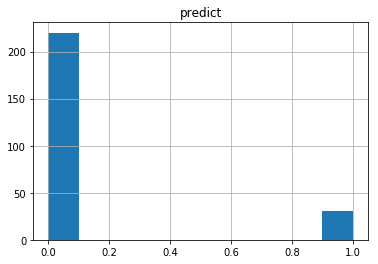

In [119]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

Returns  -14.59 %
Number of trades:  31
Number of short trades:  0
Number of long trades:  31
Earnings per trade:  -47.06
Earnings per short trade:  0.00
Earnings per long trade:  -47.06


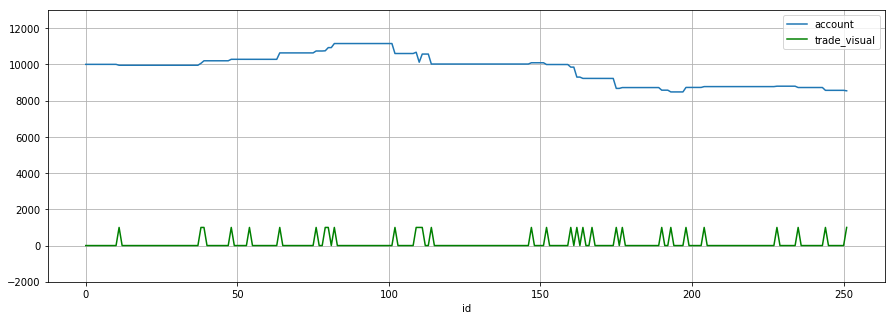

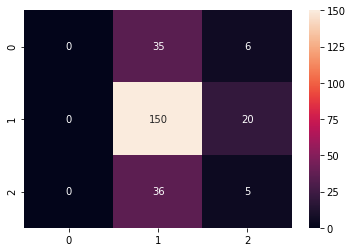

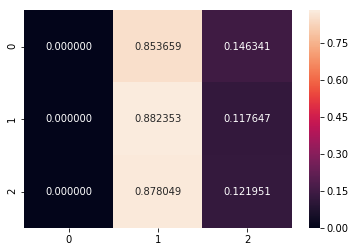

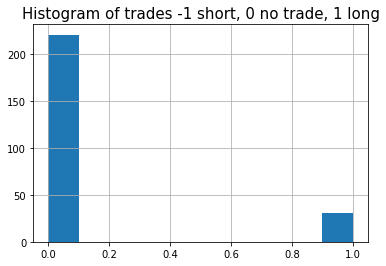

In [120]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [121]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_long_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_20190207_162625_model_3,0.532605,1.13938,0.5,0.566751,0.321207
GLM_grid_1_AutoML_20190207_162625_model_1,0.527217,0.658517,0.5,0.482574,0.232877
DeepLearning_grid_1_AutoML_20190207_162625_model_1,0.527132,2.09771,0.5,0.612409,0.375045
DeepLearning_grid_1_AutoML_20190207_162625_model_2,0.524419,1.36428,0.5,0.591347,0.349691
GBM_5_AutoML_20190207_162625,0.519542,0.668057,0.493053,0.486933,0.237104
GBM_1_AutoML_20190207_162625,0.518702,0.686336,0.5,0.49393,0.243967
GBM_4_AutoML_20190207_162625,0.514719,0.703042,0.499587,0.500172,0.250172
GBM_2_AutoML_20190207_162625,0.510637,0.691967,0.499053,0.496575,0.246587
GBM_grid_1_AutoML_20190207_162625_model_2,0.509639,1.26803,0.491646,0.576808,0.332708
DeepLearning_1_AutoML_20190207_162625,0.506667,0.794375,0.497815,0.525823,0.27649


deeplearning prediction progress: |███████████████████████████████████████| 100%
Returns  -37.70 %
Number of trades:  107
Number of short trades:  0
Number of long trades:  107
Earnings per trade:  -35.24
Earnings per short trade:  0.00
Earnings per long trade:  -35.24


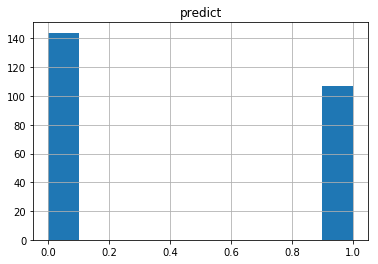

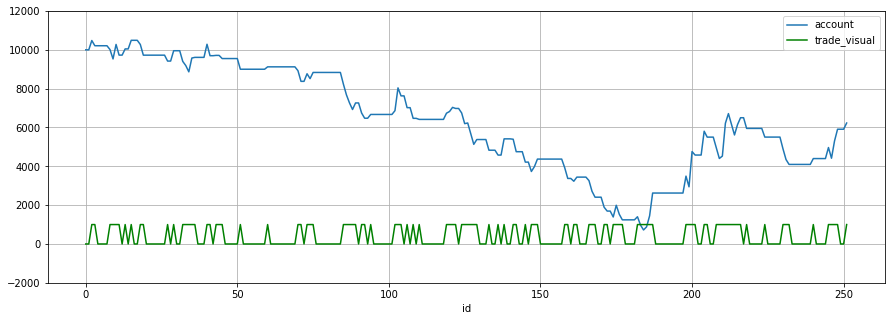

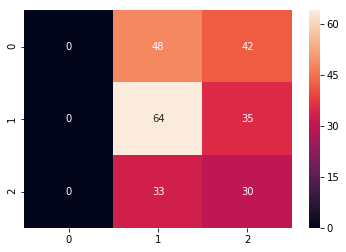

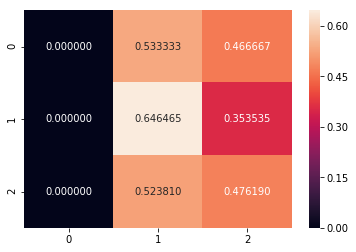

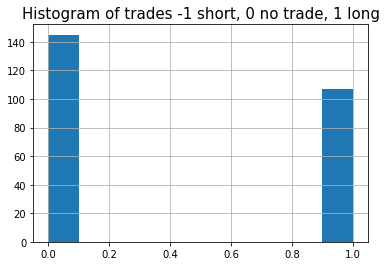

In [122]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

In [123]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_short_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_20190207_163600_model_4,0.513272,1.06025,0.495019,0.564556,0.318723
GBM_2_AutoML_20190207_163600,0.511064,0.698649,0.497471,0.500544,0.250544
DeepLearning_grid_1_AutoML_20190207_163600_model_2,0.509781,2.83244,0.5,0.647665,0.41947
GBM_4_AutoML_20190207_163600,0.506362,0.716539,0.5,0.506089,0.256126
GBM_3_AutoML_20190207_163600,0.502403,0.706331,0.5,0.502838,0.252846
GLM_grid_1_AutoML_20190207_163600_model_1,0.498935,0.666653,0.498733,0.486688,0.236866
XRT_1_AutoML_20190207_163600,0.498353,0.7057,0.498987,0.503283,0.253294
GBM_grid_1_AutoML_20190207_163600_model_2,0.497287,1.33192,0.5,0.5906,0.348809
StackedEnsemble_AllModels_AutoML_20190207_163600,0.497095,0.666139,0.5,0.486434,0.236618
DRF_1_AutoML_20190207_163600,0.496928,0.706637,0.498733,0.503576,0.253589


deeplearning prediction progress: |███████████████████████████████████████| 100%
Returns  204.28 %
Number of trades:  248
Number of short trades:  248
Number of long trades:  0
Earnings per trade:  82.37
Earnings per short trade:  82.37
Earnings per long trade:  0.00


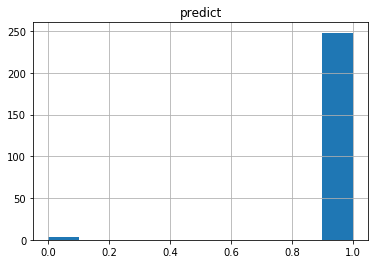

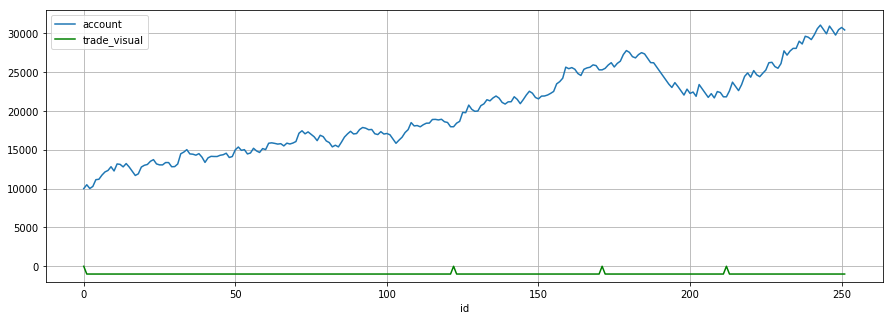

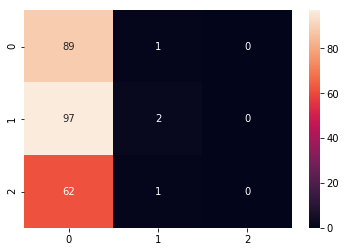

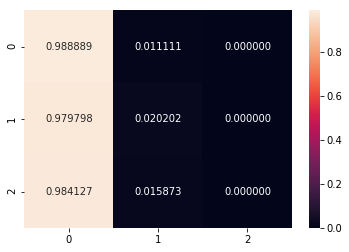

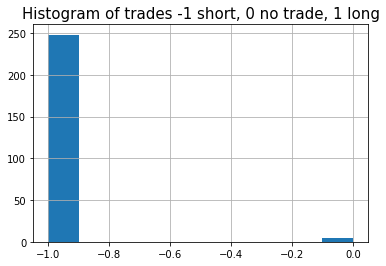

In [124]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

# H2O AutoML conclusion

AutoML regression results were very disappointing since all the predictions for gold were around -26 (which is mean value of training data). Classifiers seems to work better. I think you could get some information but overall I think it is necessary to get insight into the data.

In [125]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

# Comparison of performances

Below we will look at the comparison of the best trading strategy for each commodity versus mean reversal strategy and Nasdaq.

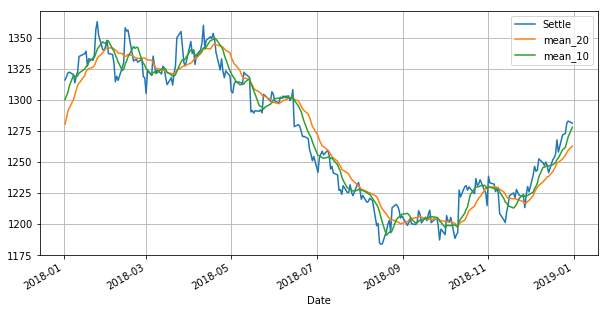

In [126]:
gold = mean_calculation(gold, 20, 10)
gold[['Settle', 'mean_20', 'mean_10']].loc[gold.index > validate_date].plot(figsize=(10,5), grid=True)
savefig('figures/gold_mean_reversal.eps')

In [127]:
nasdaq_amount = 10000/nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

nasdaq = nasdaq.loc[(nasdaq.index <= '2018-12-30')]

In [128]:
nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

6514.75

In [129]:
nasdaq_amount

1.5349783184312522

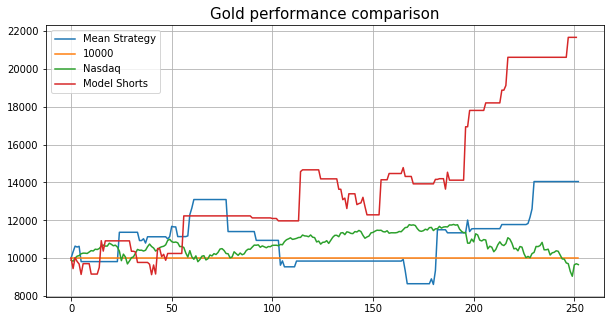

In [130]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
gold_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
gold_mean['Nasdaq'] = gold_mean['Nasdaq']*nasdaq_amount

# gold_account_nn = get_performance(gold_clf_reg_nn
ax = pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
               gold_account_nn.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
               ], axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Gold performance comparison', size=15)
savefig('figures/gold_benchmark_performance.eps')

In [131]:
gold_mean.head()

,account,base,Nasdaq
0,10000.0,10000,9894.853985
1,10332.5,10000,9837.292298
2,10636.5,10000,10000.000000
3,10589.0,10000,10107.064738
4,10627.0,10000,10136.229326


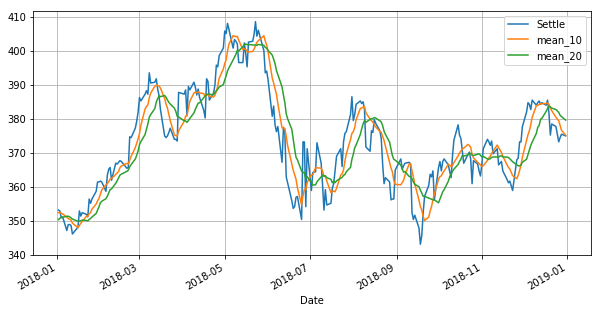

In [132]:
corn = mean_calculation(corn, 20, 10)
corn[['Settle', 'mean_10', 'mean_20']].loc[corn.index > validate_date].plot(figsize=(10,5), grid=True)

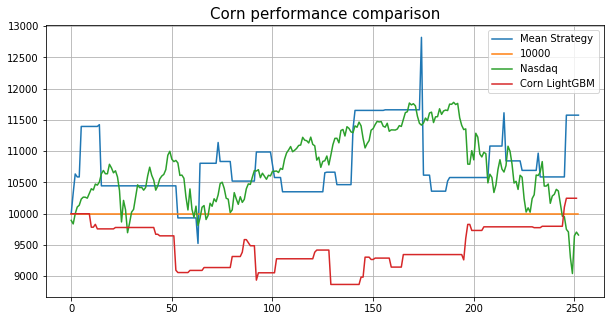

In [133]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
corn_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
corn_mean['Nasdaq'] = corn_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
               corn_account_lgb.rename(columns={'account': 'Corn LightGBM'})[['Corn LightGBM']]], 
               axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Corn performance comparison', size=15)

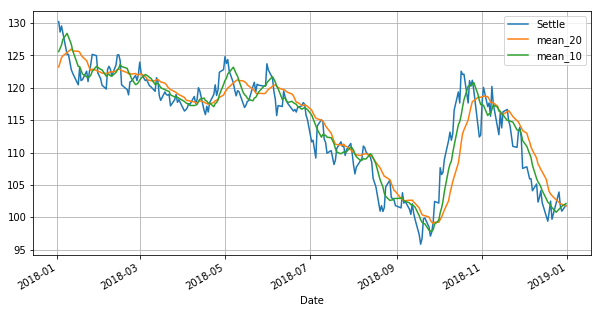

In [134]:
coffee = mean_calculation(coffee, 20, 10)
coffee[['Settle', 'mean_20', 'mean_10']].loc[coffee.index > validate_date].plot(figsize=(10,5), grid=True)

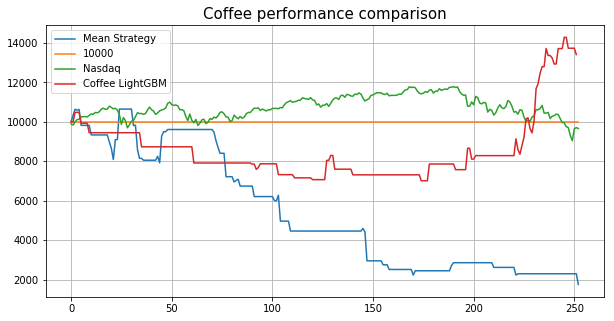

In [135]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
coffee_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
coffee_mean['Nasdaq'] = coffee_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
                coffee_account_lgb.rename(columns={'account': 'Coffee LightGBM'})[['Coffee LightGBM']],
               ], axis=1).plot(figsize=(10,5), grid=True)
title = ax.set_title('Coffee performance comparison', size=15)

# Conclusion

Trading is a difficult ML problem. Out of three compared commodities gold, corn and coffee we were able to predict performance with gold. Other commodities behaved randomly with approximately 0 correlation to the actual volatility.

In the beginning of project, I was thinking of a classifier (short, no trade, long) because it is closer to the usage of model. I tested regressor as well. Regressor works better because there is more information. I tried different loss function when training regressor. I decided to use weighted MSE. This could be further modified for better function omitting errors below threshold.

Gold trading is the most capital intensive with very big stop losses (1000 long, 800 short). This can be problem for trading with $10 000\$$ account.

In case of corn and coffee the data was almost impossible to classify. I suspect more data transformation is needed to get better results.